###IMPORT STATEMENTS


In [1]:
!pip install pandas numpy scikit-learn matplotlib seaborn imbalanced-learn

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.decomposition import PCA

###DATASET FETCH

In [3]:
!pip install ucimlrepo

In [4]:
from ucimlrepo import fetch_ucirepo
Wine = fetch_ucirepo(id=109)
Hd = fetch_ucirepo(id=80)

###DATA PREPARATION AND INSPECTION WITH PANDAS

In [5]:
X=pd.DataFrame(Wine.data.features,columns=Wine.data.feature_names)
Y=pd.DataFrame(Wine.data.targets,columns=Wine.data.target_names)
x=pd.DataFrame(Hd.data.features,columns=Hd.data.feature_names)
y=pd.DataFrame(Hd.data.targets,columns=Hd.data.target_names)

In [6]:
wine=pd.concat([X,Y],axis=1)
wine.tail()

Alcohol  Malicacid   Ash  Alcalinity_of_ash  Magnesium  Total_phenols  \
173    13.71       5.65  2.45               20.5         95           1.68   
174    13.40       3.91  2.48               23.0        102           1.80   
175    13.27       4.28  2.26               20.0        120           1.59   
176    13.17       2.59  2.37               20.0        120           1.65   
177    14.13       4.10  2.74               24.5         96           2.05   

     Flavanoids  Nonflavanoid_phenols  Proanthocyanins  Color_intensity   Hue  \
173        0.61                  0.52             1.06              7.7  0.64   
174        0.75                  0.43             1.41              7.3  0.70   
175        0.69                  0.43             1.35             10.2  0.59   
176        0.68                  0.53             1.46              9.3  0.60   
177        0.76                  0.56             1.35              9.2  0.61   

     0D280_0D315_of_diluted_wines  Proline  class  
173                          1.74      740      3  
174                          1.56      750      3  
175                          1.56      835      3  
176                          1.62      840      3  
177                          1.60      560      3

In [7]:
HD=pd.concat([x,y],axis=1)
HD.tail()

Attribute1  Attribute2  Attribute3  Attribute4  Attribute5  Attribute6  \
5615           0           0           4          10          13           6   
5616           0           0           6          16          13          11   
5617           0           0           1          11          15           1   
5618           0           0           2          10           7           0   
5619           0           0          10          14           8           1   

      Attribute7  Attribute8  Attribute9  Attribute10  ...  Attribute56  \
5615           0           0           0            1  ...            0   
5616           1           0           0            0  ...            0   
5617           0           0           0            0  ...            0   
5618           0           0           0            0  ...            0   
5619           0           0           0            2  ...            0   

      Attribute57  Attribute58  Attribute59  Attribute60  Attribute61  \
5615            0            0            2           14           15   
5616            0            0            6           16           14   
5617            0            0            2            9           13   
5618            0            0            5           12           16   
5619            0            1            8           12           14   

      Attribute62  Attribute63  Attribute64  class  
5615            9            0            0      9  
5616            6            0            0      0  
5617            6            0            0      8  
5618           12            0            0      9  
5619           12            1            0      8  

[5 rows x 65 columns]

###MACHINE LEARNING MODEL EVALUATION AND VISUALIZATION FUNCTIONS

In [8]:
# Function for splitting, scaling, and sampling the dataset
def preprocessing(X, y, test_split, scaler, sampler):
    if(scaler != None):
        X = scaler.fit_transform(X)
    # Ensure y is a 1D array
    y = y.ravel() if hasattr(y, 'ravel') else y
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split, random_state=10)
    if(sampler != None):
        X_train, y_train = RandomOverSampler().fit_resample(X_train, y_train)
    return X_train, y_train, X_test, y_test

In [9]:
# Function for training and prediction
def trainAndPredict(model, X_train, y_train, X_test, y_test):
    model = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred,zero_division=1)
    conf_matrix = confusion_matrix(y_test, y_pred)
    return accuracy, report, conf_matrix

In [10]:
def generateROCAndAUC(X, y, test_size, model, scaler, sampler):
    # This function plots the ROC curve for binary and multiclass classification.
    X_train, y_train, X_test, y_test = preprocessing(X, y, scaler=scaler, sampler=sampler, test_split=test_size)
    model.fit(X_train, y_train)

    plt.figure(figsize=(8, 6))

    if hasattr(model, "predict_proba"):
        probas = model.predict_proba(X_test)


        if probas.shape[1] == 2:
            prob_positive_class = probas[:, 1]
            fpr, tpr, _ = roc_curve(y_test, prob_positive_class)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')

        else:

            unique_classes = np.unique(y_test)
            y_test_binarized = label_binarize(y_test, classes=unique_classes)
            n_classes = y_test_binarized.shape[1]


            fpr = dict()
            tpr = dict()
            roc_auc = dict()


            if n_classes <= 20:
                colors = plt.get_cmap('tab20', n_classes)
            else:
                colors = plt.get_cmap('hsv', n_classes)

            for i in range(n_classes):
                fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], probas[:, i])
                roc_auc[i] = auc(fpr[i], tpr[i])
                plt.plot(fpr[i], tpr[i], color=colors(i), lw=2,
                         label=f'ROC curve of class {unique_classes[i]} (AUC = {roc_auc[i]:.2f})')
    else:

        decision_function = model.decision_function(X_test)
        if decision_function.ndim == 1:
            prob_positive_class = (decision_function - decision_function.min()) / (decision_function.max() - decision_function.min())
            fpr, tpr, _ = roc_curve(y_test, prob_positive_class)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        else:

            unique_classes = np.unique(y_test)
            y_test_binarized = label_binarize(y_test, classes=unique_classes)
            n_classes = y_test_binarized.shape[1]

            fpr = dict()
            tpr = dict()
            roc_auc = dict()


            if n_classes <= 20:
                colors = plt.get_cmap('tab20', n_classes)
            else:
                colors = plt.get_cmap('hsv', n_classes)


            for i in range(n_classes):
                fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], decision_function[:, i])
                roc_auc[i] = auc(fpr[i], tpr[i])
                plt.plot(fpr[i], tpr[i], color=colors(i), lw=2,
                         label=f'ROC curve of class {unique_classes[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for Classification')
    plt.legend(loc='lower right')
    plt.show()


In [11]:
def performOperation(X, y, model, title, scaler=None, sampler=None):
    # This function iterates through different test sizes, trains the model, and plots the results.
    print(title)
    graph_x = []
    graph_y = []
    max_accuracy = 0
    test_size = 0
    final_report = None
    final_conf_matrix = None

    for test_split in range(2,6):
        current_test_size = test_split * 0.1
        X_train, y_train, X_test, y_test = preprocessing(X, y, scaler=scaler, sampler=sampler, test_split=current_test_size)
        accuracy, report, conf_matrix = trainAndPredict(model, X_train, y_train, X_test, y_test)


        if max_accuracy < accuracy:
            test_size = current_test_size
            max_accuracy = accuracy
            final_report = report
            final_conf_matrix = conf_matrix

        graph_x.append(test_split * 10)
        graph_y.append(accuracy * 100)


        print(f"--------------------------------------------------")
        print(f"Performance for Test Size = {int(current_test_size*100)}%")
        print(f"--------------------------------------------------")
        print("Classification Report:")
        print(report)
        print("Confusion Matrix:")
        sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=np.unique(y), yticklabels=np.unique(y))
        plt.show()
        print("\n")

        print(f"Generating ROC for Test Size = {int(current_test_size*100)}%")
        generateROCAndAUC(X, y, test_size=current_test_size, model=model, scaler=scaler, sampler=sampler)

    print("--------------------------------------------------")
    print("Summary of Performance across different test sizes")
    print("--------------------------------------------------")
    print("Got Maximum Accuracy for Test Size = ", int(test_size*100), "%")
    print("Maximum Accuracy = ", max_accuracy*100, "%")
    print("\n")
    plt.plot(graph_x, graph_y, marker='o')
    plt.xlabel('Test Size')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.show()
    print("\n")

    return graph_y

###SVM CLASSIFIER (WINE DATASET)

SVM classifier (Linear) on Wine Dataset
--------------------------------------------------
Performance for Test Size = 20%
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        10
           2       1.00      0.83      0.91        18
           3       0.73      1.00      0.84         8

    accuracy                           0.92        36
   macro avg       0.91      0.94      0.92        36
weighted avg       0.94      0.92      0.92        36

Confusion Matrix:


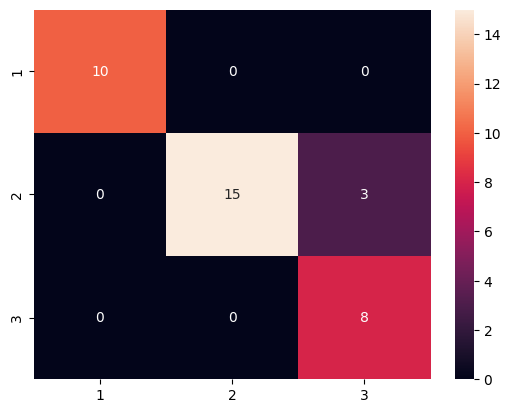



Generating ROC for Test Size = 20%


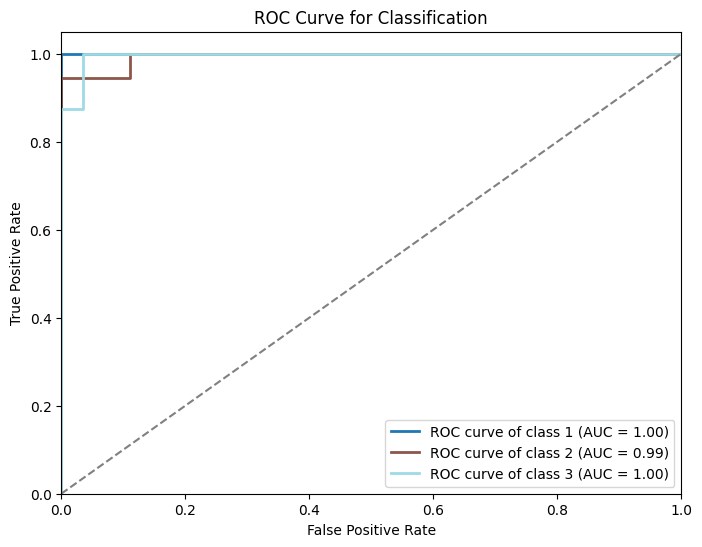

--------------------------------------------------
Performance for Test Size = 30%
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        15
           2       1.00      0.89      0.94        27
           3       0.80      1.00      0.89        12

    accuracy                           0.94        54
   macro avg       0.93      0.96      0.94        54
weighted avg       0.96      0.94      0.95        54

Confusion Matrix:


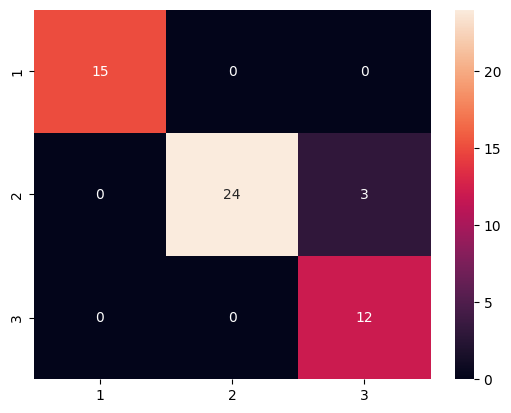



Generating ROC for Test Size = 30%


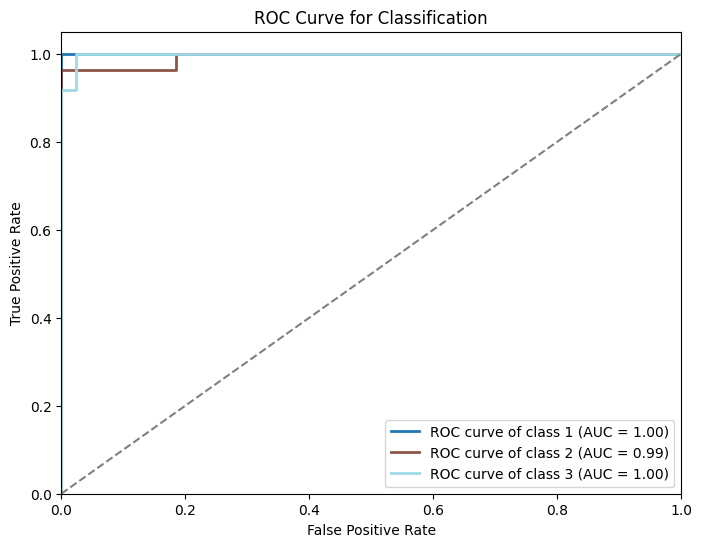

--------------------------------------------------
Performance for Test Size = 40%
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        20
           2       1.00      0.91      0.95        33
           3       0.86      1.00      0.93        19

    accuracy                           0.96        72
   macro avg       0.95      0.97      0.96        72
weighted avg       0.96      0.96      0.96        72

Confusion Matrix:


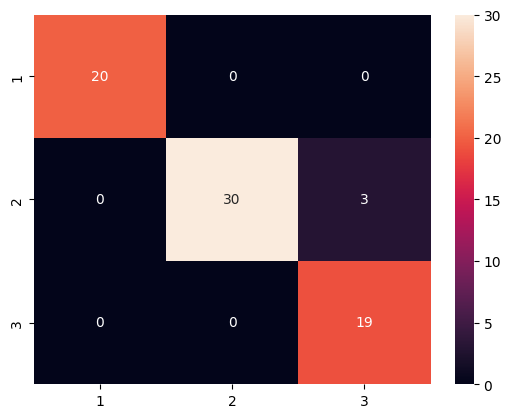



Generating ROC for Test Size = 40%


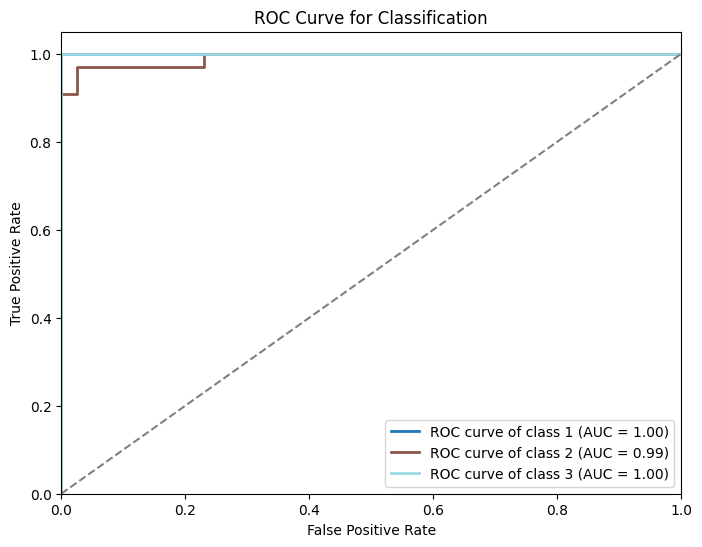

--------------------------------------------------
Performance for Test Size = 50%
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        29
           2       1.00      0.91      0.96        35
           3       0.89      1.00      0.94        25

    accuracy                           0.97        89
   macro avg       0.96      0.97      0.97        89
weighted avg       0.97      0.97      0.97        89

Confusion Matrix:


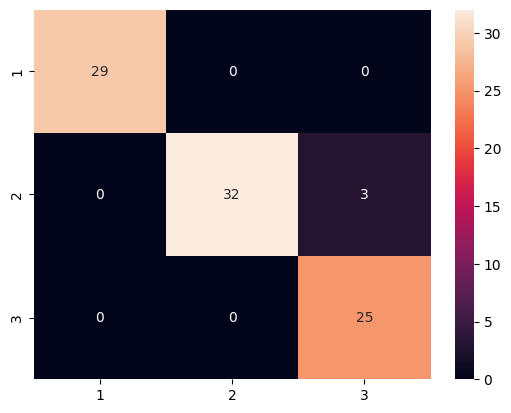



Generating ROC for Test Size = 50%


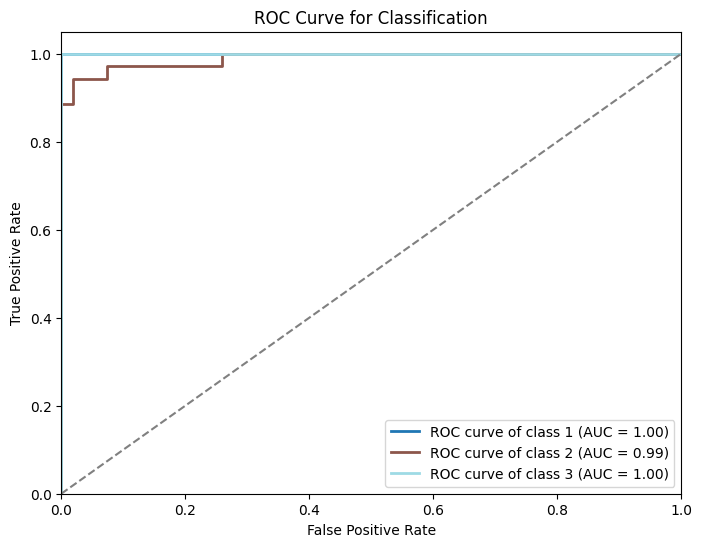

--------------------------------------------------
Summary of Performance across different test sizes
--------------------------------------------------
Got Maximum Accuracy for Test Size =  50 %
Maximum Accuracy =  96.62921348314607 %




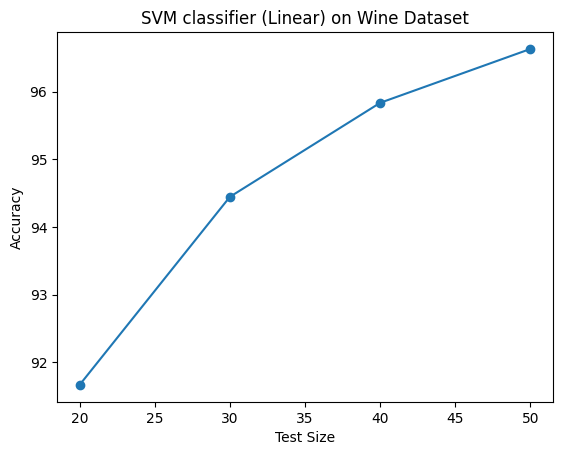

In [12]:
svm_data_wine = []
svm_data_wine.append(performOperation(X, Y.values.ravel(), model=SVC(kernel='linear', probability=True), title="SVM classifier (Linear) on Wine Dataset", scaler=StandardScaler(), sampler=RandomOverSampler()))

SVM classifier (Polynomial) on Wine Dataset
--------------------------------------------------
Performance for Test Size = 20%
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        18
           3       1.00      1.00      1.00         8

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36

Confusion Matrix:


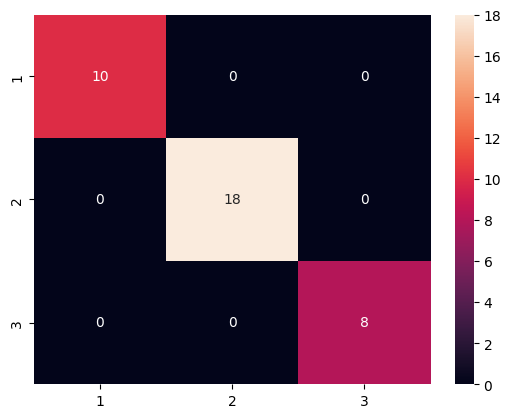



Generating ROC for Test Size = 20%


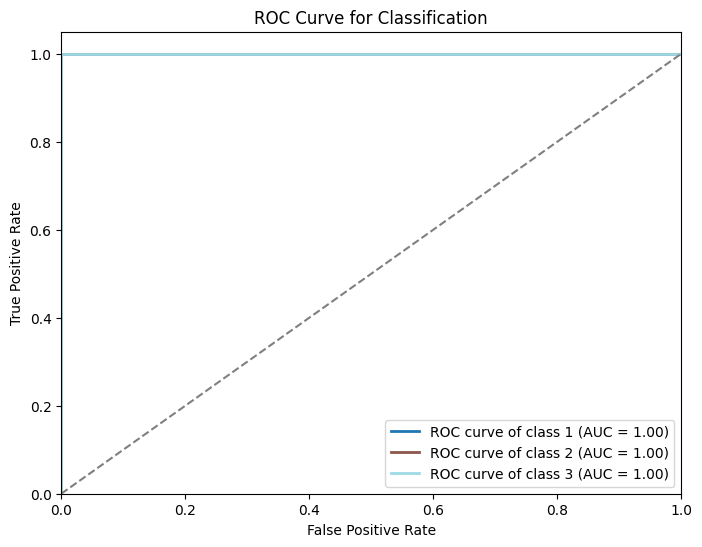

--------------------------------------------------
Performance for Test Size = 30%
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           1       0.87      0.87      0.87        15
           2       0.93      0.93      0.93        27
           3       1.00      1.00      1.00        12

    accuracy                           0.93        54
   macro avg       0.93      0.93      0.93        54
weighted avg       0.93      0.93      0.93        54

Confusion Matrix:


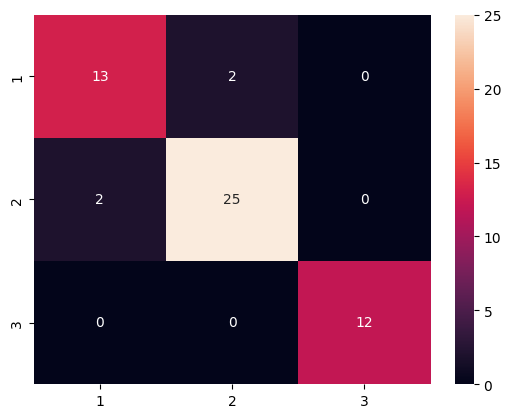



Generating ROC for Test Size = 30%


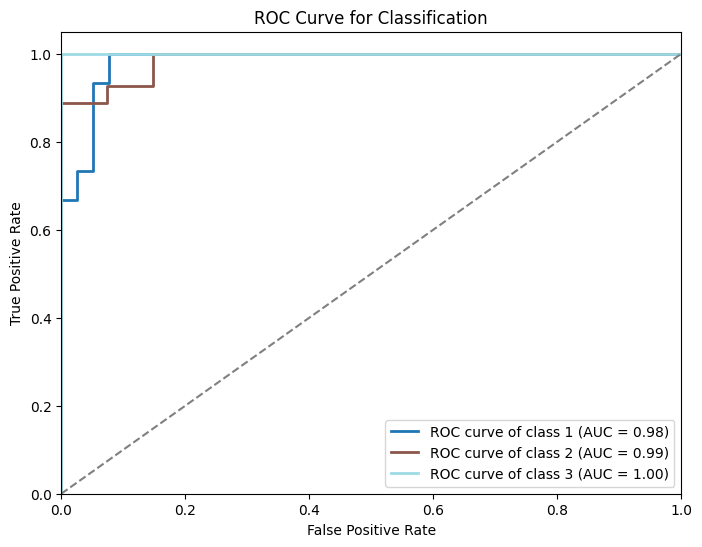

--------------------------------------------------
Performance for Test Size = 40%
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           1       0.89      0.80      0.84        20
           2       0.89      0.94      0.91        33
           3       1.00      1.00      1.00        19

    accuracy                           0.92        72
   macro avg       0.92      0.91      0.92        72
weighted avg       0.92      0.92      0.92        72

Confusion Matrix:


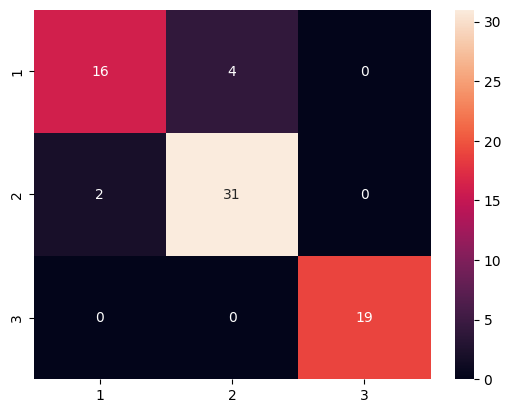



Generating ROC for Test Size = 40%


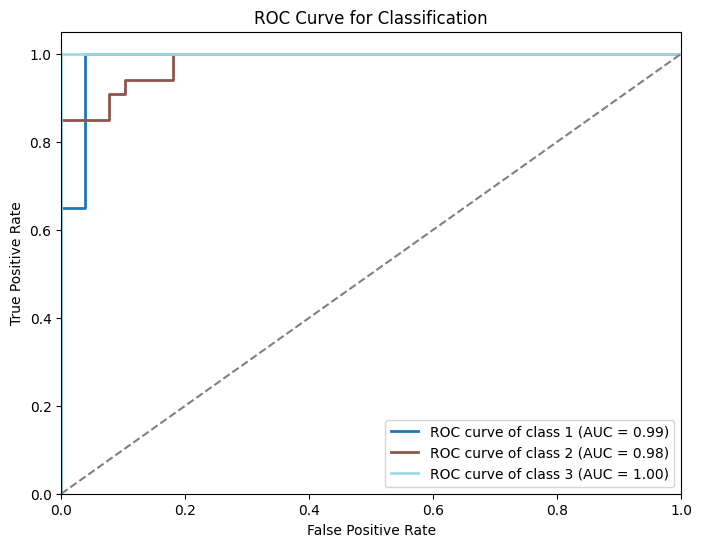

--------------------------------------------------
Performance for Test Size = 50%
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           1       0.91      0.69      0.78        29
           2       0.77      0.94      0.85        35
           3       1.00      0.96      0.98        25

    accuracy                           0.87        89
   macro avg       0.89      0.86      0.87        89
weighted avg       0.88      0.87      0.86        89

Confusion Matrix:


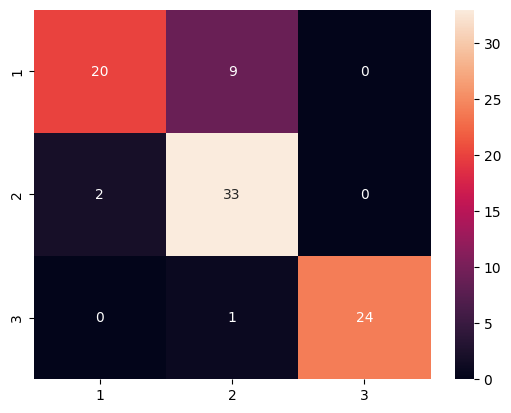



Generating ROC for Test Size = 50%


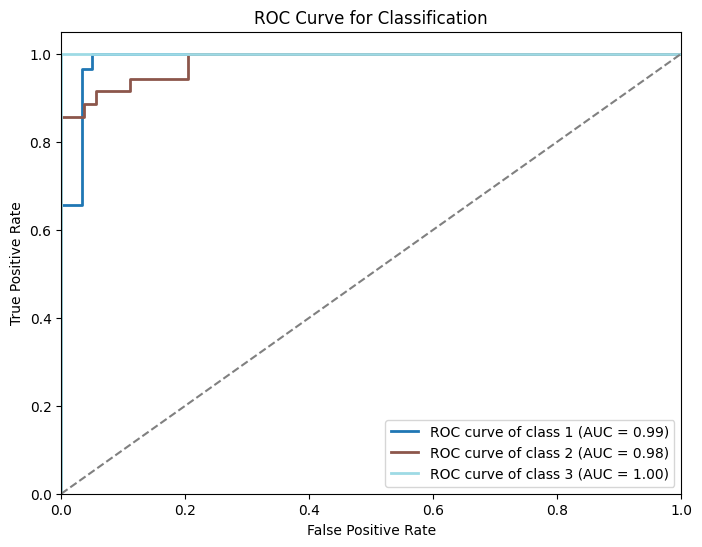

--------------------------------------------------
Summary of Performance across different test sizes
--------------------------------------------------
Got Maximum Accuracy for Test Size =  20 %
Maximum Accuracy =  100.0 %




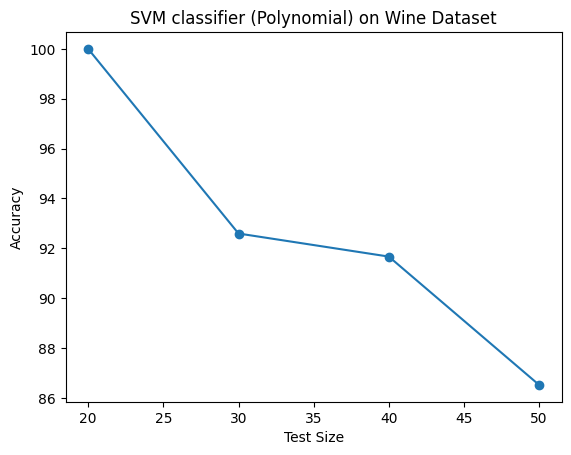

In [13]:
svm_data_wine.append(performOperation(X, Y.values.ravel(), model=SVC(kernel='poly', degree=3 , probability=True), title="SVM classifier (Polynomial) on Wine Dataset", scaler=StandardScaler(), sampler=RandomOverSampler()))

SVM classifier (Sigmoid) on Wine Dataset
--------------------------------------------------
Performance for Test Size = 20%
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        10
           2       1.00      0.78      0.88        18
           3       0.67      1.00      0.80         8

    accuracy                           0.89        36
   macro avg       0.89      0.93      0.89        36
weighted avg       0.93      0.89      0.89        36

Confusion Matrix:


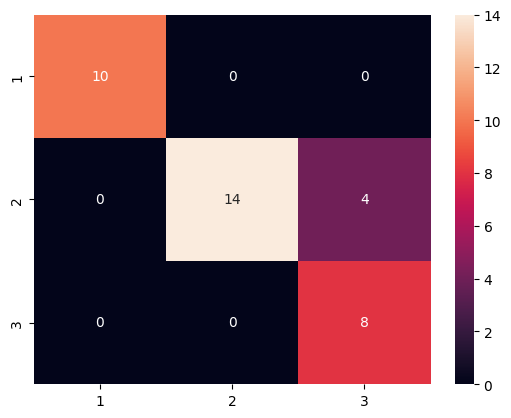



Generating ROC for Test Size = 20%


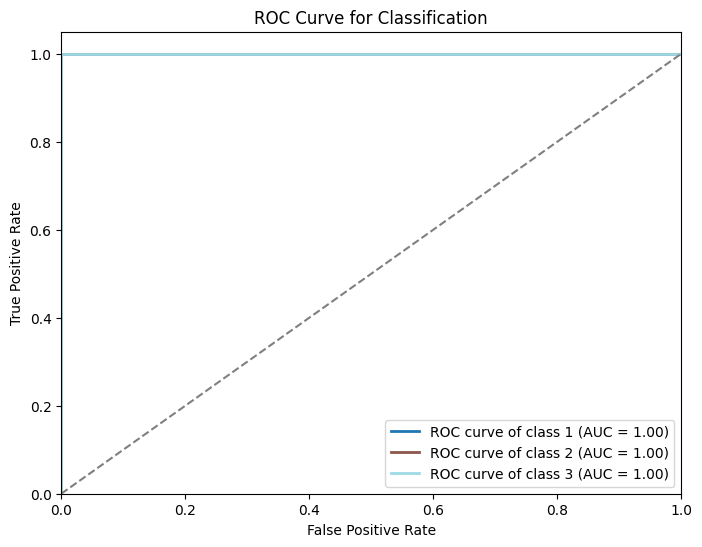

--------------------------------------------------
Performance for Test Size = 30%
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           1       0.94      1.00      0.97        15
           2       1.00      0.85      0.92        27
           3       0.80      1.00      0.89        12

    accuracy                           0.93        54
   macro avg       0.91      0.95      0.93        54
weighted avg       0.94      0.93      0.93        54

Confusion Matrix:


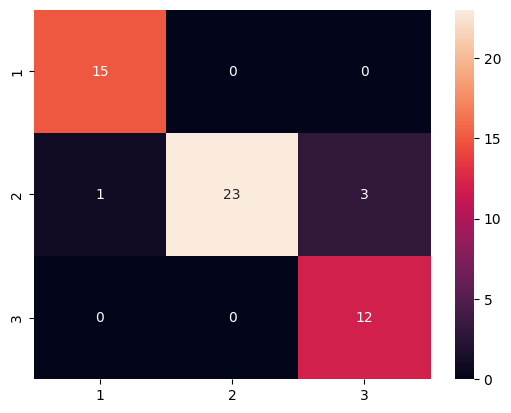



Generating ROC for Test Size = 30%


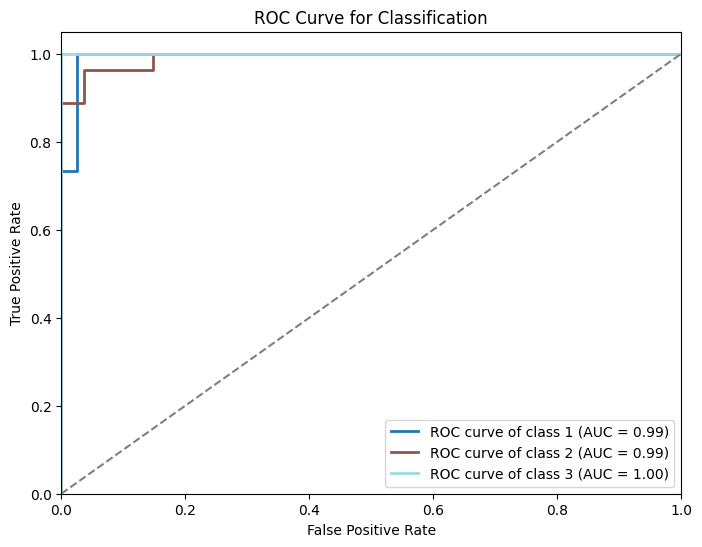

--------------------------------------------------
Performance for Test Size = 40%
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           1       0.95      1.00      0.98        20
           2       1.00      0.85      0.92        33
           3       0.83      1.00      0.90        19

    accuracy                           0.93        72
   macro avg       0.93      0.95      0.93        72
weighted avg       0.94      0.93      0.93        72

Confusion Matrix:


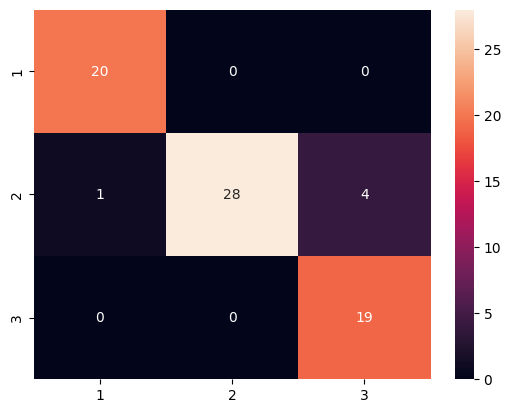



Generating ROC for Test Size = 40%


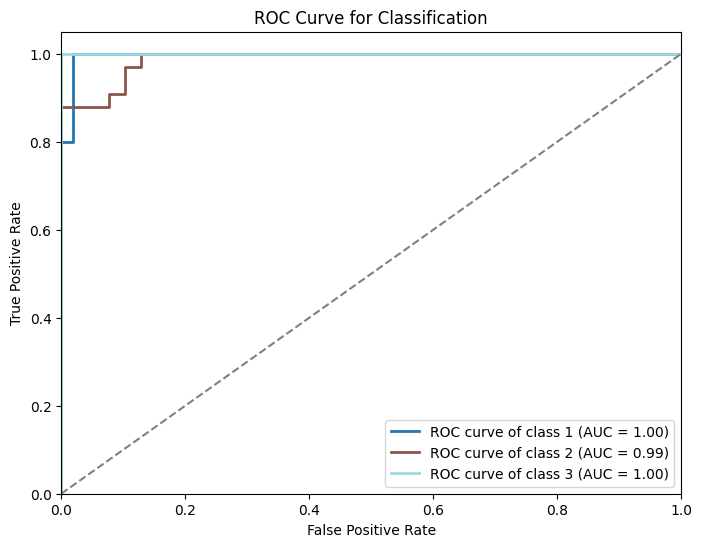

--------------------------------------------------
Performance for Test Size = 50%
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           1       0.97      1.00      0.98        29
           2       1.00      0.89      0.94        35
           3       0.89      1.00      0.94        25

    accuracy                           0.96        89
   macro avg       0.95      0.96      0.96        89
weighted avg       0.96      0.96      0.95        89

Confusion Matrix:


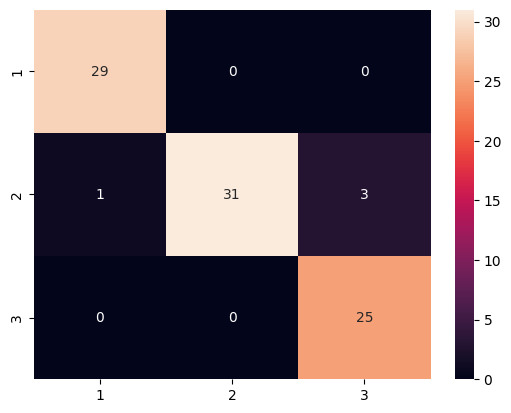



Generating ROC for Test Size = 50%


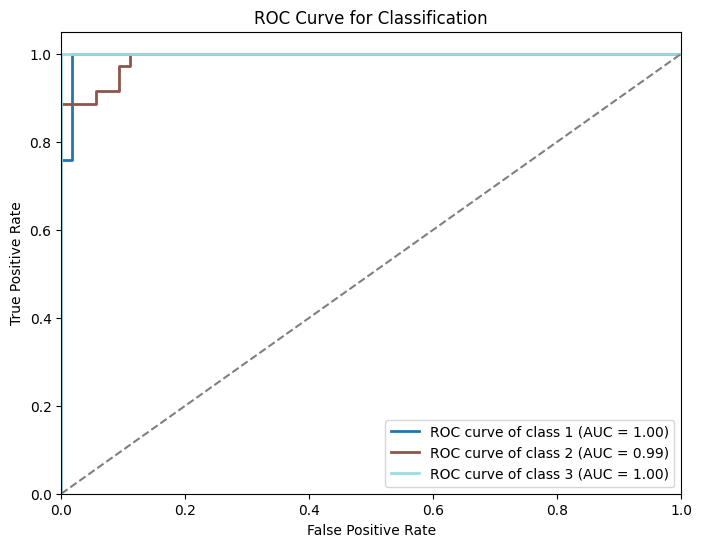

--------------------------------------------------
Summary of Performance across different test sizes
--------------------------------------------------
Got Maximum Accuracy for Test Size =  50 %
Maximum Accuracy =  95.50561797752809 %




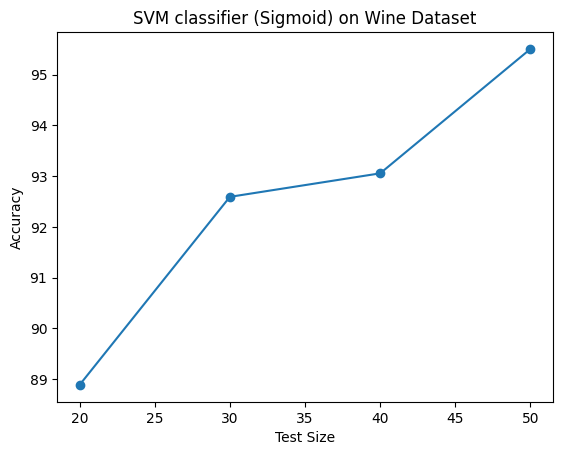

In [14]:
svm_data_wine.append(performOperation(X, Y.values.ravel(), model=SVC(kernel='sigmoid', gamma=0.01, probability=True), title="SVM classifier (Sigmoid) on Wine Dataset", scaler=StandardScaler(), sampler=RandomOverSampler()))

SVM classifier (Gaussian) on Wine Dataset
--------------------------------------------------
Performance for Test Size = 20%
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        10
           2       1.00      0.83      0.91        18
           3       0.73      1.00      0.84         8

    accuracy                           0.92        36
   macro avg       0.91      0.94      0.92        36
weighted avg       0.94      0.92      0.92        36

Confusion Matrix:


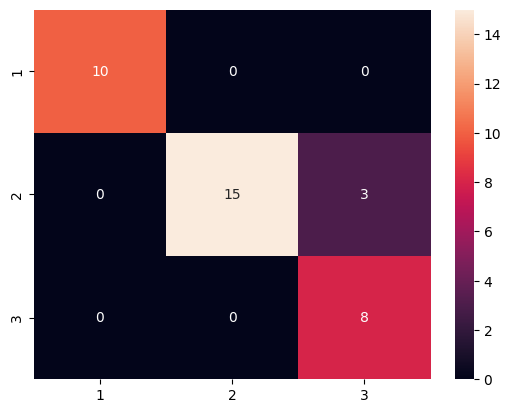



Generating ROC for Test Size = 20%


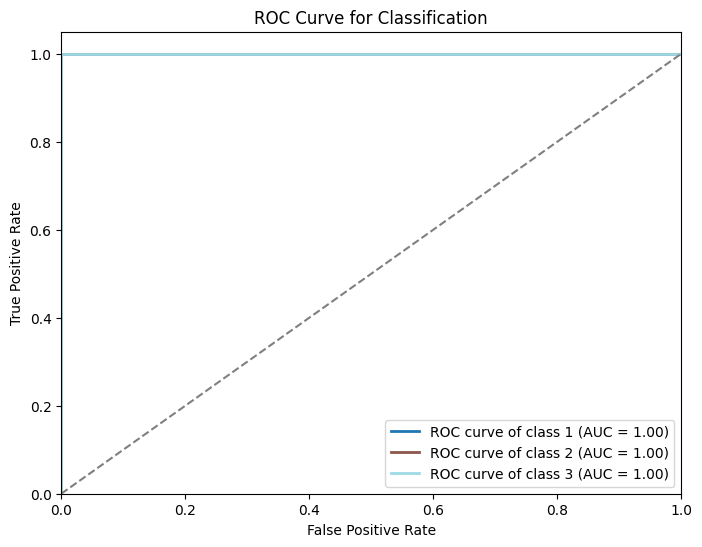

--------------------------------------------------
Performance for Test Size = 30%
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           1       0.94      1.00      0.97        15
           2       1.00      0.85      0.92        27
           3       0.80      1.00      0.89        12

    accuracy                           0.93        54
   macro avg       0.91      0.95      0.93        54
weighted avg       0.94      0.93      0.93        54

Confusion Matrix:


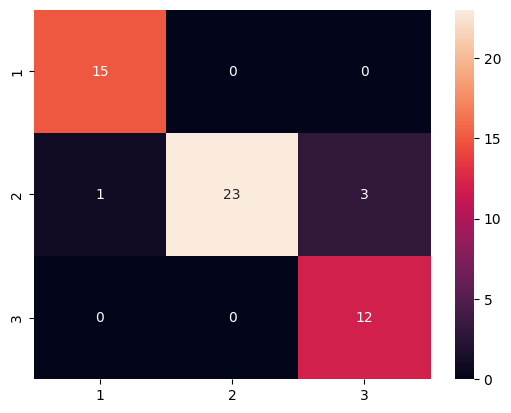



Generating ROC for Test Size = 30%


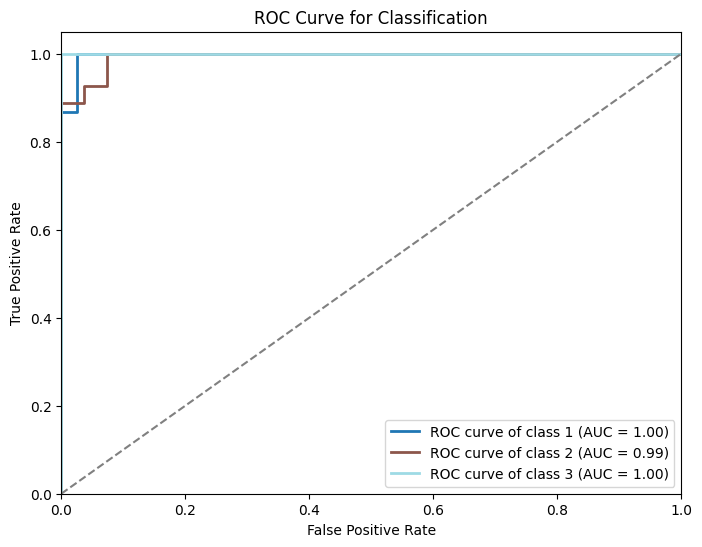

--------------------------------------------------
Performance for Test Size = 40%
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           1       0.95      1.00      0.98        20
           2       1.00      0.88      0.94        33
           3       0.86      1.00      0.93        19

    accuracy                           0.94        72
   macro avg       0.94      0.96      0.95        72
weighted avg       0.95      0.94      0.94        72

Confusion Matrix:


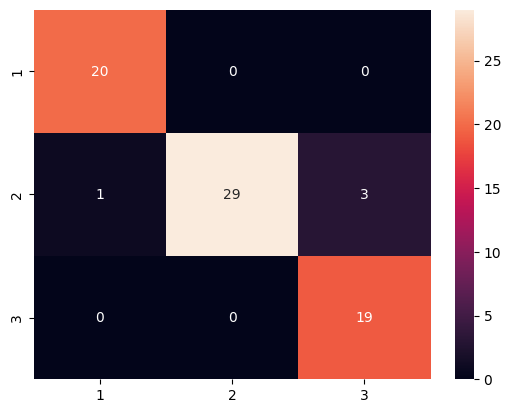



Generating ROC for Test Size = 40%


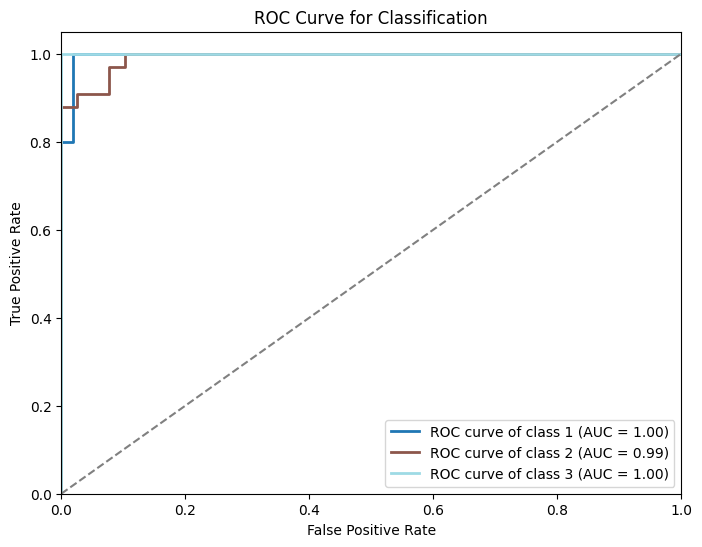

--------------------------------------------------
Performance for Test Size = 50%
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           1       0.97      1.00      0.98        29
           2       1.00      0.86      0.92        35
           3       0.86      1.00      0.93        25

    accuracy                           0.94        89
   macro avg       0.94      0.95      0.94        89
weighted avg       0.95      0.94      0.94        89

Confusion Matrix:


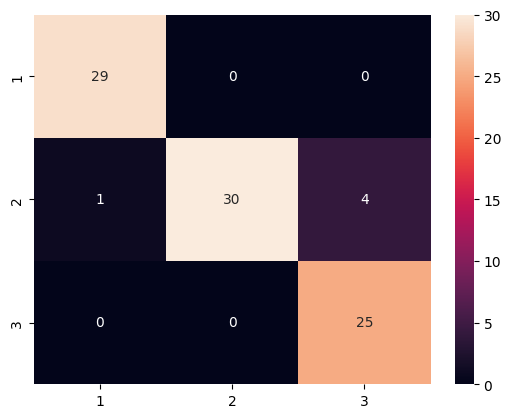



Generating ROC for Test Size = 50%


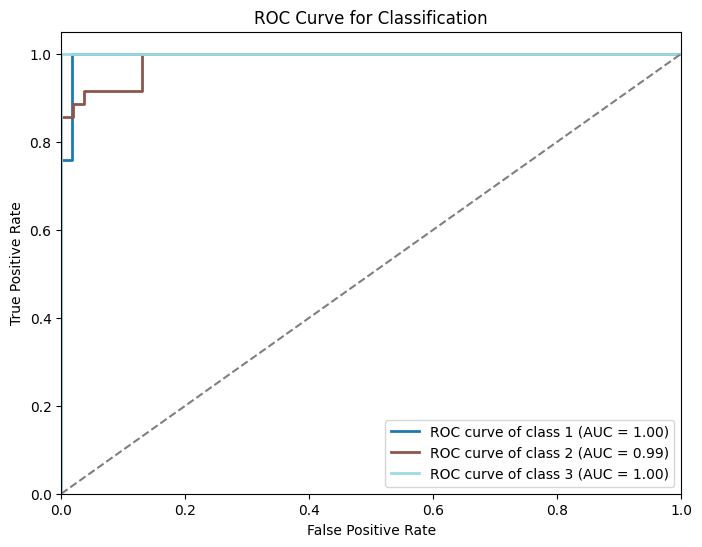

--------------------------------------------------
Summary of Performance across different test sizes
--------------------------------------------------
Got Maximum Accuracy for Test Size =  40 %
Maximum Accuracy =  94.44444444444444 %




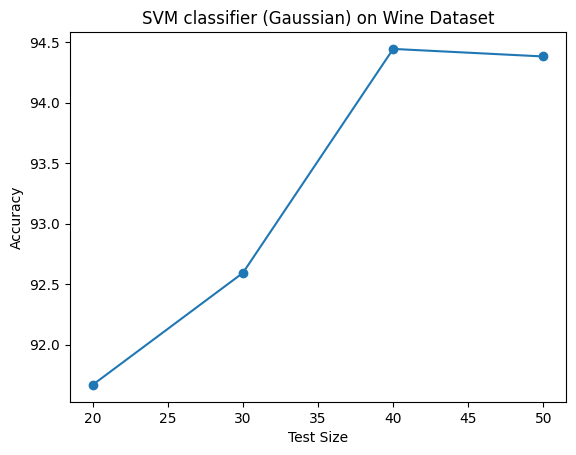

In [15]:
svm_data_wine.append(performOperation(X, Y.values.ravel(), model=SVC(kernel='rbf', C=10, gamma=0.001 ,probability=True), title="SVM classifier (Gaussian) on Wine Dataset", scaler=StandardScaler(), sampler=RandomOverSampler()))

###SVM CLASSIFIER COMPARISION ( WINE DATASET)

In [16]:
columns = [f"Test Size = {ts * 10}%" for ts in range(3, 7)]
table = pd.DataFrame(svm_data_wine,index=["SVM (Linear)", 'SVM (Polynomial)', 'SVM (Sigmoid)', 'SVM (Gaussian)'],columns=columns)
print(table)

                  Test Size = 30%  Test Size = 40%  Test Size = 50%  \
SVM (Linear)            91.666667        94.444444        95.833333   
SVM (Polynomial)       100.000000        92.592593        91.666667   
SVM (Sigmoid)           88.888889        92.592593        93.055556   
SVM (Gaussian)          91.666667        92.592593        94.444444   

                  Test Size = 60%  
SVM (Linear)            96.629213  
SVM (Polynomial)        86.516854  
SVM (Sigmoid)           95.505618  
SVM (Gaussian)          94.382022  


###SVM CLASSIFIER( HANDWRITTEN DIGIT DATASET )

SVM classifier (Linear) on Wine Dataset
--------------------------------------------------
Performance for Test Size = 20%
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       0.95      0.99      0.97       126
           2       0.98      1.00      0.99       114
           3       0.99      0.96      0.98       109
           4       0.98      0.99      0.99       101
           5       1.00      0.99      0.99       100
           6       1.00      0.98      0.99        99
           7       0.99      0.99      0.99       135
           8       1.00      0.97      0.98       120
           9       0.97      0.98      0.97       115

    accuracy                           0.99      1124
   macro avg       0.99      0.99      0.99      1124
weighted avg       0.99      0.99      0.99      1124

Confusion Matrix:


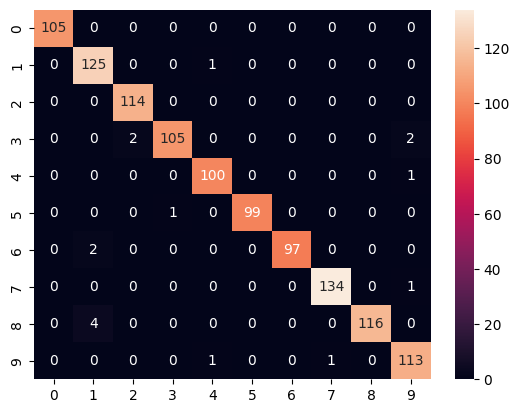



Generating ROC for Test Size = 20%


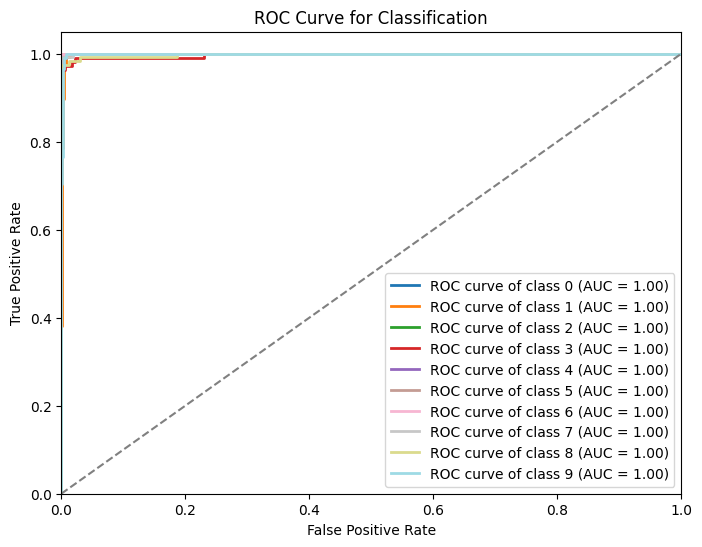

--------------------------------------------------
Performance for Test Size = 30%
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       171
           1       0.95      0.98      0.97       192
           2       0.98      1.00      0.99       173
           3       0.96      0.97      0.97       179
           4       0.95      0.99      0.97       147
           5       1.00      0.97      0.99       158
           6       1.00      0.97      0.99       145
           7       0.99      0.98      0.99       186
           8       0.97      0.95      0.96       169
           9       0.96      0.93      0.95       167

    accuracy                           0.98      1687
   macro avg       0.98      0.98      0.98      1687
weighted avg       0.98      0.98      0.98      1687

Confusion Matrix:


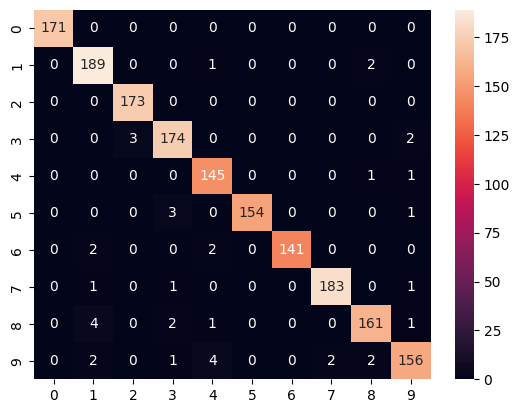



Generating ROC for Test Size = 30%


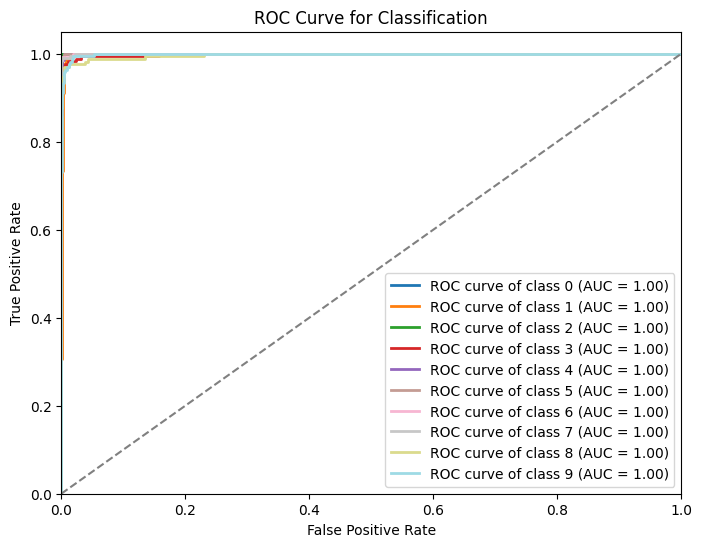

--------------------------------------------------
Performance for Test Size = 40%
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       215
           1       0.95      0.97      0.96       249
           2       1.00      1.00      1.00       225
           3       0.95      0.98      0.96       220
           4       0.95      1.00      0.97       201
           5       1.00      0.98      0.99       219
           6       1.00      0.98      0.99       215
           7       0.99      0.98      0.99       249
           8       0.99      0.91      0.95       241
           9       0.93      0.95      0.94       214

    accuracy                           0.97      2248
   macro avg       0.97      0.97      0.97      2248
weighted avg       0.97      0.97      0.97      2248

Confusion Matrix:


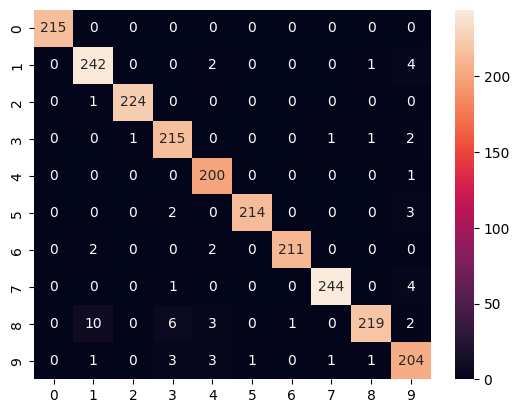



Generating ROC for Test Size = 40%


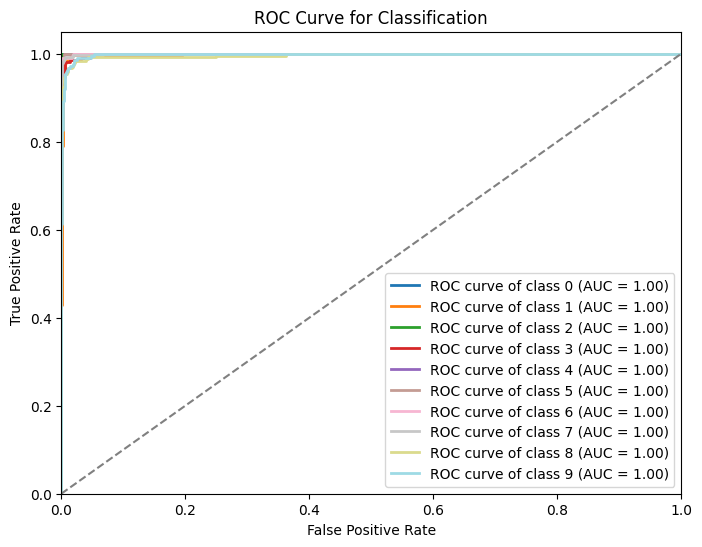

--------------------------------------------------
Performance for Test Size = 50%
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       263
           1       0.96      0.96      0.96       309
           2       0.98      1.00      0.99       273
           3       0.97      0.98      0.97       293
           4       0.97      0.99      0.98       268
           5       0.99      0.97      0.98       266
           6       0.98      0.99      0.98       270
           7       0.99      0.97      0.98       307
           8       0.97      0.93      0.95       289
           9       0.93      0.95      0.94       272

    accuracy                           0.97      2810
   macro avg       0.97      0.97      0.97      2810
weighted avg       0.97      0.97      0.97      2810

Confusion Matrix:


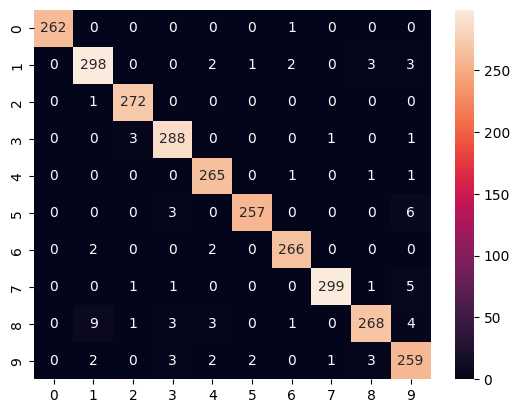



Generating ROC for Test Size = 50%


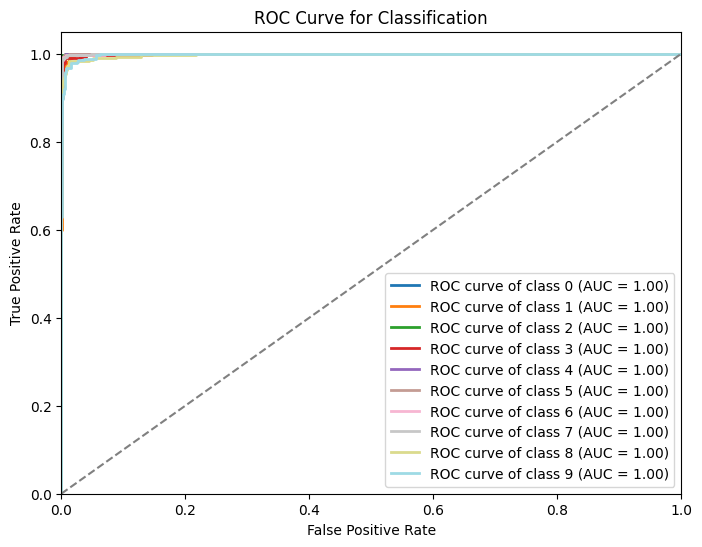

--------------------------------------------------
Summary of Performance across different test sizes
--------------------------------------------------
Got Maximum Accuracy for Test Size =  20 %
Maximum Accuracy =  98.57651245551602 %




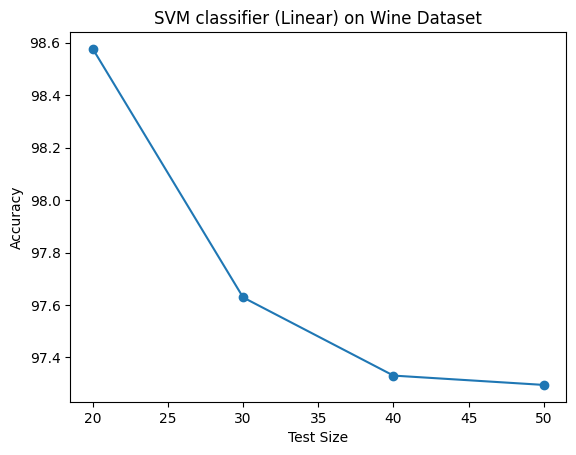

In [17]:
svm_data_HD = []
svm_data_HD.append(performOperation(x, y.values.ravel(), model=SVC(kernel='linear',probability=True), title="SVM classifier (Linear) on Wine Dataset", scaler=StandardScaler(), sampler=RandomOverSampler()))

SVM classifier (Polynomial) on Wine Dataset
--------------------------------------------------
Performance for Test Size = 20%
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       105
           1       0.98      0.97      0.97       126
           2       0.99      0.98      0.99       114
           3       1.00      0.94      0.97       109
           4       1.00      0.97      0.98       101
           5       1.00      1.00      1.00       100
           6       1.00      0.98      0.99        99
           7       1.00      0.98      0.99       135
           8       0.88      0.99      0.93       120
           9       0.95      0.97      0.96       115

    accuracy                           0.98      1124
   macro avg       0.98      0.98      0.98      1124
weighted avg       0.98      0.98      0.98      1124

Confusion Matrix:


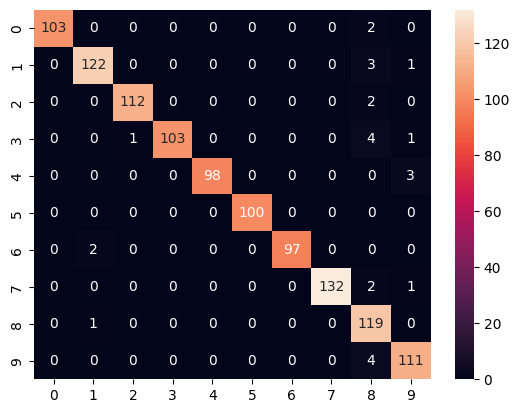



Generating ROC for Test Size = 20%


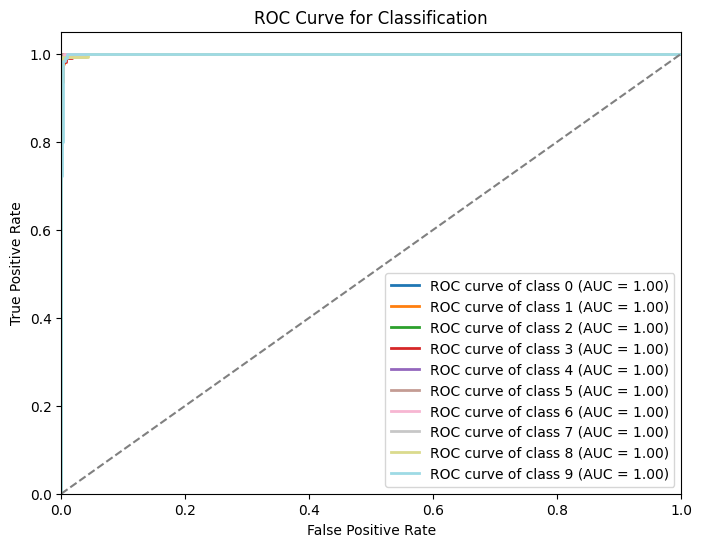

--------------------------------------------------
Performance for Test Size = 30%
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       171
           1       0.97      0.96      0.97       192
           2       0.98      0.97      0.98       173
           3       0.99      0.97      0.98       179
           4       0.99      0.98      0.99       147
           5       1.00      0.99      1.00       158
           6       1.00      0.99      0.99       145
           7       0.98      0.97      0.98       186
           8       0.86      0.98      0.92       169
           9       0.96      0.93      0.94       167

    accuracy                           0.97      1687
   macro avg       0.97      0.97      0.97      1687
weighted avg       0.97      0.97      0.97      1687

Confusion Matrix:


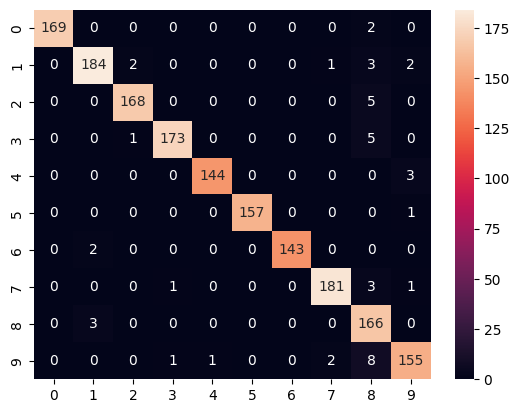



Generating ROC for Test Size = 30%


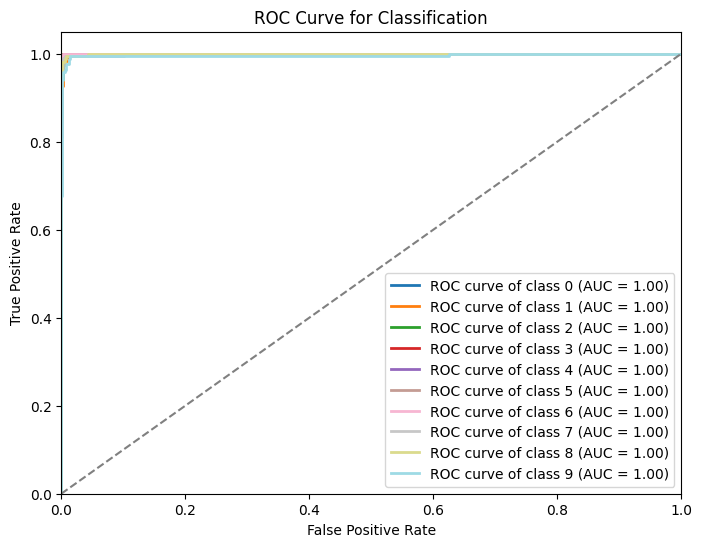

--------------------------------------------------
Performance for Test Size = 40%
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       215
           1       0.97      0.96      0.97       249
           2       0.99      0.97      0.98       225
           3       0.99      0.95      0.97       220
           4       0.99      0.98      0.99       201
           5       1.00      1.00      1.00       219
           6       1.00      0.99      0.99       215
           7       0.98      0.97      0.98       249
           8       0.86      0.98      0.91       241
           9       0.95      0.92      0.93       214

    accuracy                           0.97      2248
   macro avg       0.97      0.97      0.97      2248
weighted avg       0.97      0.97      0.97      2248

Confusion Matrix:


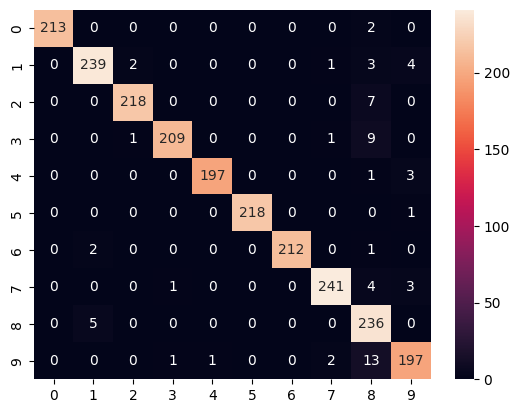



Generating ROC for Test Size = 40%


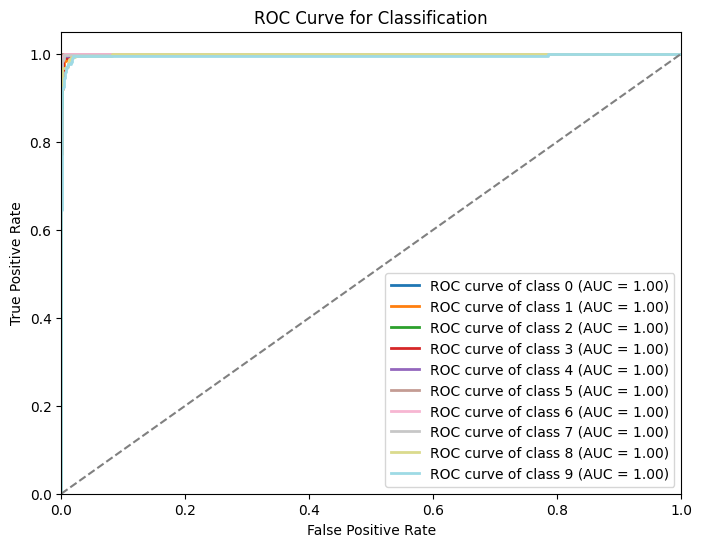

--------------------------------------------------
Performance for Test Size = 50%
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       263
           1       0.98      0.96      0.97       309
           2       0.99      0.96      0.97       273
           3       0.99      0.94      0.97       293
           4       0.99      0.99      0.99       268
           5       0.99      0.99      0.99       266
           6       1.00      0.99      0.99       270
           7       0.99      0.97      0.98       307
           8       0.85      0.98      0.91       289
           9       0.94      0.93      0.93       272

    accuracy                           0.97      2810
   macro avg       0.97      0.97      0.97      2810
weighted avg       0.97      0.97      0.97      2810

Confusion Matrix:


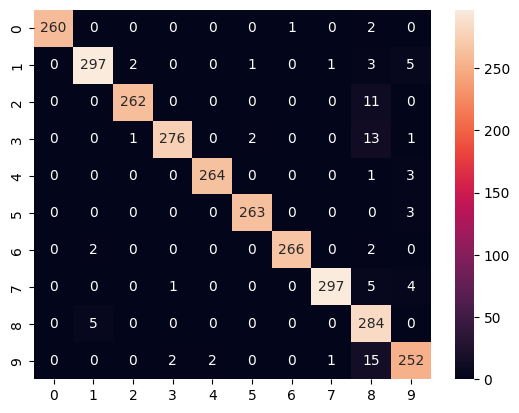



Generating ROC for Test Size = 50%


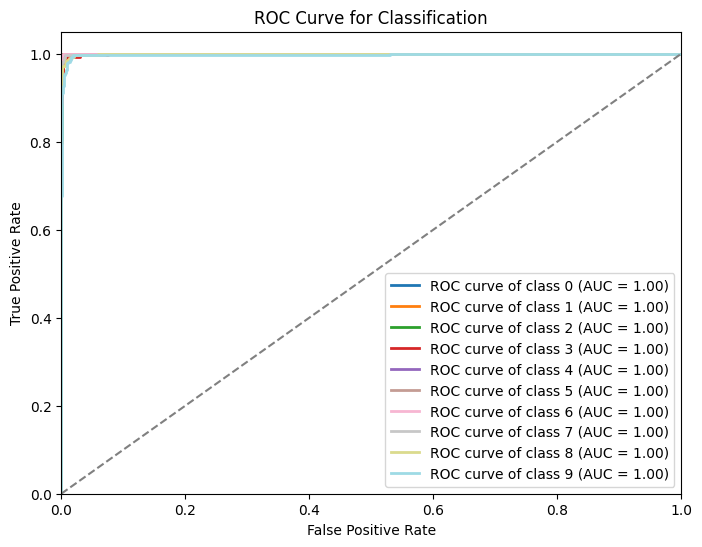

--------------------------------------------------
Summary of Performance across different test sizes
--------------------------------------------------
Got Maximum Accuracy for Test Size =  20 %
Maximum Accuracy =  97.59786476868328 %




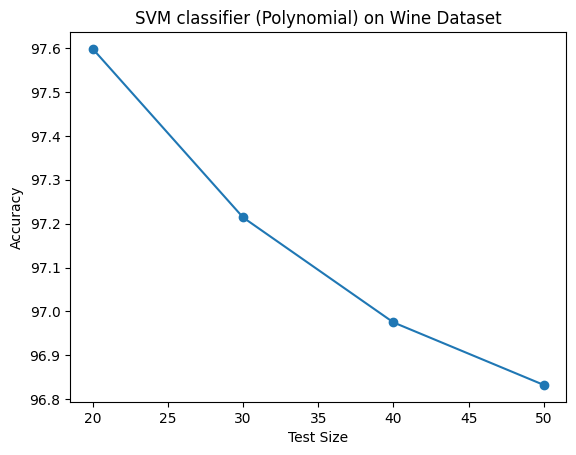

In [18]:
svm_data_HD.append(performOperation(x, y.values.ravel(), model=SVC(kernel='poly', degree=3 , probability=True), title="SVM classifier (Polynomial) on Wine Dataset", scaler=StandardScaler(), sampler=RandomOverSampler()))

SVM classifier (Sigmoid) on Wine Dataset
--------------------------------------------------
Performance for Test Size = 20%
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        10
           2       1.00      0.83      0.91        18
           3       0.73      1.00      0.84         8

    accuracy                           0.92        36
   macro avg       0.91      0.94      0.92        36
weighted avg       0.94      0.92      0.92        36

Confusion Matrix:


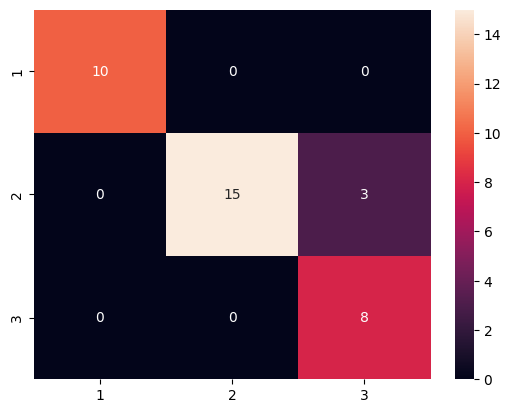



Generating ROC for Test Size = 20%


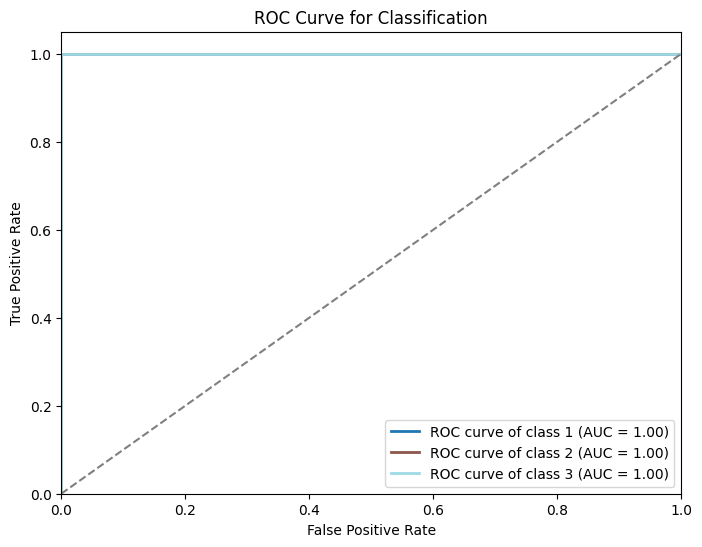

--------------------------------------------------
Performance for Test Size = 30%
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           1       0.94      1.00      0.97        15
           2       1.00      0.85      0.92        27
           3       0.80      1.00      0.89        12

    accuracy                           0.93        54
   macro avg       0.91      0.95      0.93        54
weighted avg       0.94      0.93      0.93        54

Confusion Matrix:


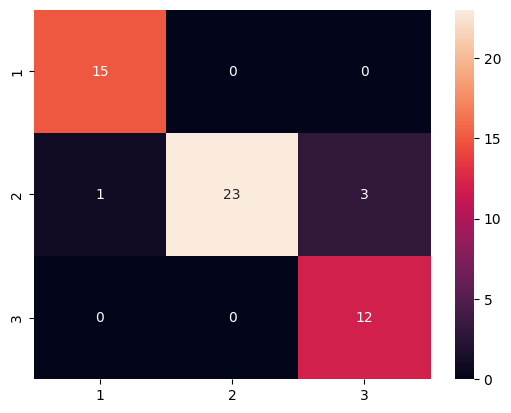



Generating ROC for Test Size = 30%


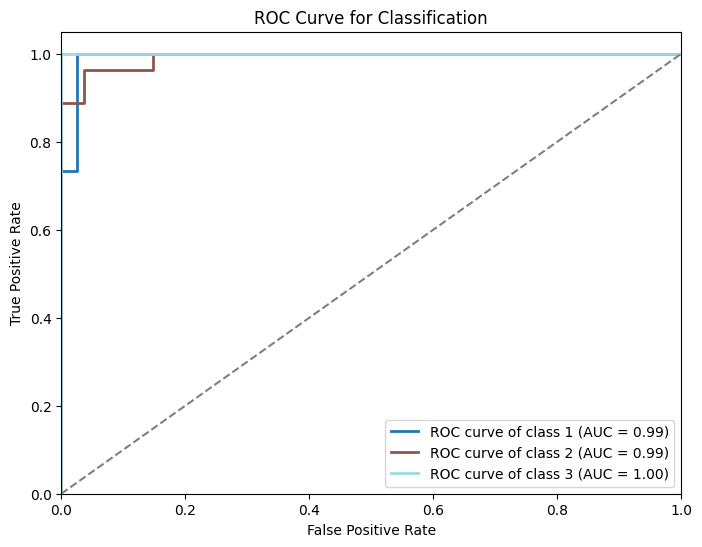

--------------------------------------------------
Performance for Test Size = 40%
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           1       0.95      1.00      0.98        20
           2       1.00      0.85      0.92        33
           3       0.83      1.00      0.90        19

    accuracy                           0.93        72
   macro avg       0.93      0.95      0.93        72
weighted avg       0.94      0.93      0.93        72

Confusion Matrix:


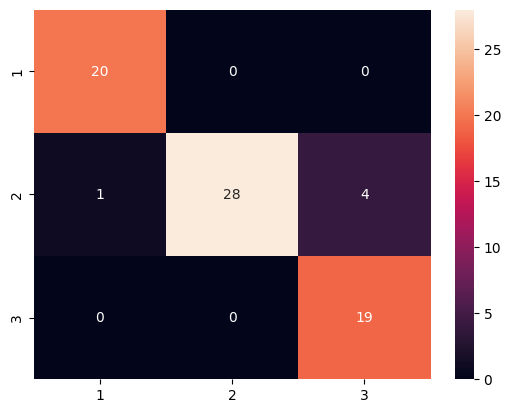



Generating ROC for Test Size = 40%


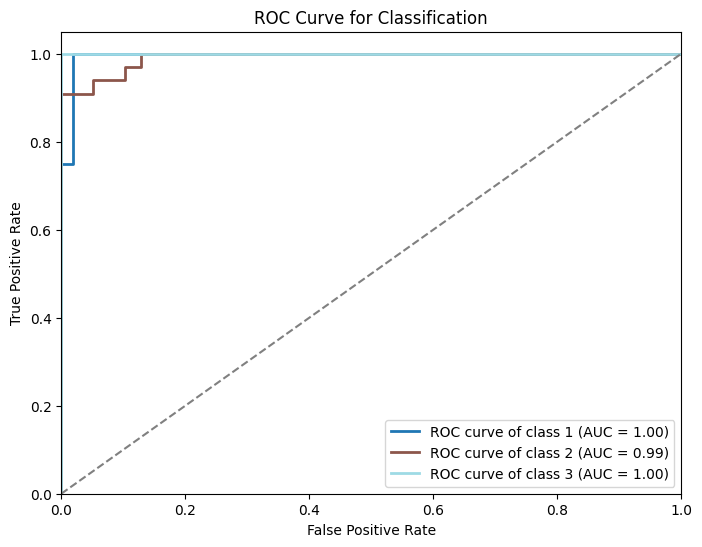

--------------------------------------------------
Performance for Test Size = 50%
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           1       0.97      1.00      0.98        29
           2       1.00      0.83      0.91        35
           3       0.83      1.00      0.91        25

    accuracy                           0.93        89
   macro avg       0.93      0.94      0.93        89
weighted avg       0.94      0.93      0.93        89

Confusion Matrix:


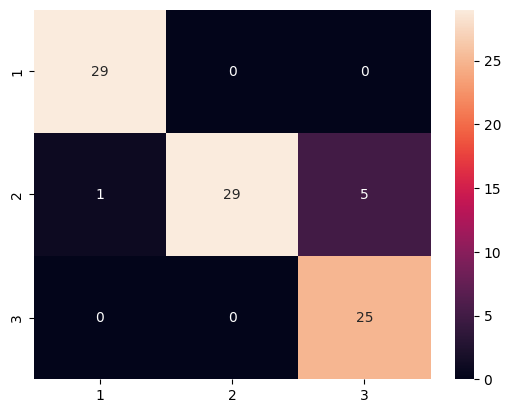



Generating ROC for Test Size = 50%


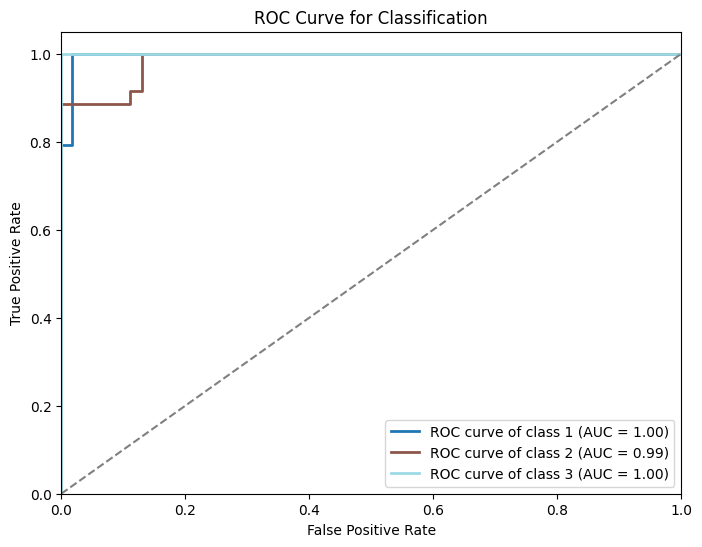

--------------------------------------------------
Summary of Performance across different test sizes
--------------------------------------------------
Got Maximum Accuracy for Test Size =  50 %
Maximum Accuracy =  93.25842696629213 %




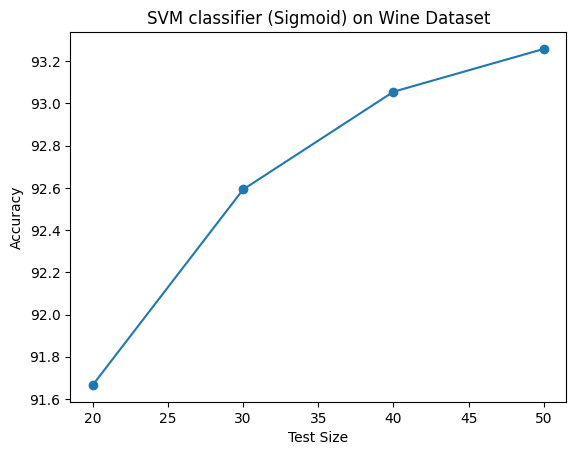

In [19]:
svm_data_HD.append(performOperation(X, Y.values.ravel(), model=SVC(kernel='sigmoid', gamma=0.01, probability=True), title="SVM classifier (Sigmoid) on Wine Dataset", scaler=StandardScaler(), sampler=RandomOverSampler()))

SVM classifier (Gaussian) on Wine Dataset
--------------------------------------------------
Performance for Test Size = 20%
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       0.95      0.98      0.97       126
           2       0.98      1.00      0.99       114
           3       1.00      0.94      0.97       109
           4       0.96      0.98      0.97       101
           5       1.00      0.99      0.99       100
           6       0.99      0.98      0.98        99
           7       0.99      0.99      0.99       135
           8       0.98      0.95      0.97       120
           9       0.95      0.98      0.97       115

    accuracy                           0.98      1124
   macro avg       0.98      0.98      0.98      1124
weighted avg       0.98      0.98      0.98      1124

Confusion Matrix:


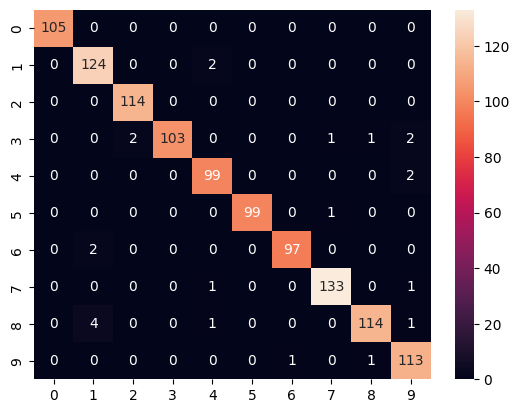



Generating ROC for Test Size = 20%


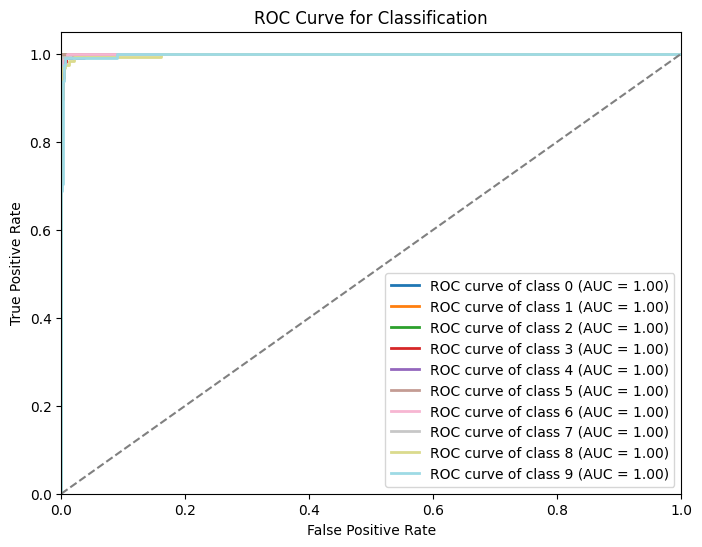

--------------------------------------------------
Performance for Test Size = 30%
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       171
           1       0.95      0.97      0.96       192
           2       0.98      1.00      0.99       173
           3       0.99      0.96      0.97       179
           4       0.95      0.99      0.97       147
           5       0.99      0.99      0.99       158
           6       0.99      0.98      0.99       145
           7       0.97      0.98      0.98       186
           8       0.99      0.95      0.97       169
           9       0.95      0.96      0.95       167

    accuracy                           0.98      1687
   macro avg       0.98      0.98      0.98      1687
weighted avg       0.98      0.98      0.98      1687

Confusion Matrix:


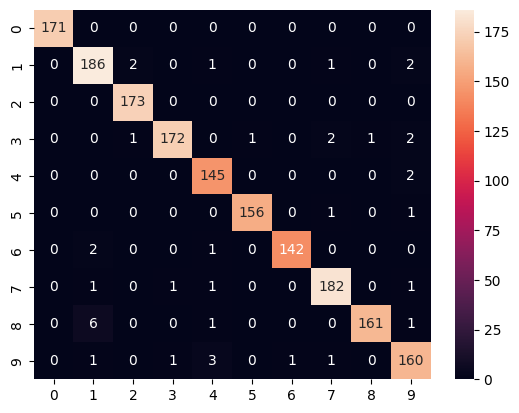



Generating ROC for Test Size = 30%


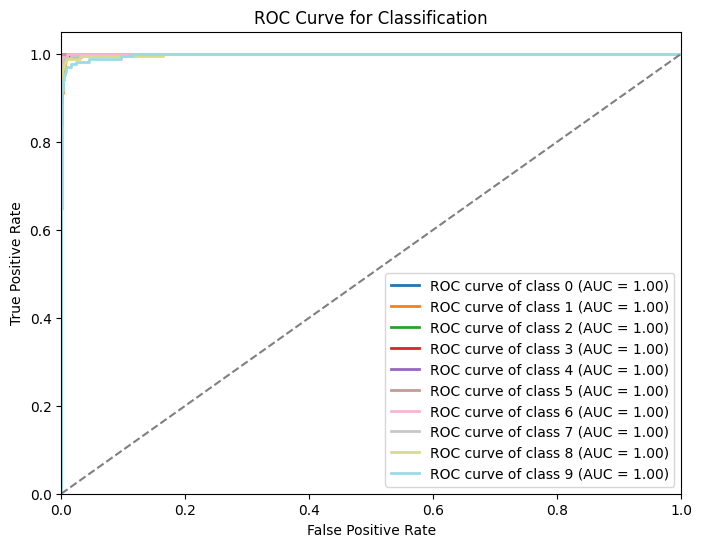

--------------------------------------------------
Performance for Test Size = 40%
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       215
           1       0.95      0.96      0.96       249
           2       0.98      1.00      0.99       225
           3       0.98      0.96      0.97       220
           4       0.96      0.99      0.97       201
           5       1.00      0.99      0.99       219
           6       1.00      0.99      0.99       215
           7       0.98      0.98      0.98       249
           8       0.98      0.95      0.96       241
           9       0.94      0.95      0.95       214

    accuracy                           0.98      2248
   macro avg       0.98      0.98      0.98      2248
weighted avg       0.98      0.98      0.98      2248

Confusion Matrix:


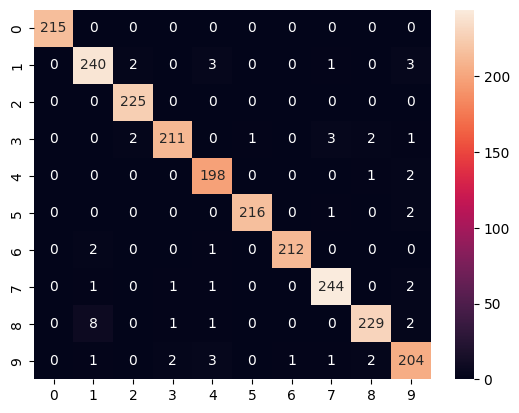



Generating ROC for Test Size = 40%


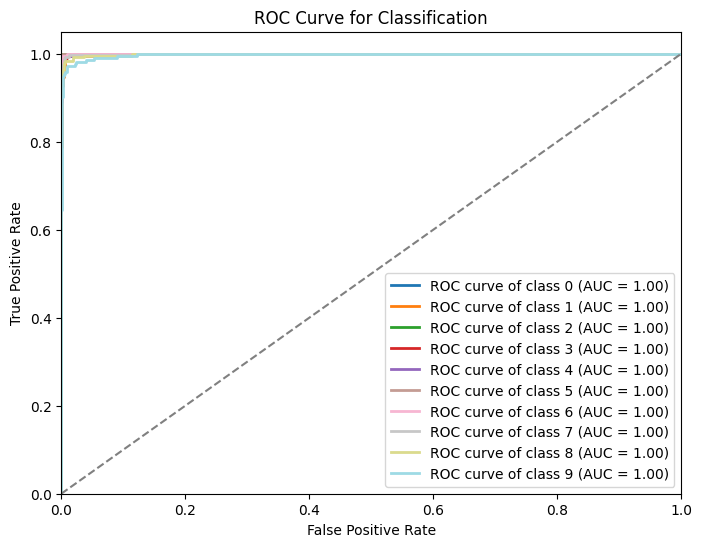

--------------------------------------------------
Performance for Test Size = 50%
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       263
           1       0.97      0.97      0.97       309
           2       0.99      1.00      0.99       273
           3       0.98      0.96      0.97       293
           4       0.96      0.99      0.97       268
           5       0.99      0.98      0.98       266
           6       0.99      0.99      0.99       270
           7       0.97      0.98      0.97       307
           8       0.97      0.96      0.96       289
           9       0.95      0.95      0.95       272

    accuracy                           0.98      2810
   macro avg       0.98      0.98      0.98      2810
weighted avg       0.98      0.98      0.98      2810

Confusion Matrix:


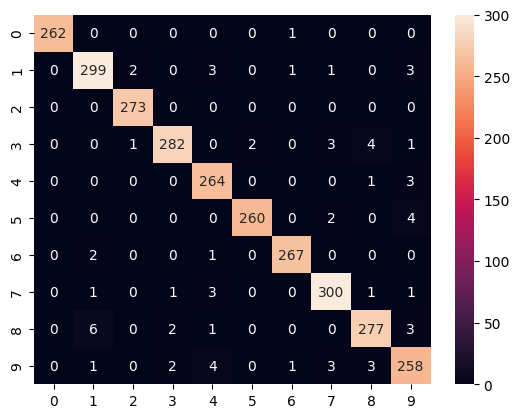



Generating ROC for Test Size = 50%


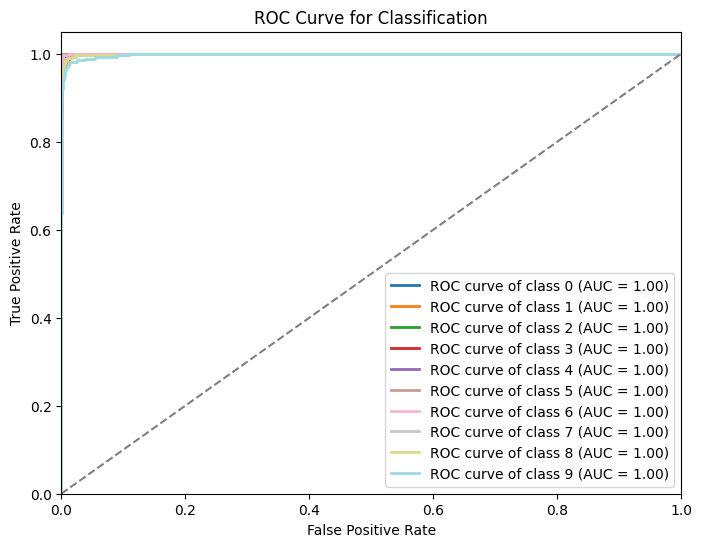

--------------------------------------------------
Summary of Performance across different test sizes
--------------------------------------------------
Got Maximum Accuracy for Test Size =  20 %
Maximum Accuracy =  97.95373665480427 %




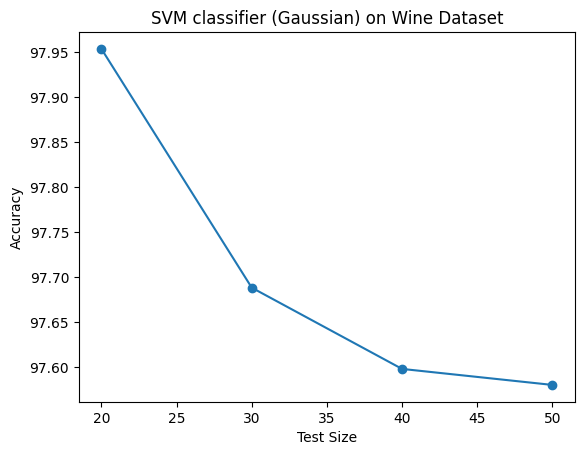

In [20]:
svm_data_HD.append(performOperation(x, y.values.ravel(), model=SVC(kernel='rbf', C=0.5, gamma=0.01 , probability=True), title="SVM classifier (Gaussian) on Wine Dataset", scaler=StandardScaler(), sampler=RandomOverSampler()))

###SVM CLASSIFIER COMPARISION ( HANDWRITTEN DIGIT DATASET )

In [21]:
columns = [f"Test Size = {ts * 10}%" for ts in range(3, 7)]
table = pd.DataFrame(svm_data_HD,index=["SVM (Linear)", 'SVM (Polynomial)', 'SVM (Sigmoid)', 'SVM (Gaussian)'],columns=columns)
print(table)

                  Test Size = 30%  Test Size = 40%  Test Size = 50%  \
SVM (Linear)            98.576512        97.628927        97.330961   
SVM (Polynomial)        97.597865        97.213989        96.975089   
SVM (Sigmoid)           91.666667        92.592593        93.055556   
SVM (Gaussian)          97.953737        97.688204        97.597865   

                  Test Size = 60%  
SVM (Linear)            97.295374  
SVM (Polynomial)        96.832740  
SVM (Sigmoid)           93.258427  
SVM (Gaussian)          97.580071  


###MLP CLASSIFIER ( WINE DATASET )

MLP Classifier
--------------------------------------------------
Performance for Test Size = 20%
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        10
           2       1.00      0.89      0.94        18
           3       0.80      1.00      0.89         8

    accuracy                           0.94        36
   macro avg       0.93      0.96      0.94        36
weighted avg       0.96      0.94      0.95        36

Confusion Matrix:


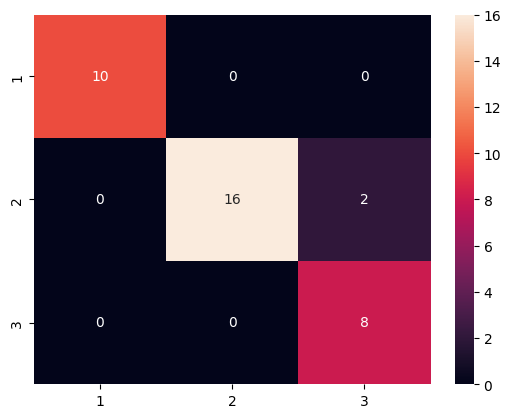



Generating ROC for Test Size = 20%


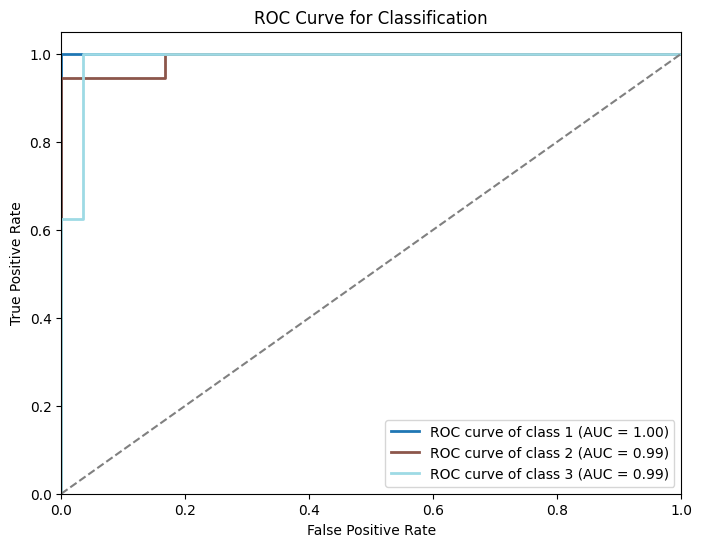

--------------------------------------------------
Performance for Test Size = 30%
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        15
           2       1.00      0.93      0.96        27
           3       0.86      1.00      0.92        12

    accuracy                           0.96        54
   macro avg       0.95      0.98      0.96        54
weighted avg       0.97      0.96      0.96        54

Confusion Matrix:


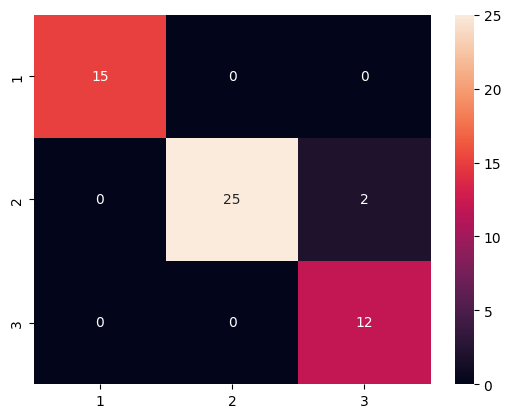



Generating ROC for Test Size = 30%


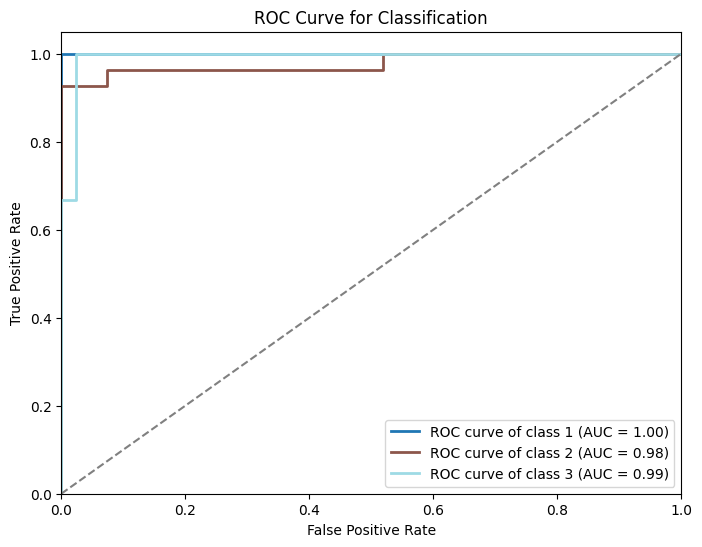

--------------------------------------------------
Performance for Test Size = 40%
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           1       0.86      0.95      0.90        20
           2       0.97      0.85      0.90        33
           3       0.90      1.00      0.95        19

    accuracy                           0.92        72
   macro avg       0.91      0.93      0.92        72
weighted avg       0.92      0.92      0.92        72

Confusion Matrix:


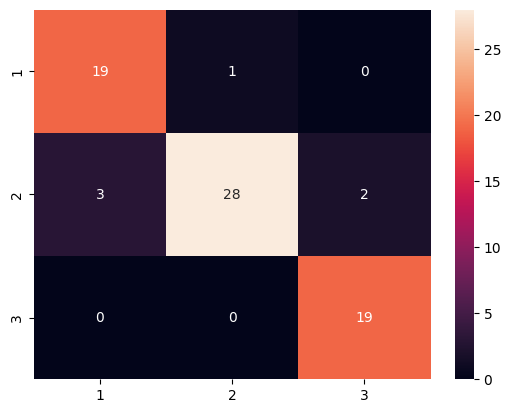



Generating ROC for Test Size = 40%


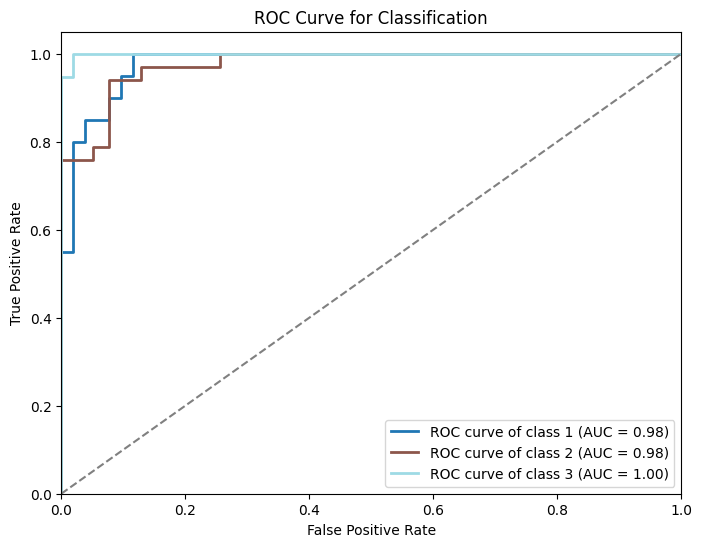

--------------------------------------------------
Performance for Test Size = 50%
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.97      0.98        29
           2       0.97      0.94      0.96        35
           3       0.93      1.00      0.96        25

    accuracy                           0.97        89
   macro avg       0.97      0.97      0.97        89
weighted avg       0.97      0.97      0.97        89

Confusion Matrix:


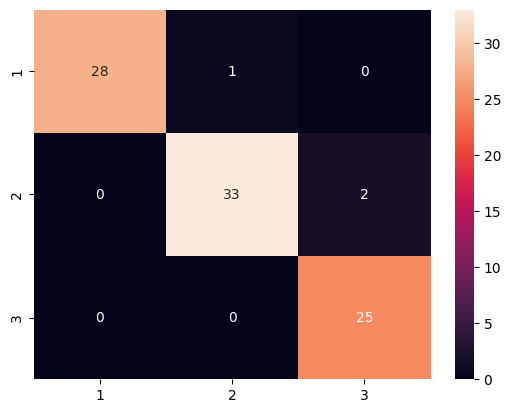



Generating ROC for Test Size = 50%


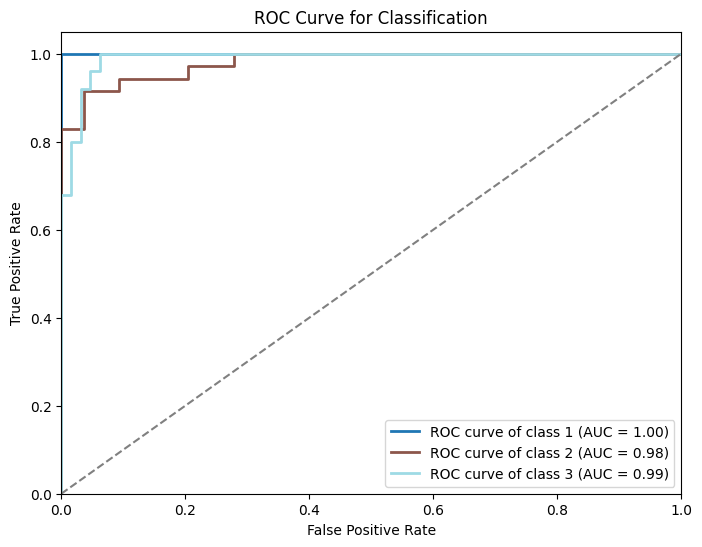

--------------------------------------------------
Summary of Performance across different test sizes
--------------------------------------------------
Got Maximum Accuracy for Test Size =  50 %
Maximum Accuracy =  96.62921348314607 %




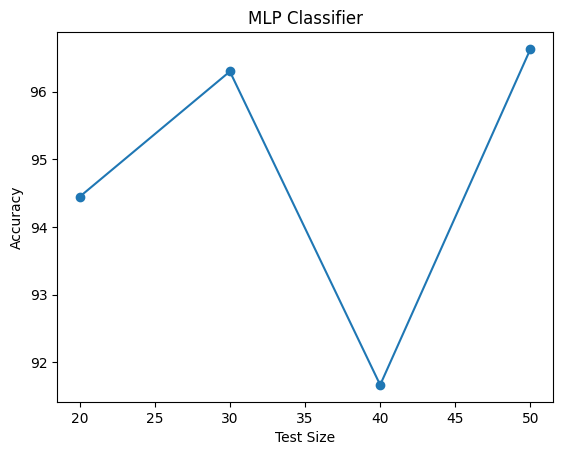

In [22]:
_ = performOperation(X, Y.values.ravel(), model=MLPClassifier(max_iter=1000, hidden_layer_sizes= (10,10,10) , learning_rate='adaptive',momentum = 0.95 , learning_rate_init=0.001), title="MLP Classifier", scaler=StandardScaler(), sampler=RandomOverSampler())

###MLP CLASSIFIER ( HANDWRITTEN DIGIT DATASET )

MLP Classifier
--------------------------------------------------
Performance for Test Size = 20%
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       105
           1       0.93      0.95      0.94       126
           2       0.96      0.95      0.95       114
           3       0.97      0.94      0.95       109
           4       0.98      0.98      0.98       101
           5       0.96      0.96      0.96       100
           6       1.00      0.96      0.98        99
           7       1.00      0.98      0.99       135
           8       0.93      0.96      0.94       120
           9       0.91      0.94      0.92       115

    accuracy                           0.96      1124
   macro avg       0.96      0.96      0.96      1124
weighted avg       0.96      0.96      0.96      1124

Confusion Matrix:


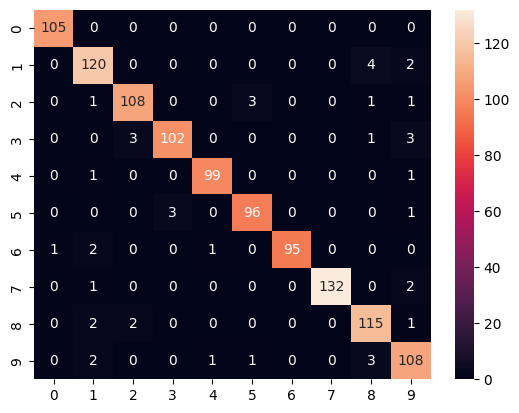



Generating ROC for Test Size = 20%


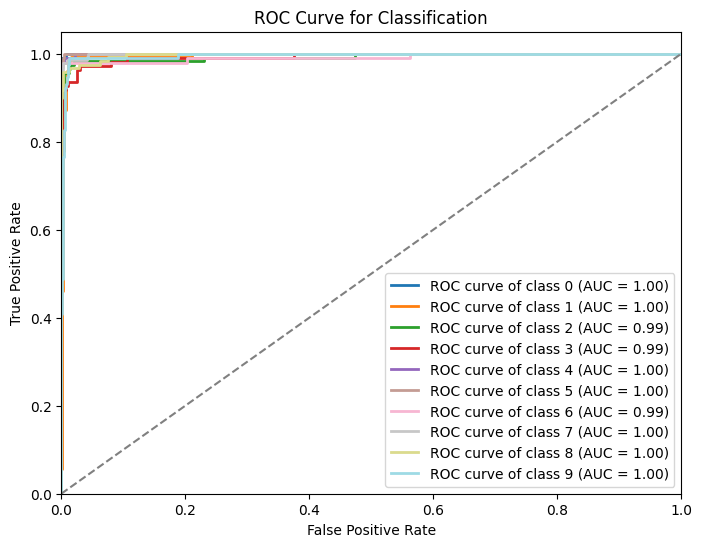

--------------------------------------------------
Performance for Test Size = 30%
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       171
           1       0.93      0.93      0.93       192
           2       0.92      0.96      0.94       173
           3       0.96      0.93      0.95       179
           4       0.97      0.98      0.98       147
           5       0.96      0.99      0.97       158
           6       0.99      0.98      0.98       145
           7       0.98      0.96      0.97       186
           8       0.97      0.90      0.93       169
           9       0.89      0.92      0.91       167

    accuracy                           0.95      1687
   macro avg       0.95      0.95      0.95      1687
weighted avg       0.95      0.95      0.95      1687

Confusion Matrix:


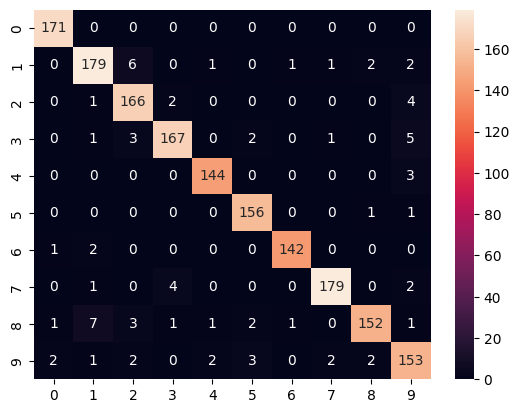



Generating ROC for Test Size = 30%


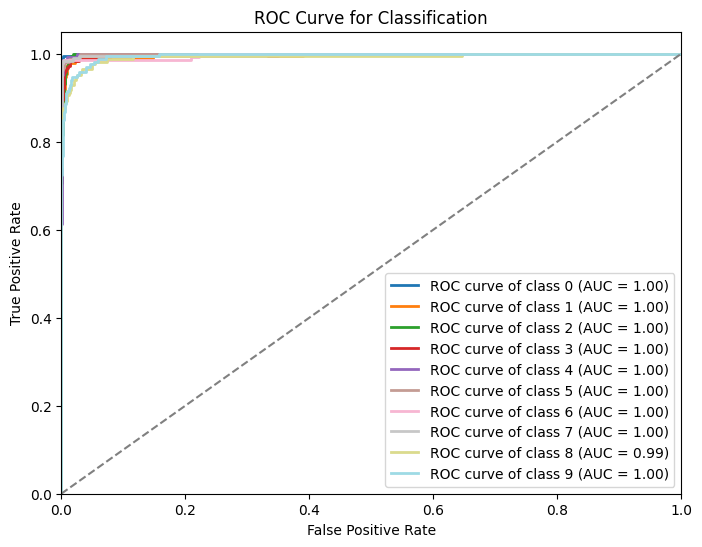

--------------------------------------------------
Performance for Test Size = 40%
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       215
           1       0.94      0.93      0.93       249
           2       0.94      0.98      0.96       225
           3       0.92      0.95      0.94       220
           4       0.96      0.97      0.97       201
           5       0.98      0.95      0.97       219
           6       0.98      0.99      0.98       215
           7       0.96      0.96      0.96       249
           8       0.93      0.88      0.91       241
           9       0.89      0.91      0.90       214

    accuracy                           0.95      2248
   macro avg       0.95      0.95      0.95      2248
weighted avg       0.95      0.95      0.95      2248

Confusion Matrix:


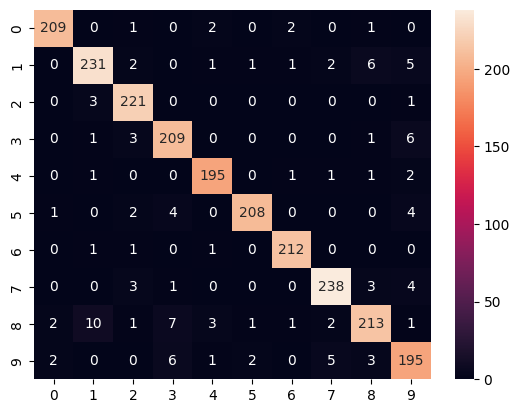



Generating ROC for Test Size = 40%


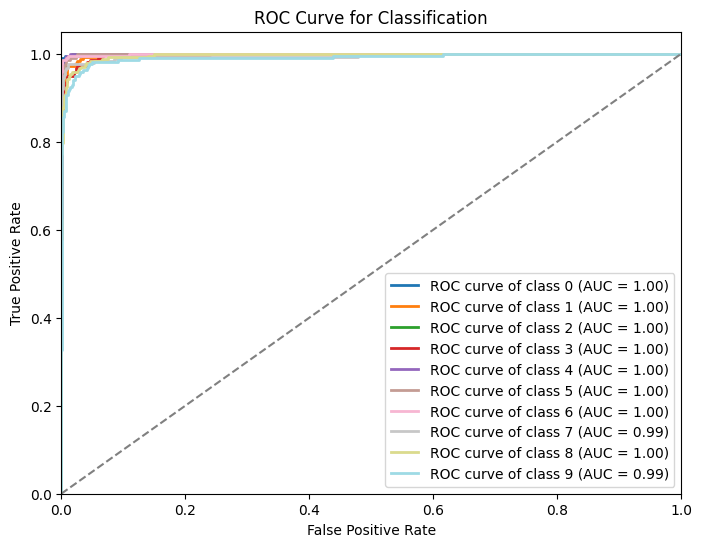

--------------------------------------------------
Performance for Test Size = 50%
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       263
           1       0.93      0.89      0.91       309
           2       0.93      0.93      0.93       273
           3       0.95      0.95      0.95       293
           4       0.96      0.97      0.96       268
           5       0.96      0.98      0.97       266
           6       0.96      0.98      0.97       270
           7       0.98      0.96      0.97       307
           8       0.88      0.90      0.89       289
           9       0.93      0.93      0.93       272

    accuracy                           0.94      2810
   macro avg       0.95      0.95      0.95      2810
weighted avg       0.94      0.94      0.94      2810

Confusion Matrix:


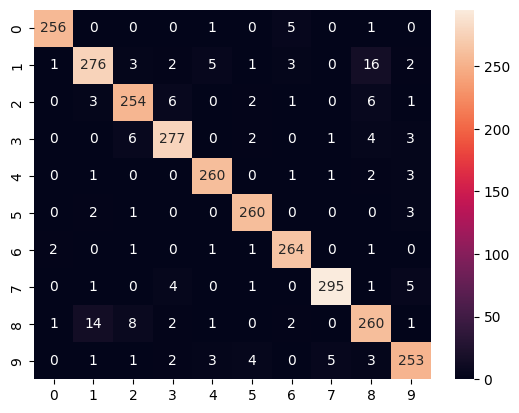



Generating ROC for Test Size = 50%


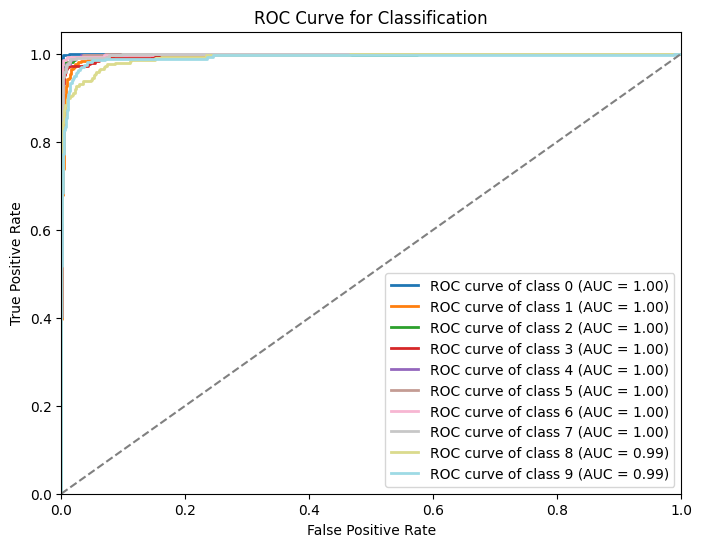

--------------------------------------------------
Summary of Performance across different test sizes
--------------------------------------------------
Got Maximum Accuracy for Test Size =  20 %
Maximum Accuracy =  96.08540925266904 %




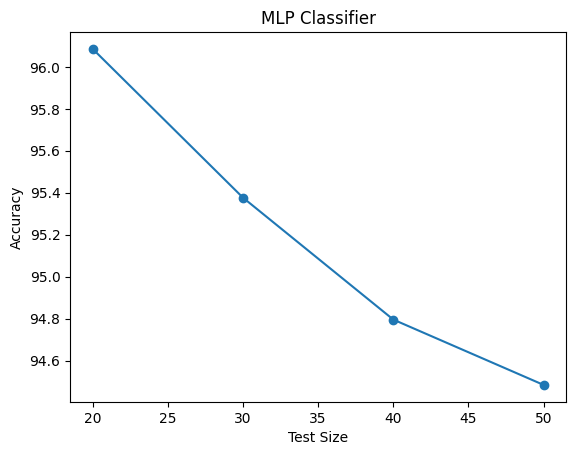

In [23]:
_ = performOperation(x, y.values.ravel(), model=MLPClassifier(max_iter=1000, hidden_layer_sizes= (10,10,10) , learning_rate='adaptive', momentum = 0.95), title="MLP Classifier", scaler=StandardScaler(), sampler=RandomOverSampler())

###RANDOM FOREST CLASSIFIER ( WINE DATASET )

Random Forest Classifier
--------------------------------------------------
Performance for Test Size = 20%
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        10
           2       1.00      0.83      0.91        18
           3       0.73      1.00      0.84         8

    accuracy                           0.92        36
   macro avg       0.91      0.94      0.92        36
weighted avg       0.94      0.92      0.92        36

Confusion Matrix:


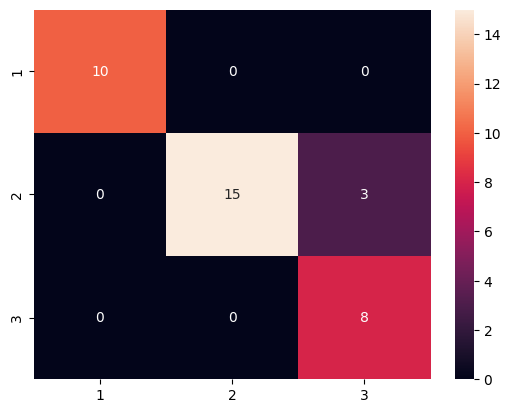



Generating ROC for Test Size = 20%


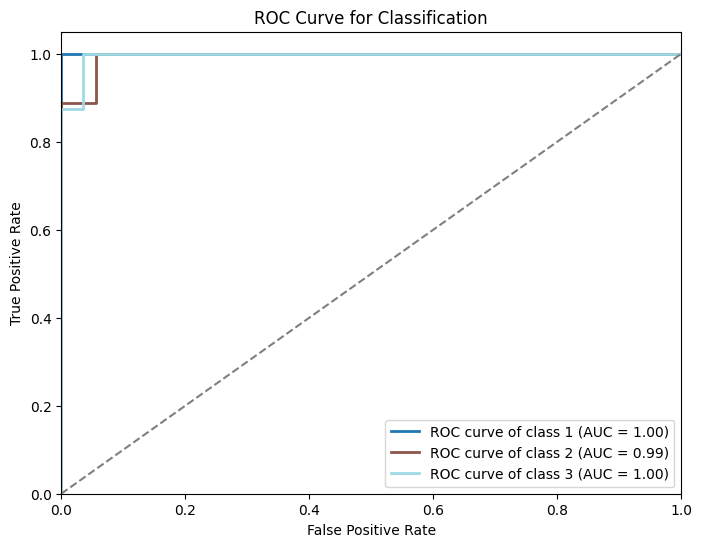

--------------------------------------------------
Performance for Test Size = 30%
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        15
           2       1.00      0.93      0.96        27
           3       0.86      1.00      0.92        12

    accuracy                           0.96        54
   macro avg       0.95      0.98      0.96        54
weighted avg       0.97      0.96      0.96        54

Confusion Matrix:


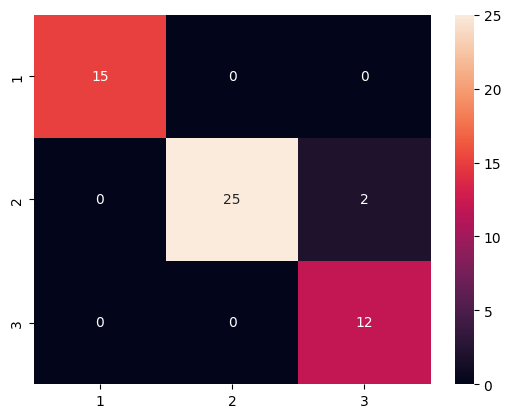



Generating ROC for Test Size = 30%


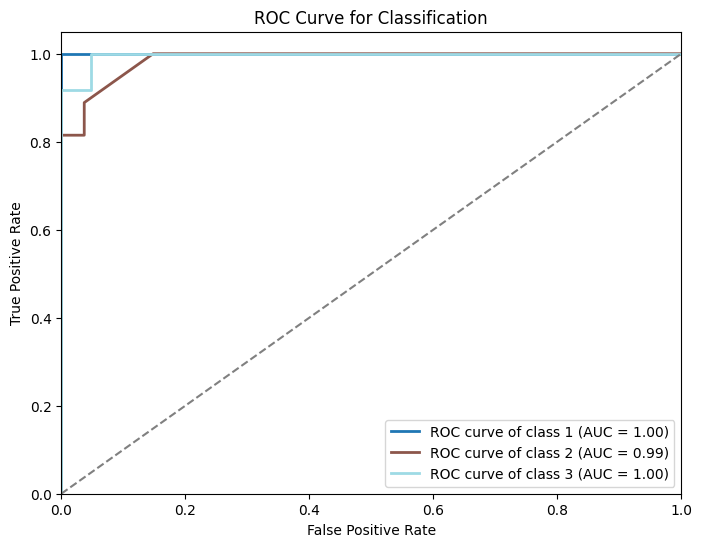

--------------------------------------------------
Performance for Test Size = 40%
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           1       0.95      1.00      0.98        20
           2       0.97      0.91      0.94        33
           3       0.90      0.95      0.92        19

    accuracy                           0.94        72
   macro avg       0.94      0.95      0.95        72
weighted avg       0.95      0.94      0.94        72

Confusion Matrix:


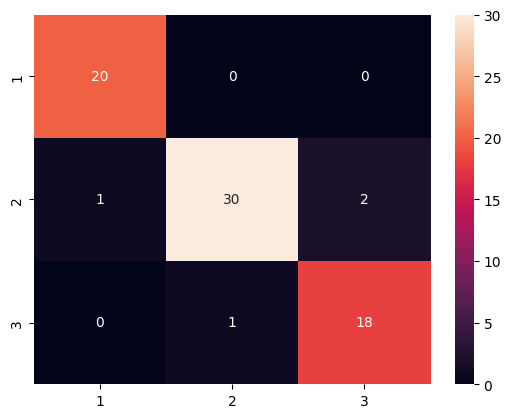



Generating ROC for Test Size = 40%


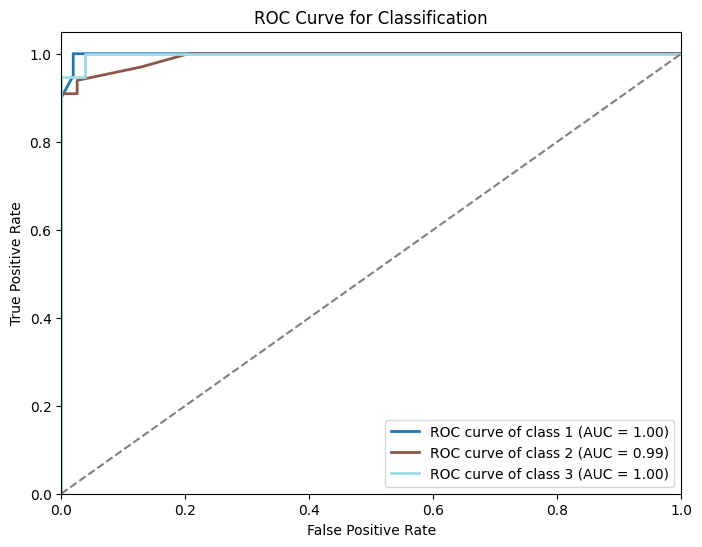

--------------------------------------------------
Performance for Test Size = 50%
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           1       0.84      0.93      0.89        29
           2       0.90      0.80      0.85        35
           3       0.92      0.96      0.94        25

    accuracy                           0.89        89
   macro avg       0.89      0.90      0.89        89
weighted avg       0.89      0.89      0.89        89

Confusion Matrix:


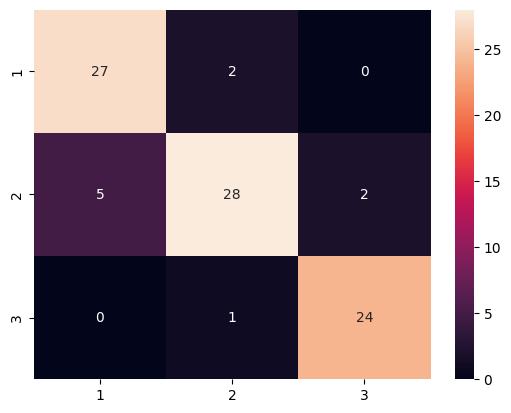



Generating ROC for Test Size = 50%


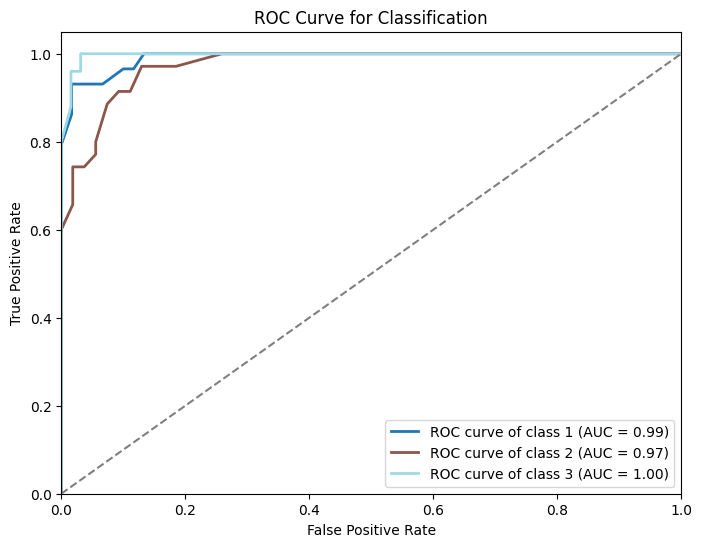

--------------------------------------------------
Summary of Performance across different test sizes
--------------------------------------------------
Got Maximum Accuracy for Test Size =  30 %
Maximum Accuracy =  96.29629629629629 %




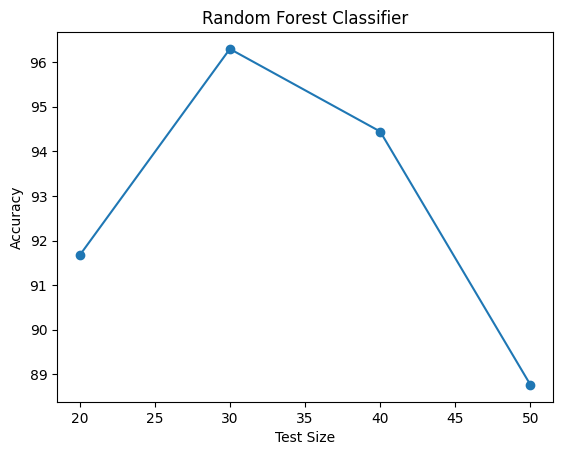

In [24]:
_ = performOperation(X, Y.values.ravel(), model=RandomForestClassifier(n_estimators=20 , random_state=10), title="Random Forest Classifier", sampler=RandomOverSampler())

###RANDOM FOREST CLASSIFIER ( HANDWRITTEN DIGIT DATASET )

Random Forest Classifier
--------------------------------------------------
Performance for Test Size = 20%
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       105
           1       0.93      1.00      0.96       126
           2       1.00      1.00      1.00       114
           3       0.96      0.97      0.97       109
           4       0.98      0.97      0.98       101
           5       0.99      0.97      0.98       100
           6       1.00      0.96      0.98        99
           7       0.99      0.99      0.99       135
           8       0.97      0.93      0.95       120
           9       0.95      0.95      0.95       115

    accuracy                           0.97      1124
   macro avg       0.97      0.97      0.97      1124
weighted avg       0.97      0.97      0.97      1124

Confusion Matrix:


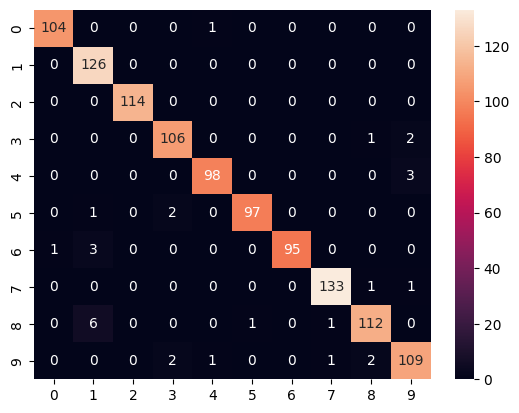



Generating ROC for Test Size = 20%


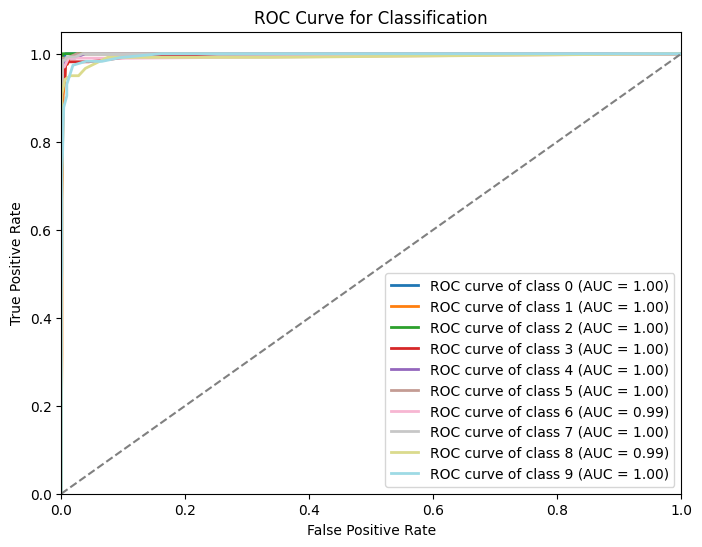

--------------------------------------------------
Performance for Test Size = 30%
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       171
           1       0.95      0.98      0.97       192
           2       0.98      1.00      0.99       173
           3       0.97      0.96      0.96       179
           4       0.99      0.98      0.99       147
           5       0.99      0.98      0.98       158
           6       0.99      0.97      0.98       145
           7       0.97      0.98      0.98       186
           8       0.99      0.95      0.97       169
           9       0.93      0.93      0.93       167

    accuracy                           0.97      1687
   macro avg       0.97      0.97      0.97      1687
weighted avg       0.97      0.97      0.97      1687

Confusion Matrix:


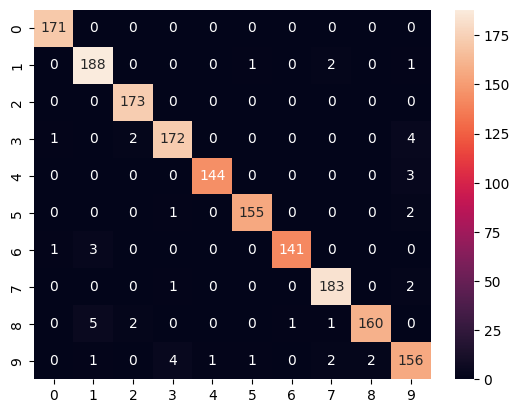



Generating ROC for Test Size = 30%


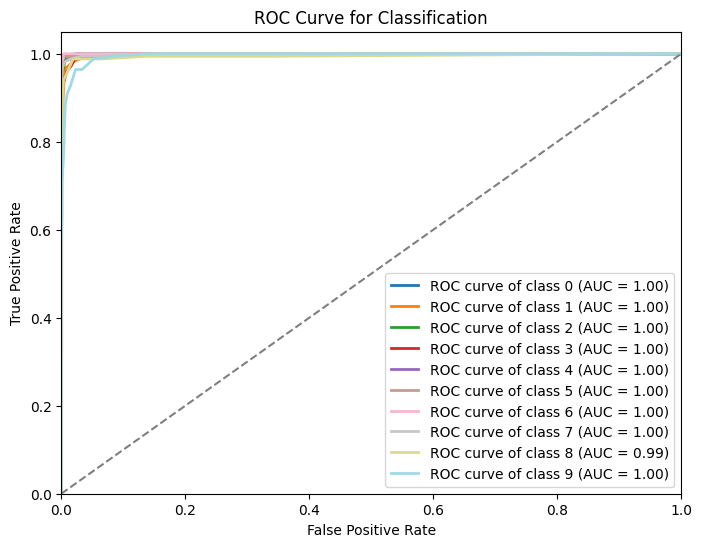

--------------------------------------------------
Performance for Test Size = 40%
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       215
           1       0.95      0.97      0.96       249
           2       0.98      0.98      0.98       225
           3       0.97      0.95      0.96       220
           4       0.98      0.98      0.98       201
           5       1.00      0.97      0.98       219
           6       0.99      0.98      0.99       215
           7       0.98      0.98      0.98       249
           8       0.97      0.93      0.94       241
           9       0.91      0.96      0.93       214

    accuracy                           0.97      2248
   macro avg       0.97      0.97      0.97      2248
weighted avg       0.97      0.97      0.97      2248

Confusion Matrix:


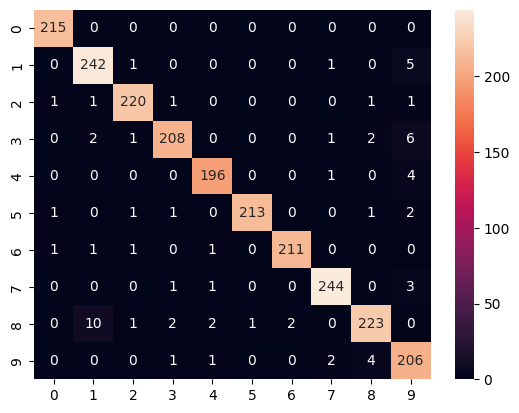



Generating ROC for Test Size = 40%


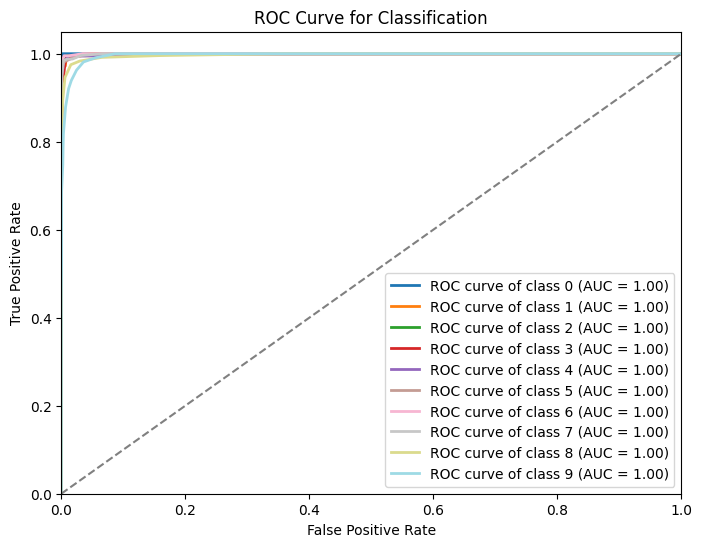

--------------------------------------------------
Performance for Test Size = 50%
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       263
           1       0.95      0.97      0.96       309
           2       0.98      0.98      0.98       273
           3       0.97      0.96      0.97       293
           4       0.99      0.98      0.99       268
           5       1.00      0.96      0.98       266
           6       0.99      0.99      0.99       270
           7       0.97      0.98      0.98       307
           8       0.96      0.93      0.95       289
           9       0.90      0.94      0.92       272

    accuracy                           0.97      2810
   macro avg       0.97      0.97      0.97      2810
weighted avg       0.97      0.97      0.97      2810

Confusion Matrix:


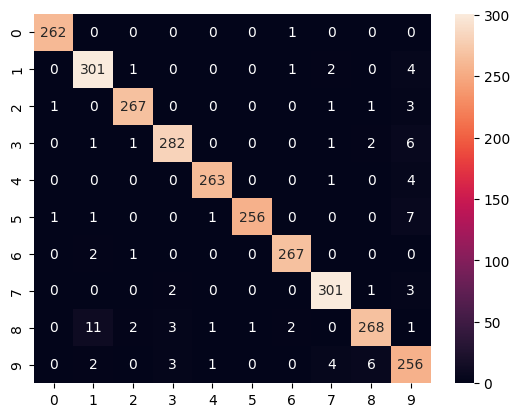



Generating ROC for Test Size = 50%


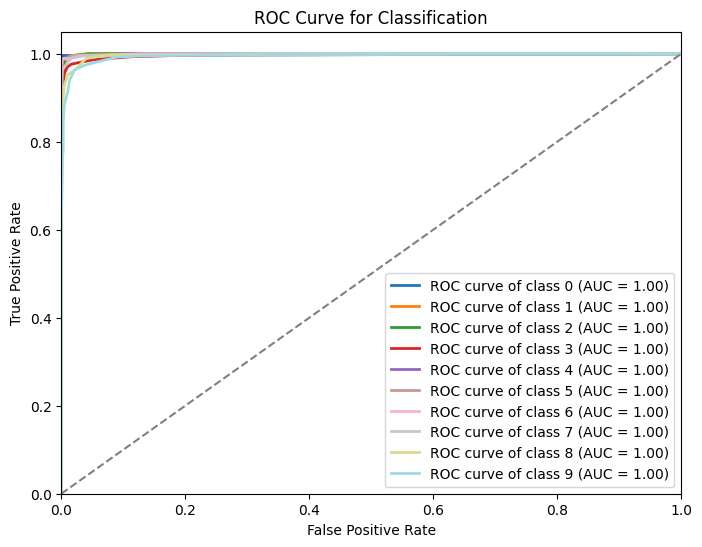

--------------------------------------------------
Summary of Performance across different test sizes
--------------------------------------------------
Got Maximum Accuracy for Test Size =  30 %
Maximum Accuracy =  97.3918197984588 %




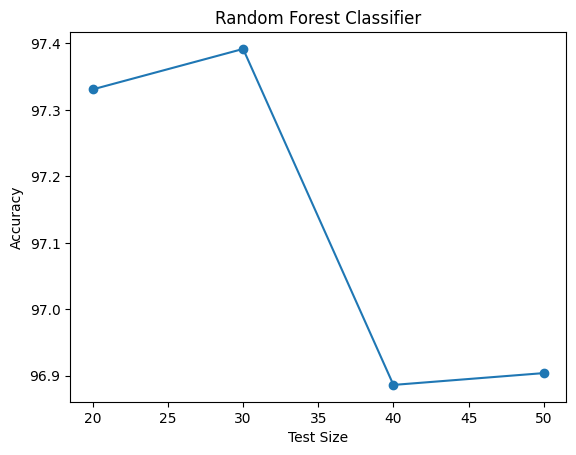

In [25]:
_ = performOperation(x, y.values.ravel(), model=RandomForestClassifier(n_estimators=20 , random_state=10), title="Random Forest Classifier", sampler=RandomOverSampler())

###PCA COMPUTATION

In [26]:
def performOperationPCA(X, y, model_to_test, test_split, scaler=None, sampler=None, max_components=None):
    # This function finds the optimal number of PCA components for a given model and prints the performance.
    if max_components is None:
        max_components = min(X.shape) - 1

    best_accuracy = 0
    best_n_components = 0
    best_report = None
    best_conf_matrix = None

    accuracies = []


    step = 10 if max_components > 20 else 1

    for n_components in range(1, max_components, step):
        pca = PCA(n_components=n_components)
        X_pca = pca.fit_transform(X)

        X_train, y_train, X_test, y_test = preprocessing(
            X_pca, y, test_split=test_split, scaler=scaler, sampler=sampler
        )

        accuracy, report, conf_matrix = trainAndPredict(model_to_test, X_train, y_train, X_test, y_test)

        accuracies.append(accuracy)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_n_components = n_components
            best_report = report
            best_conf_matrix = conf_matrix


    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_components, step), accuracies, marker='o', linestyle='--')
    plt.title('Accuracy vs. Number of PCA Components')
    plt.xlabel('Number of Components')
    plt.ylabel('Accuracy')


    if max_components > 20:
        plt.xticks(np.arange(0, max_components, 10))
    else:
        plt.xticks(range(1, max_components))

    plt.grid(True)
    plt.show()

    print(f"Maximum number of components: {max_components}")
    print(f"Optimal number of PCA components: {best_n_components}")
    print(f"Maximum accuracy with these components: {best_accuracy * 100:.2f}%")

    print("\n\n--- Performance Evaluation for Optimal Components ---")
    print("Classification Report:")
    print(best_report)
    print("Confusion Matrix:")
    sns.heatmap(best_conf_matrix, annot=True, fmt='d')
    plt.show()
    print("\n")

    return best_n_components, best_accuracy

###SVM CLASSIFIER AFTER PCA ( WINE DATASET )

After Using Principal Component Analysis (PCA) for feature dimensionality reduction ---> SVM classifier


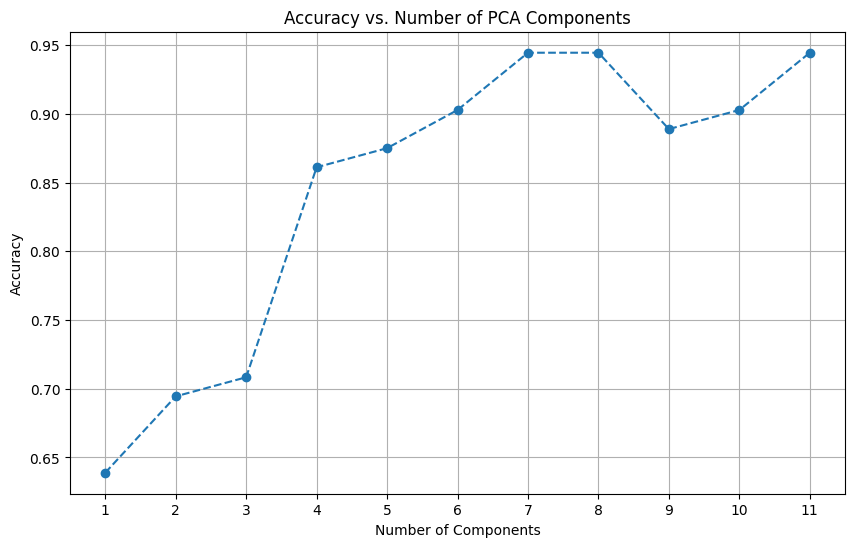

Maximum number of components: 12
Optimal number of PCA components: 7
Maximum accuracy with these components: 94.44%


--- Performance Evaluation for Optimal Components ---
Classification Report:
              precision    recall  f1-score   support

           1       0.91      1.00      0.95        20
           2       1.00      0.88      0.94        33
           3       0.90      1.00      0.95        19

    accuracy                           0.94        72
   macro avg       0.94      0.96      0.95        72
weighted avg       0.95      0.94      0.94        72

Confusion Matrix:


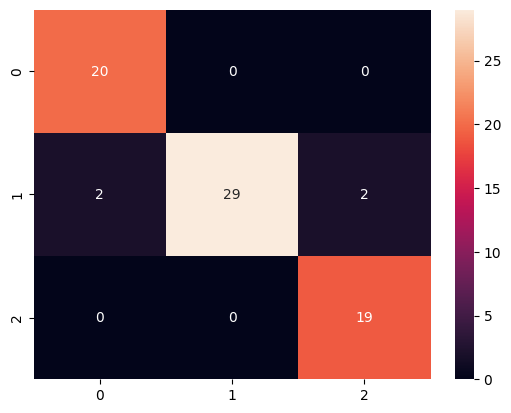

(7, 0.9444444444444444)

In [27]:
print("After Using Principal Component Analysis (PCA) for feature dimensionality reduction ---> SVM classifier")
performOperationPCA(X, Y.values.ravel(), model_to_test=SVC(kernel='linear', probability=True), test_split=0.4, scaler=StandardScaler(), sampler=RandomOverSampler())

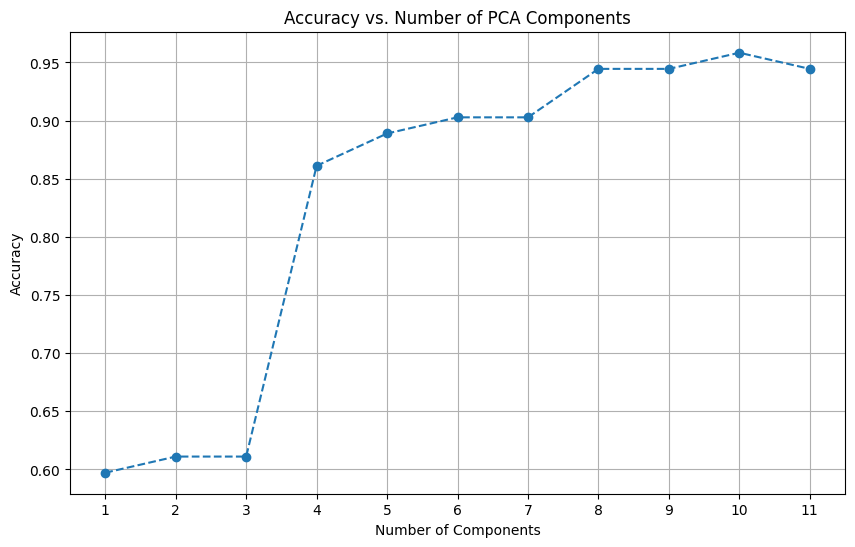

Maximum number of components: 12
Optimal number of PCA components: 10
Maximum accuracy with these components: 95.83%


--- Performance Evaluation for Optimal Components ---
Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.95      0.97        20
           2       0.92      1.00      0.96        33
           3       1.00      0.89      0.94        19

    accuracy                           0.96        72
   macro avg       0.97      0.95      0.96        72
weighted avg       0.96      0.96      0.96        72

Confusion Matrix:


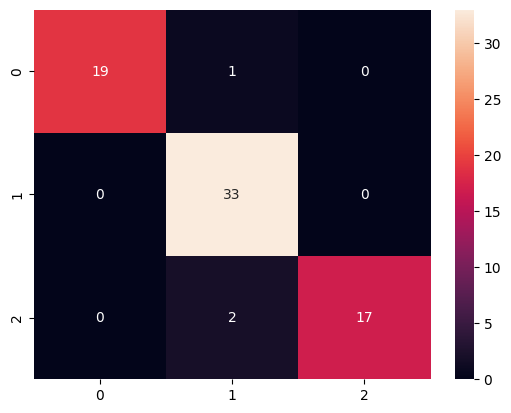

(10, 0.9583333333333334)

In [28]:
performOperationPCA(X, Y.values.ravel(), model_to_test=SVC(kernel='poly', degree=3 , probability=True), test_split=0.4 ,  scaler=StandardScaler(), sampler=RandomOverSampler())

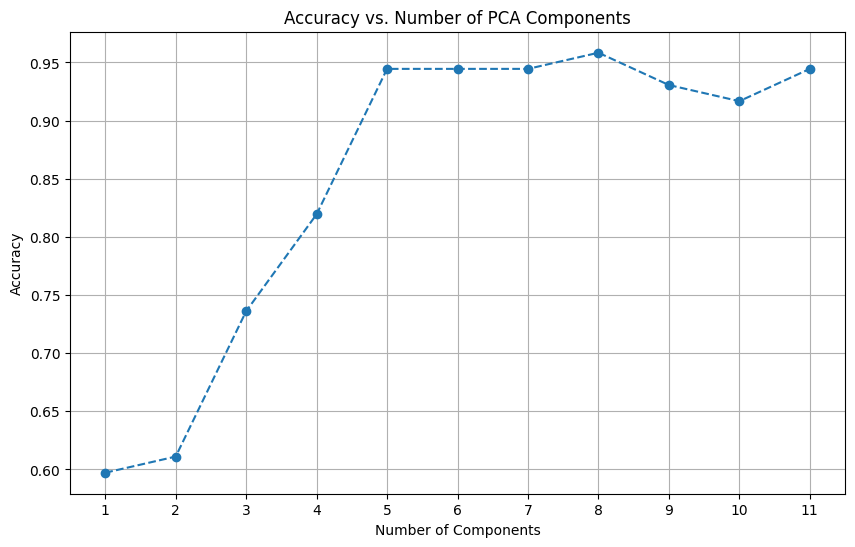

Maximum number of components: 12
Optimal number of PCA components: 8
Maximum accuracy with these components: 95.83%


--- Performance Evaluation for Optimal Components ---
Classification Report:
              precision    recall  f1-score   support

           1       0.95      0.90      0.92        20
           2       0.94      0.97      0.96        33
           3       1.00      1.00      1.00        19

    accuracy                           0.96        72
   macro avg       0.96      0.96      0.96        72
weighted avg       0.96      0.96      0.96        72

Confusion Matrix:


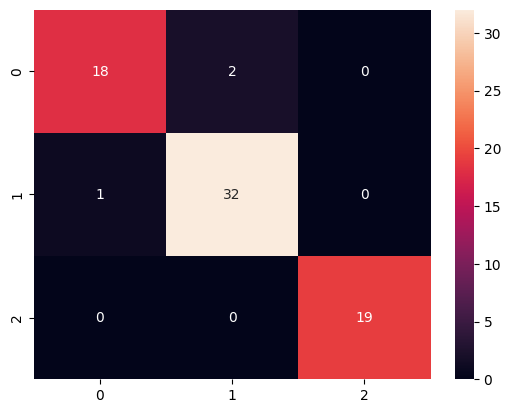

(8, 0.9583333333333334)

In [29]:
performOperationPCA(X, Y.values.ravel(), model_to_test=SVC(kernel='sigmoid', gamma=0.01, probability=True), test_split=0.4,  scaler=StandardScaler(), sampler=RandomOverSampler())

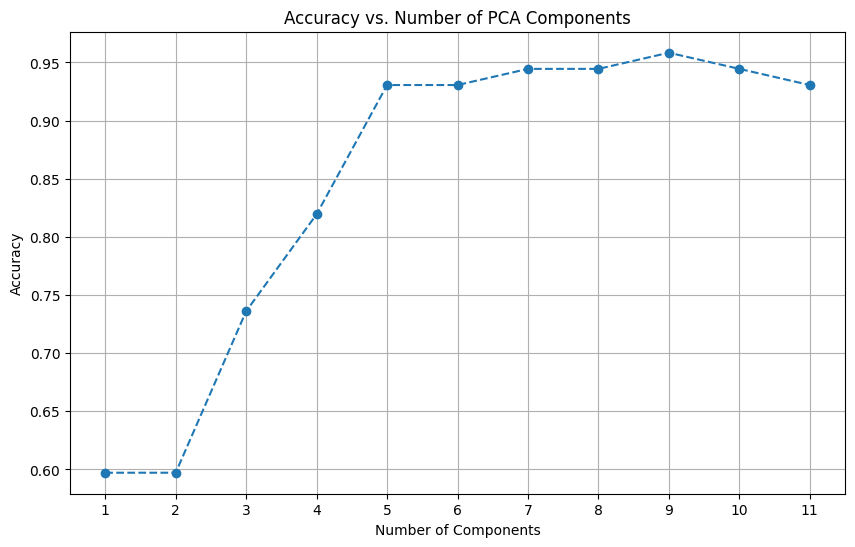

Maximum number of components: 12
Optimal number of PCA components: 9
Maximum accuracy with these components: 95.83%


--- Performance Evaluation for Optimal Components ---
Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.90      0.95        20
           2       0.94      0.97      0.96        33
           3       0.95      1.00      0.97        19

    accuracy                           0.96        72
   macro avg       0.96      0.96      0.96        72
weighted avg       0.96      0.96      0.96        72

Confusion Matrix:


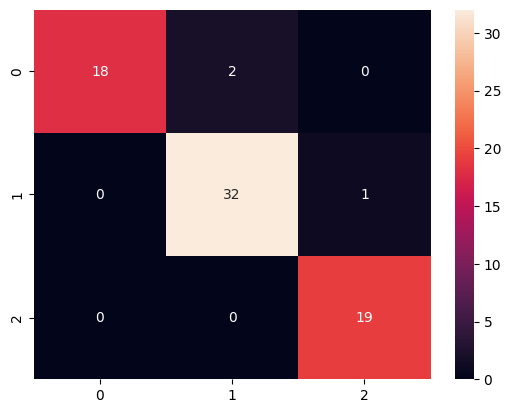

(9, 0.9583333333333334)

In [30]:
performOperationPCA(X, Y.values.ravel(), model_to_test=SVC(kernel='rbf', C=0.5, gamma=0.01 ,probability=True), test_split=0.4 , scaler=StandardScaler(), sampler=RandomOverSampler())

###MLP CLASSIFIER AFTER PCA ( WINE DATASET )

After Using Principal Component Analysis (PCA) for feature dimensionality reduction ---> MLP classifier


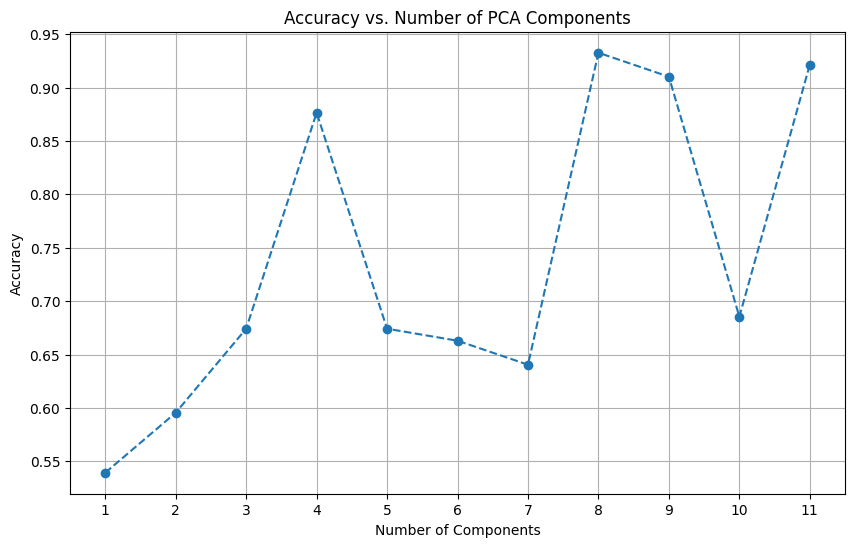

Maximum number of components: 12
Optimal number of PCA components: 8
Maximum accuracy with these components: 93.26%


--- Performance Evaluation for Optimal Components ---
Classification Report:
              precision    recall  f1-score   support

           1       0.90      0.93      0.92        29
           2       0.94      0.89      0.91        35
           3       0.96      1.00      0.98        25

    accuracy                           0.93        89
   macro avg       0.93      0.94      0.94        89
weighted avg       0.93      0.93      0.93        89

Confusion Matrix:


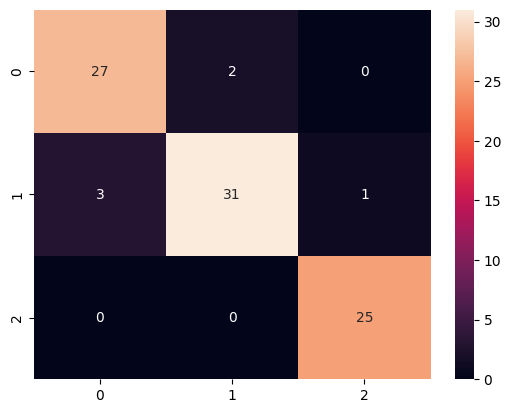

(8, 0.9325842696629213)

In [31]:
print("After Using Principal Component Analysis (PCA) for feature dimensionality reduction ---> MLP classifier")
performOperationPCA(X, Y.values.ravel(), model_to_test=MLPClassifier(max_iter=1000, learning_rate='adaptive',momentum=0.9), test_split=0.5, sampler=RandomOverSampler())

###RANDOM FOREST CLASSIFIER AFTER PCA ( WINE DATASET )

After Using Principal Component Analysis (PCA) for feature dimensionality reduction ---> Random Forest classifier


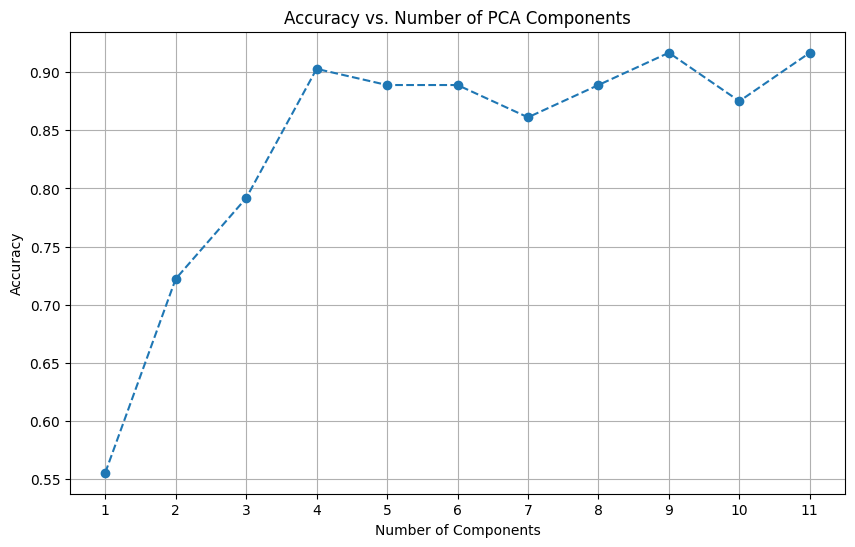

Maximum number of components: 12
Optimal number of PCA components: 9
Maximum accuracy with these components: 91.67%


--- Performance Evaluation for Optimal Components ---
Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.95      0.97        20
           2       0.97      0.88      0.92        33
           3       0.78      0.95      0.86        19

    accuracy                           0.92        72
   macro avg       0.92      0.93      0.92        72
weighted avg       0.93      0.92      0.92        72

Confusion Matrix:


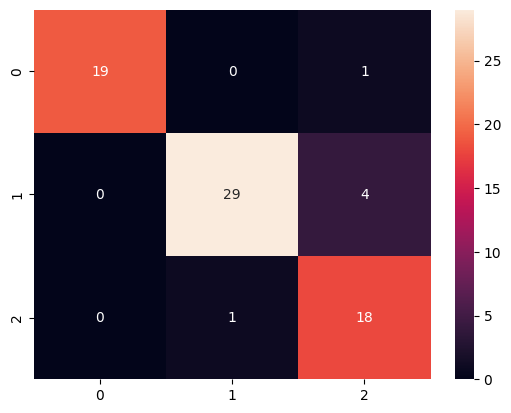

(9, 0.9166666666666666)

In [32]:
print("After Using Principal Component Analysis (PCA) for feature dimensionality reduction ---> Random Forest classifier")
performOperationPCA(X, Y.values.ravel(), model_to_test=RandomForestClassifier(n_estimators=20, random_state=0), test_split=0.4, sampler=RandomOverSampler())

###SVM CLASSIFIER AFTER PCA ( HANDWRITTEN DIGIT DATASET )

After Using Principal Component Analysis (PCA) for feature dimensionality reduction ---> SVM classifier


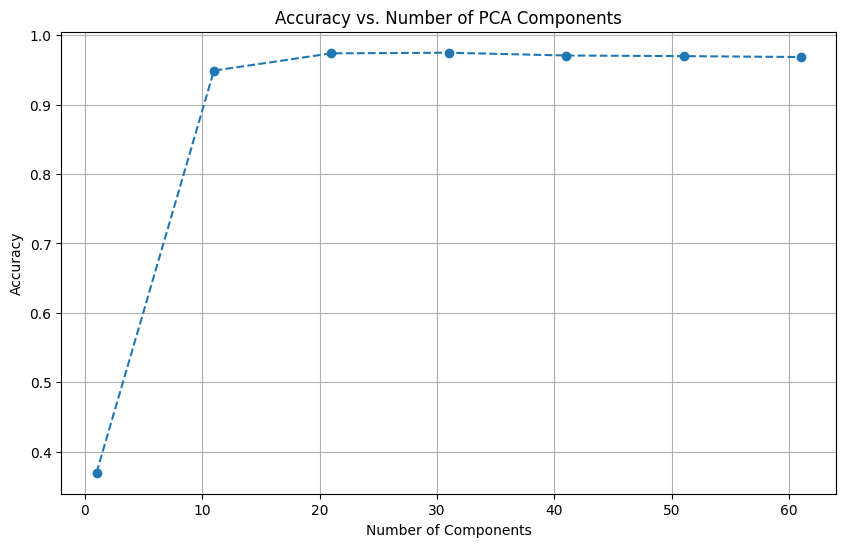

Maximum number of components: 63
Optimal number of PCA components: 31
Maximum accuracy with these components: 97.46%


--- Performance Evaluation for Optimal Components ---
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       215
           1       0.95      0.97      0.96       249
           2       0.99      0.99      0.99       225
           3       0.96      0.97      0.96       220
           4       0.98      0.99      0.98       201
           5       0.99      0.98      0.99       219
           6       1.00      0.98      0.99       215
           7       0.98      0.97      0.98       249
           8       0.99      0.93      0.96       241
           9       0.92      0.96      0.94       214

    accuracy                           0.97      2248
   macro avg       0.98      0.98      0.98      2248
weighted avg       0.98      0.97      0.97      2248

Confusion Matrix:


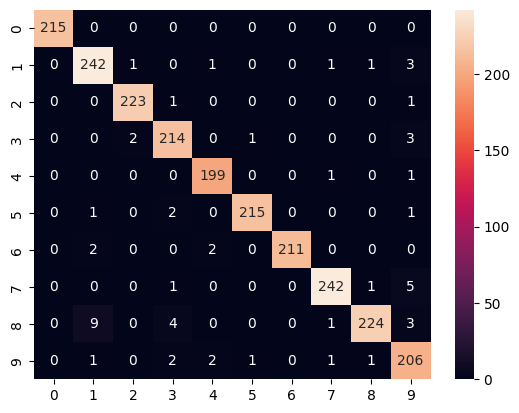

(31, 0.974644128113879)

In [33]:
print("After Using Principal Component Analysis (PCA) for feature dimensionality reduction ---> SVM classifier") # This prints a descriptive message to the console
performOperationPCA(x, y.values.ravel(), model_to_test=SVC(kernel='linear', probability=True), test_split= 0.4 ,scaler=StandardScaler(), sampler=RandomOverSampler())

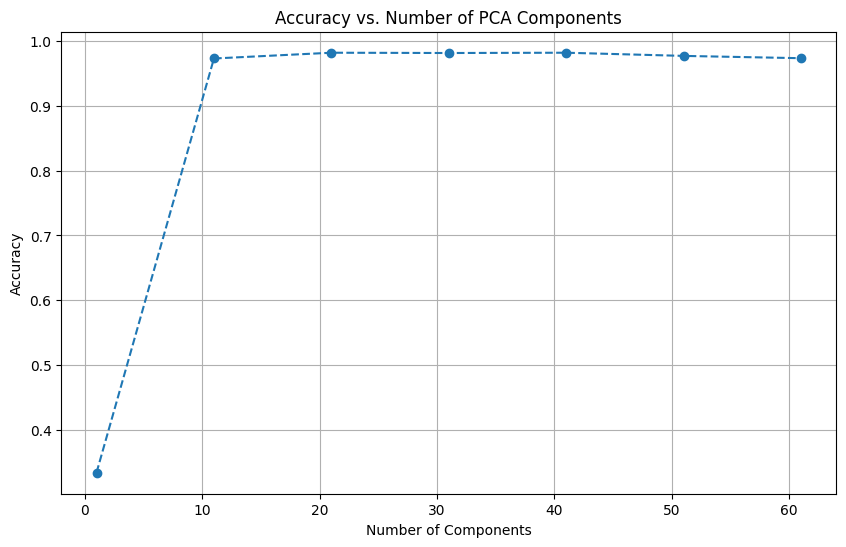

Maximum number of components: 63
Optimal number of PCA components: 21
Maximum accuracy with these components: 98.18%


--- Performance Evaluation for Optimal Components ---
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       215
           1       0.95      0.98      0.96       249
           2       1.00      1.00      1.00       225
           3       0.98      0.99      0.98       220
           4       1.00      0.99      0.99       201
           5       1.00      1.00      1.00       219
           6       0.99      0.99      0.99       215
           7       0.99      0.98      0.98       249
           8       0.99      0.94      0.96       241
           9       0.94      0.98      0.96       214

    accuracy                           0.98      2248
   macro avg       0.98      0.98      0.98      2248
weighted avg       0.98      0.98      0.98      2248

Confusion Matrix:


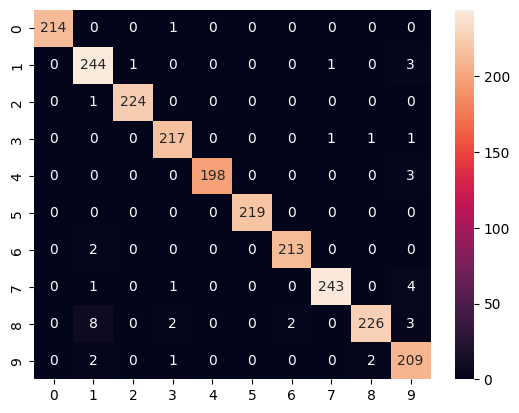

(21, 0.9817615658362989)

In [34]:
performOperationPCA(x, y.values.ravel(), model_to_test=SVC(kernel='poly', degree=3 , probability=True), test_split=0.4 ,  scaler=StandardScaler(), sampler=RandomOverSampler())

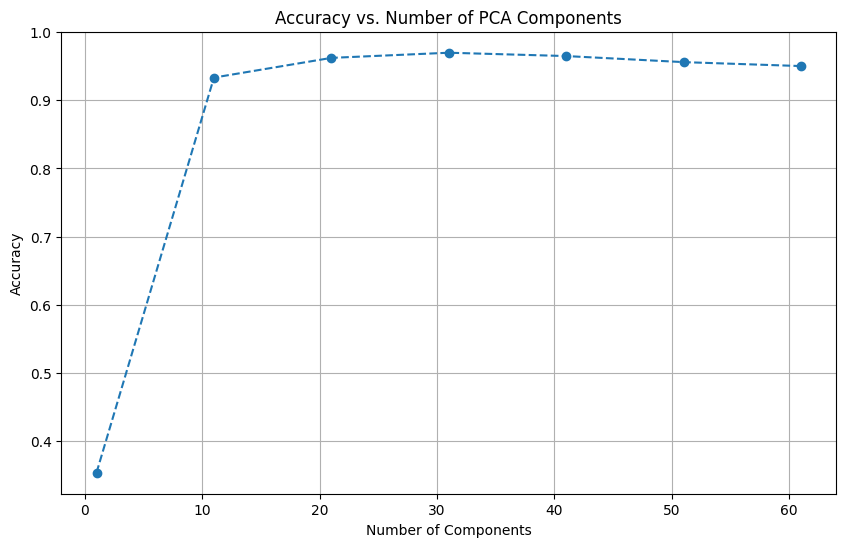

Maximum number of components: 63
Optimal number of PCA components: 31
Maximum accuracy with these components: 96.98%


--- Performance Evaluation for Optimal Components ---
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       215
           1       0.94      0.96      0.95       249
           2       0.98      0.98      0.98       225
           3       0.97      0.96      0.97       220
           4       0.95      0.99      0.97       201
           5       0.99      0.97      0.98       219
           6       1.00      0.98      0.99       215
           7       0.99      0.97      0.98       249
           8       0.96      0.93      0.94       241
           9       0.92      0.97      0.94       214

    accuracy                           0.97      2248
   macro avg       0.97      0.97      0.97      2248
weighted avg       0.97      0.97      0.97      2248

Confusion Matrix:


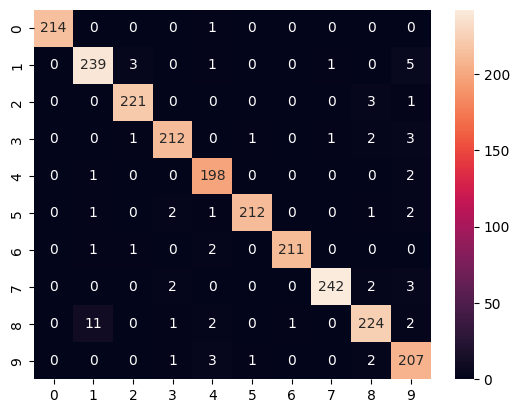

(31, 0.9697508896797153)

In [35]:
performOperationPCA(x, y.values.ravel(), model_to_test=SVC(kernel='sigmoid', gamma=0.01, probability=True), test_split=0.4,  scaler=StandardScaler(), sampler=RandomOverSampler())

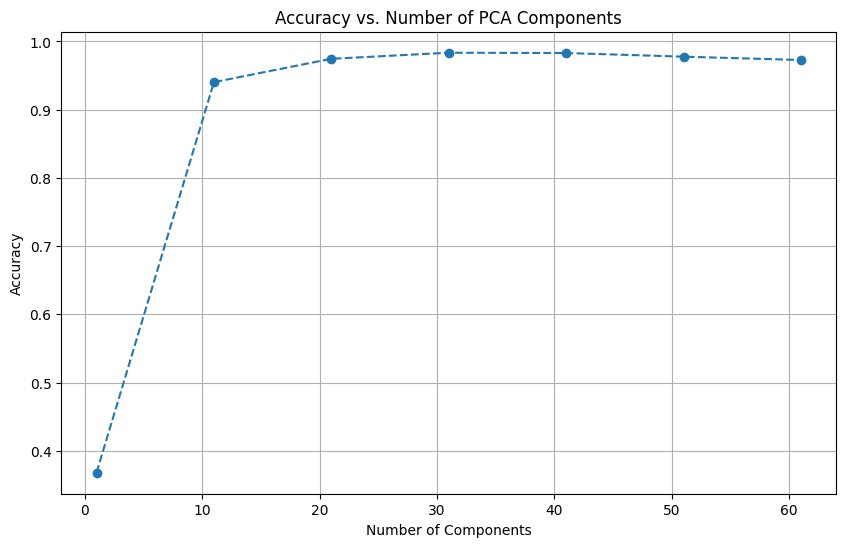

Maximum number of components: 63
Optimal number of PCA components: 31
Maximum accuracy with these components: 98.35%


--- Performance Evaluation for Optimal Components ---
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       215
           1       0.96      0.98      0.97       249
           2       1.00      1.00      1.00       225
           3       0.99      0.97      0.98       220
           4       0.99      0.99      0.99       201
           5       1.00      0.98      0.99       219
           6       1.00      0.99      1.00       215
           7       1.00      0.99      0.99       249
           8       0.97      0.96      0.97       241
           9       0.93      0.99      0.96       214

    accuracy                           0.98      2248
   macro avg       0.98      0.98      0.98      2248
weighted avg       0.98      0.98      0.98      2248

Confusion Matrix:


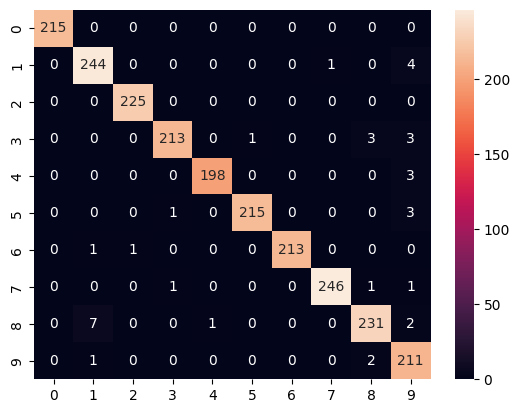

(31, 0.983540925266904)

In [36]:
performOperationPCA(x, y.values.ravel(), model_to_test=SVC(kernel='rbf', C=0.5, gamma=0.01 ,probability=True), test_split=0.4 , scaler=StandardScaler(), sampler=RandomOverSampler())

###MLP CLASSIFIER AFTER PCA ( HANDWRITTEN DIGIT DATASET )

After Using Principal Component Analysis (PCA) for feature dimensionality reduction ---> MLP classifier


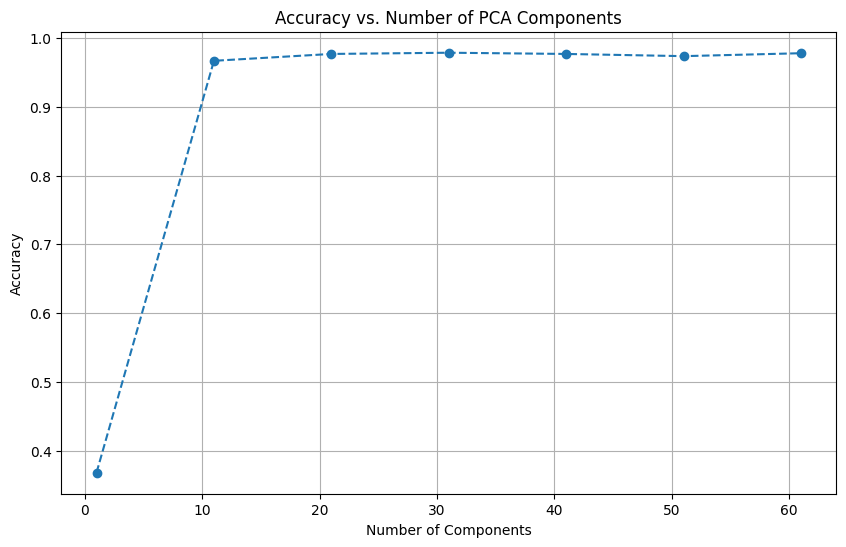

Maximum number of components: 63
Optimal number of PCA components: 31
Maximum accuracy with these components: 97.86%


--- Performance Evaluation for Optimal Components ---
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       263
           1       0.97      0.97      0.97       309
           2       0.97      0.98      0.98       273
           3       0.98      0.98      0.98       293
           4       0.99      0.99      0.99       268
           5       0.98      0.98      0.98       266
           6       0.98      0.99      0.99       270
           7       0.98      0.99      0.98       307
           8       0.98      0.95      0.97       289
           9       0.95      0.97      0.96       272

    accuracy                           0.98      2810
   macro avg       0.98      0.98      0.98      2810
weighted avg       0.98      0.98      0.98      2810

Confusion Matrix:


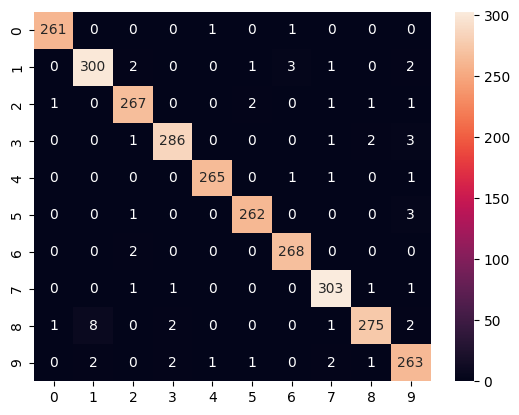

(31, 0.9786476868327402)

In [37]:
print("After Using Principal Component Analysis (PCA) for feature dimensionality reduction ---> MLP classifier")
performOperationPCA(x, y.values.ravel(), model_to_test=MLPClassifier(max_iter=1000, learning_rate='adaptive',momentum=0.9), test_split=0.5, sampler=RandomOverSampler())

###RANDOM FOREST CLASSIFIER AFTER PCA ( HANDWRITTEN DIGIT DATASET )

After Using Principal Component Analysis (PCA) for feature dimensionality reduction ---> Random Forest classifier


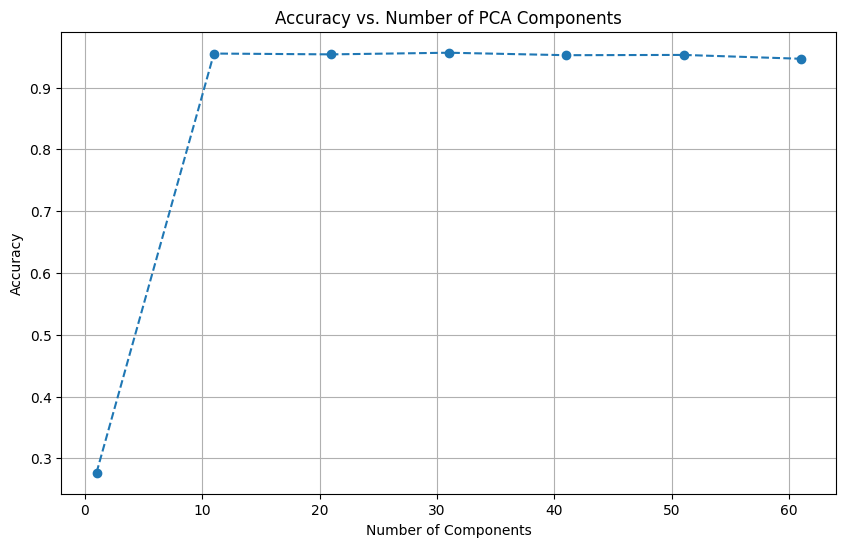

Maximum number of components: 63
Optimal number of PCA components: 31
Maximum accuracy with these components: 95.64%


--- Performance Evaluation for Optimal Components ---
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       215
           1       0.94      0.96      0.95       249
           2       0.96      0.98      0.97       225
           3       0.95      0.93      0.94       220
           4       0.97      0.98      0.97       201
           5       0.99      0.96      0.97       219
           6       0.99      0.99      0.99       215
           7       0.96      0.95      0.95       249
           8       0.94      0.90      0.92       241
           9       0.88      0.93      0.90       214

    accuracy                           0.96      2248
   macro avg       0.96      0.96      0.96      2248
weighted avg       0.96      0.96      0.96      2248

Confusion Matrix:


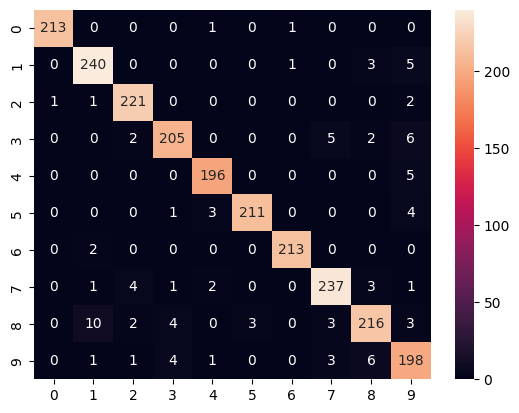

(31, 0.9564056939501779)

In [38]:
print("After Using Principal Component Analysis (PCA) for feature dimensionality reduction ---> Random Forest classifier")
performOperationPCA(x, y.values.ravel(), model_to_test=RandomForestClassifier(n_estimators=20, random_state=0), test_split=0.4, sampler=RandomOverSampler())

###SVM HYPER PARAMETER TUNING ( WINE DATASET )


####SVM LINEAR HYPER PARAMETER TUNING

In [39]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

def tune_svm_linear(X, y, tuning_method):
    """
    This function tunes the SVC model with a 'linear' kernel.
    """

    X_train, y_train, X_test, y_test = preprocessing(X, y, scaler=StandardScaler(), sampler=RandomOverSampler(), test_split=0.3)


    model = SVC(kernel='linear', probability=True)


    param_grid = {
        'C': [0.1, 1],
        'shrinking': [True],
        'probability': [True],
        'tol': [0.001],
        'cache_size': [200],
        'class_weight': ['balanced'],
        'verbose': [False],
        'max_iter': [-1],
        'decision_function_shape': ['ovr'],
        'break_ties': [False],
        'random_state': [10]
    }


    if tuning_method == 'grid':
        print("Using GridSearchCV...")
        search = GridSearchCV(model, param_grid, cv=3, verbose=1, n_jobs=-1, scoring='accuracy')
    elif tuning_method == 'random':
        print("Using RandomizedSearchCV...")
        search = RandomizedSearchCV(model, param_grid, n_iter=2, cv=3, verbose=1, n_jobs=-1, random_state=10, scoring='accuracy')
    else:
        print("Invalid tuning method specified. Please use 'grid' or 'random'.")
        return


    search.fit(X_train, y_train)


    print(f"Tuning Method: {tuning_method}")
    print("---------------------------------------")
    print(f"Best parameters found: {search.best_params_}")

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Maximum Accuracy Achieved on Test Data: {accuracy * 100:.2f}%")


    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=1))

    print("Confusion Matrix:")
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.show()


    generateROCAndAUC(X, y, test_size=0.3, model=best_model, scaler=StandardScaler(), sampler=RandomOverSampler())

    if accuracy >= 0.90:
        print("\n Accuracy of 90% or more achieved!")
    else:
        print("\n Accuracy is below 90%. You may need to adjust the parameter ranges or use a different model.")

    return search.best_params_




--- Calling tuning for Wine dataset with Random Search ---
Using RandomizedSearchCV...
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Tuning Method: random
---------------------------------------
Best parameters found: {'verbose': False, 'tol': 0.001, 'shrinking': True, 'random_state': 10, 'probability': True, 'max_iter': -1, 'decision_function_shape': 'ovr', 'class_weight': 'balanced', 'cache_size': 200, 'break_ties': False, 'C': 0.1}
Maximum Accuracy Achieved on Test Data: 92.59%

Classification Report:
              precision    recall  f1-score   support

           1       0.94      1.00      0.97        15
           2       1.00      0.85      0.92        27
           3       0.80      1.00      0.89        12

    accuracy                           0.93        54
   macro avg       0.91      0.95      0.93        54
weighted avg       0.94      0.93      0.93        54

Confusion Matrix:


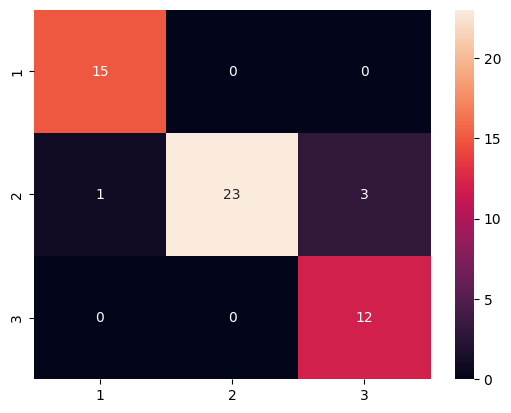

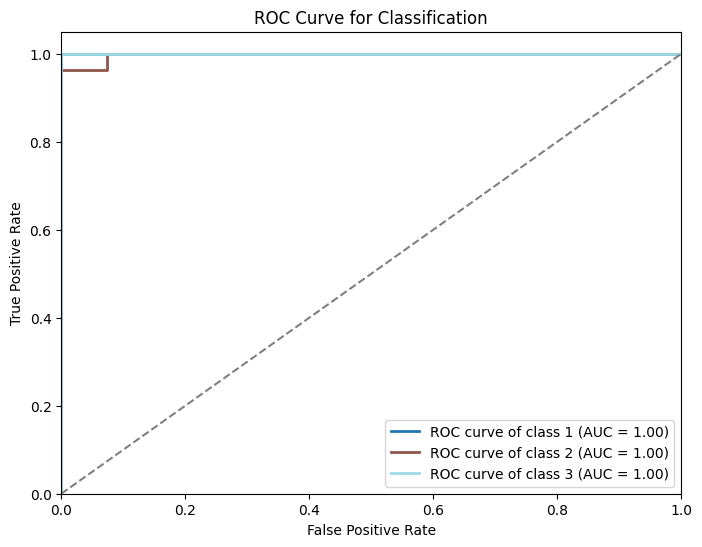


 Accuracy of 90% or more achieved!


{'verbose': False,
 'tol': 0.001,
 'shrinking': True,
 'random_state': 10,
 'probability': True,
 'max_iter': -1,
 'decision_function_shape': 'ovr',
 'class_weight': 'balanced',
 'cache_size': 200,
 'break_ties': False,
 'C': 0.1}

In [40]:
print("\n\n--- Calling tuning for Wine dataset with Random Search ---")
tune_svm_linear(X, Y.values.ravel(), tuning_method='random')

--- Calling tuning for Wine dataset with Grid Search ---
Using GridSearchCV...
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Tuning Method: grid
---------------------------------------
Best parameters found: {'C': 0.1, 'break_ties': False, 'cache_size': 200, 'class_weight': 'balanced', 'decision_function_shape': 'ovr', 'max_iter': -1, 'probability': True, 'random_state': 10, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Maximum Accuracy Achieved on Test Data: 92.59%

Classification Report:
              precision    recall  f1-score   support

           1       0.94      1.00      0.97        15
           2       1.00      0.85      0.92        27
           3       0.80      1.00      0.89        12

    accuracy                           0.93        54
   macro avg       0.91      0.95      0.93        54
weighted avg       0.94      0.93      0.93        54

Confusion Matrix:


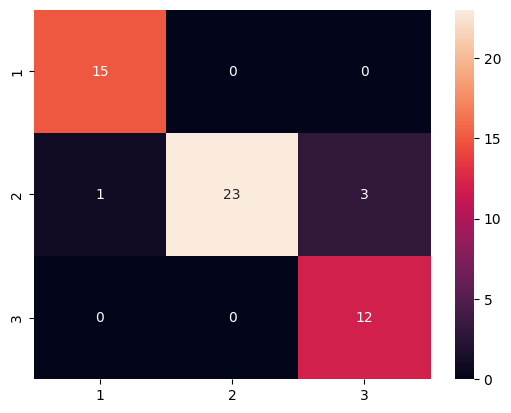

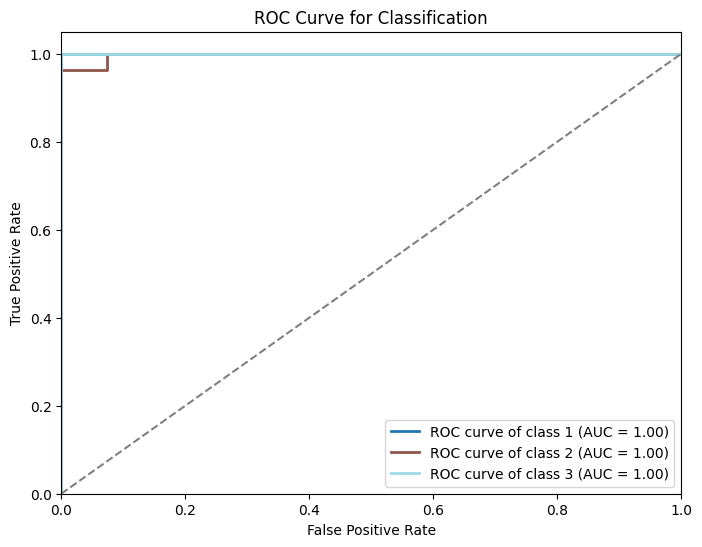


 Accuracy of 90% or more achieved!


{'C': 0.1,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': 'balanced',
 'decision_function_shape': 'ovr',
 'max_iter': -1,
 'probability': True,
 'random_state': 10,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [41]:
print("--- Calling tuning for Wine dataset with Grid Search ---")
tune_svm_linear(X, Y.values.ravel(), tuning_method='grid')

####SVM POLYNOMIAL HYPER PARAMETER RUNING

In [42]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import loguniform, uniform

def tune_svm_poly(X, y, tuning_method):
    """
    This function tunes the SVC model with a 'poly' kernel.
    """

    X_train, y_train, X_test, y_test = preprocessing(X, y, scaler=StandardScaler(), sampler=RandomOverSampler(), test_split=0.3)


    model = SVC(kernel='poly')


    param_grid = {
        'C': [0.1, 1],
        'degree': [2, 3],
        'gamma': ['scale', 'auto'],
        'coef0': [0.1, 0.5],
        'shrinking': [True],
        'probability': [False],
        'tol': [0.001],
        'cache_size': [200],
        'class_weight': ['balanced'],
        'verbose': [False],
        'max_iter': [-1],
        'decision_function_shape': ['ovr'],
        'break_ties': [False],
        'random_state': [10]
    }


    if tuning_method == 'grid':
        print("Using GridSearchCV...")
        search = GridSearchCV(model, param_grid, cv=3, verbose=1, n_jobs=-1, scoring='accuracy')
    elif tuning_method == 'random':
        print("Using RandomizedSearchCV...")
        search = RandomizedSearchCV(model, param_grid, n_iter=4, cv=3, verbose=1, n_jobs=-1, random_state=10, scoring='accuracy')
    else:
        print("Invalid tuning method specified. Please use 'grid' or 'random'.")
        return


    search.fit(X_train, y_train)


    print(f"Tuning Method: {tuning_method}")
    print("---------------------------------------")
    print(f"Best parameters found: {search.best_params_}")

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Maximum Accuracy Achieved on Test Data: {accuracy * 100:.2f}%")


    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=1))

    print("Confusion Matrix:")
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.show()

    generateROCAndAUC(X, y, test_size=0.3, model=best_model, scaler=StandardScaler(), sampler=RandomOverSampler())

    if accuracy >= 0.90:
        print("\n Accuracy of 90% or more achieved!")
    else:
        print("\n Accuracy is below 90%. You may need to adjust the parameter ranges or use a different model.")

    return search.best_params_




--- Calling tuning for Wine dataset with Random Search ---
Using RandomizedSearchCV...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Tuning Method: random
---------------------------------------
Best parameters found: {'verbose': False, 'tol': 0.001, 'shrinking': True, 'random_state': 10, 'probability': False, 'max_iter': -1, 'gamma': 'auto', 'degree': 2, 'decision_function_shape': 'ovr', 'coef0': 0.5, 'class_weight': 'balanced', 'cache_size': 200, 'break_ties': False, 'C': 0.1}
Maximum Accuracy Achieved on Test Data: 90.74%

Classification Report:
              precision    recall  f1-score   support

           1       0.93      0.93      0.93        15
           2       0.96      0.85      0.90        27
           3       0.80      1.00      0.89        12

    accuracy                           0.91        54
   macro avg       0.90      0.93      0.91        54
weighted avg       0.92      0.91      0.91        54

Confusion Matrix:


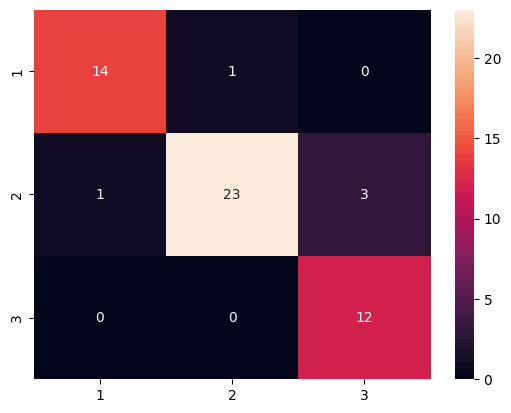

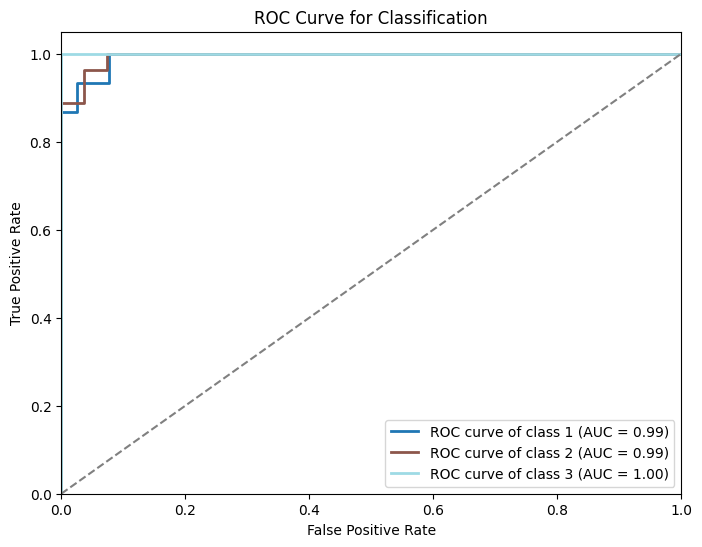


 Accuracy of 90% or more achieved!


{'verbose': False,
 'tol': 0.001,
 'shrinking': True,
 'random_state': 10,
 'probability': False,
 'max_iter': -1,
 'gamma': 'auto',
 'degree': 2,
 'decision_function_shape': 'ovr',
 'coef0': 0.5,
 'class_weight': 'balanced',
 'cache_size': 200,
 'break_ties': False,
 'C': 0.1}

In [43]:
print("\n\n--- Calling tuning for Wine dataset with Random Search ---")
tune_svm_poly(X, Y.values.ravel(), tuning_method='random')



--- Calling tuning for Wine dataset with Random Search ---
Using GridSearchCV...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Tuning Method: grid
---------------------------------------
Best parameters found: {'C': 1, 'break_ties': False, 'cache_size': 200, 'class_weight': 'balanced', 'coef0': 0.5, 'decision_function_shape': 'ovr', 'degree': 2, 'gamma': 'scale', 'max_iter': -1, 'probability': False, 'random_state': 10, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Maximum Accuracy Achieved on Test Data: 92.59%

Classification Report:
              precision    recall  f1-score   support

           1       0.94      1.00      0.97        15
           2       1.00      0.85      0.92        27
           3       0.80      1.00      0.89        12

    accuracy                           0.93        54
   macro avg       0.91      0.95      0.93        54
weighted avg       0.94      0.93      0.93        54

Confusion Matrix:


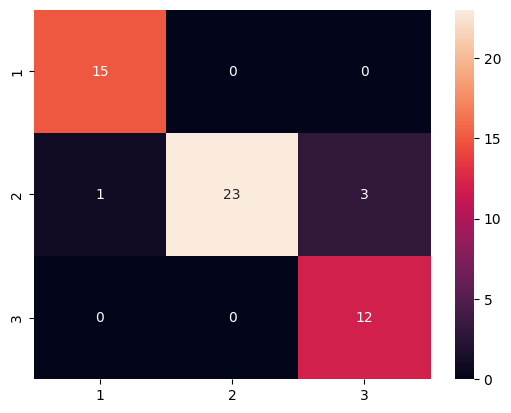

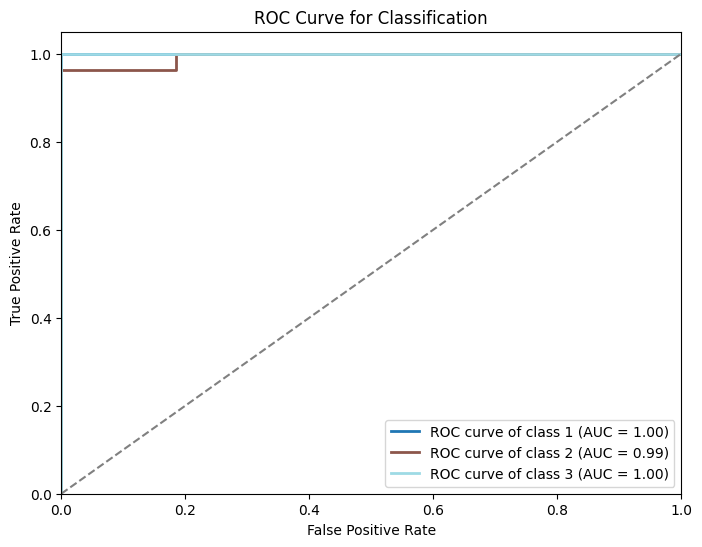


 Accuracy of 90% or more achieved!


{'C': 1,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': 'balanced',
 'coef0': 0.5,
 'decision_function_shape': 'ovr',
 'degree': 2,
 'gamma': 'scale',
 'max_iter': -1,
 'probability': False,
 'random_state': 10,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [44]:
print("\n\n--- Calling tuning for Wine dataset with Random Search ---")
tune_svm_poly(X, Y.values.ravel(), tuning_method='grid')

####SVM RBF HYPER PARAMETER TUNINH

In [45]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import loguniform, uniform

def tune_svm_rbf(X, y, tuning_method):
    """
    This function tunes the SVC model with a 'rbf' kernel.
    """

    X_train, y_train, X_test, y_test = preprocessing(X, y, scaler=StandardScaler(), sampler=RandomOverSampler(), test_split=0.3)


    model = SVC(kernel='rbf')


    param_grid = {
        'C': [0.1, 1],
        'gamma': ['scale', 'auto'],
        'shrinking': [True],
        'probability': [False],
        'tol': [0.001],
        'cache_size': [200],
        'class_weight': ['balanced'],
        'verbose': [False],
        'max_iter': [-1],
        'decision_function_shape': ['ovr'],
        'break_ties': [False],
        'random_state': [10]
    }


    if tuning_method == 'grid':
        print("Using GridSearchCV...")
        search = GridSearchCV(model, param_grid, cv=3, verbose=1, n_jobs=-1, scoring='accuracy')
    elif tuning_method == 'random':
        print("Using RandomizedSearchCV...")
        search = RandomizedSearchCV(model, param_grid, n_iter=4, cv=3, verbose=1, n_jobs=-1, random_state=10, scoring='accuracy')
    else:
        print("Invalid tuning method specified. Please use 'grid' or 'random'.")
        return


    search.fit(X_train, y_train)


    print(f"Tuning Method: {tuning_method}")
    print("---------------------------------------")
    print(f"Best parameters found: {search.best_params_}")

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Maximum Accuracy Achieved on Test Data: {accuracy * 100:.2f}%")


    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=1))

    print("Confusion Matrix:")
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.show()

    generateROCAndAUC(X, y, test_size=0.3, model=best_model, scaler=StandardScaler(), sampler=RandomOverSampler())

    if accuracy >= 0.90:
        print("\n Accuracy of 90% or more achieved!")
    else:
        print("\n Accuracy is below 90%. You may need to adjust the parameter ranges or use a different model.")

    return search.best_params_




--- Calling tuning for Wine dataset with Random Search ---
Using RandomizedSearchCV...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Tuning Method: random
---------------------------------------
Best parameters found: {'verbose': False, 'tol': 0.001, 'shrinking': True, 'random_state': 10, 'probability': False, 'max_iter': -1, 'gamma': 'scale', 'decision_function_shape': 'ovr', 'class_weight': 'balanced', 'cache_size': 200, 'break_ties': False, 'C': 0.1}
Maximum Accuracy Achieved on Test Data: 98.15%

Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        15
           2       1.00      0.96      0.98        27
           3       0.92      1.00      0.96        12

    accuracy                           0.98        54
   macro avg       0.97      0.99      0.98        54
weighted avg       0.98      0.98      0.98        54

Confusion Matrix:


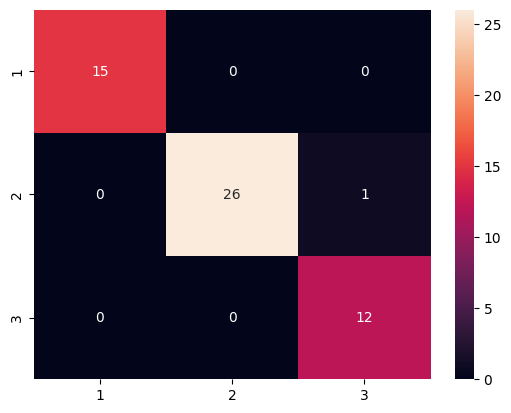

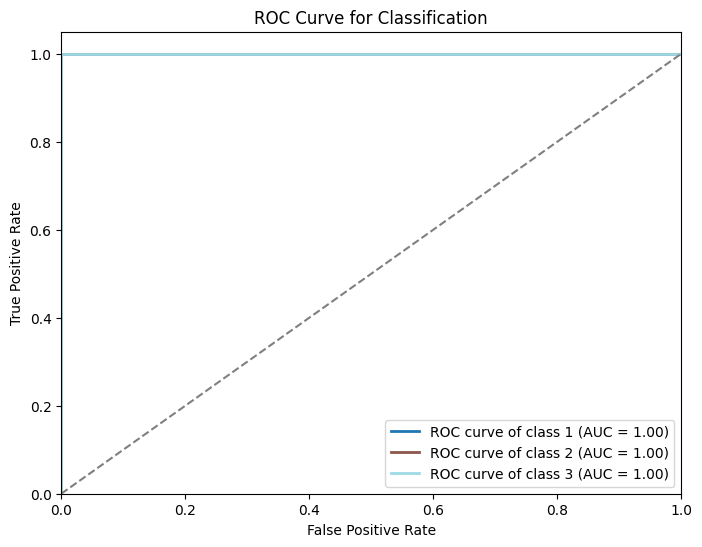


 Accuracy of 90% or more achieved!


{'verbose': False,
 'tol': 0.001,
 'shrinking': True,
 'random_state': 10,
 'probability': False,
 'max_iter': -1,
 'gamma': 'scale',
 'decision_function_shape': 'ovr',
 'class_weight': 'balanced',
 'cache_size': 200,
 'break_ties': False,
 'C': 0.1}

In [46]:
print("\n\n--- Calling tuning for Wine dataset with Random Search ---")
tune_svm_rbf(X, Y.values.ravel(), tuning_method='random')



--- Calling tuning for Wine dataset with Random Search ---
Using GridSearchCV...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Tuning Method: grid
---------------------------------------
Best parameters found: {'C': 0.1, 'break_ties': False, 'cache_size': 200, 'class_weight': 'balanced', 'decision_function_shape': 'ovr', 'gamma': 'scale', 'max_iter': -1, 'probability': False, 'random_state': 10, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Maximum Accuracy Achieved on Test Data: 98.15%

Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        15
           2       1.00      0.96      0.98        27
           3       0.92      1.00      0.96        12

    accuracy                           0.98        54
   macro avg       0.97      0.99      0.98        54
weighted avg       0.98      0.98      0.98        54

Confusion Matrix:


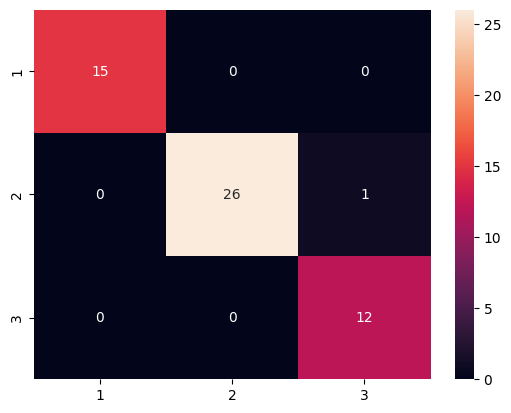

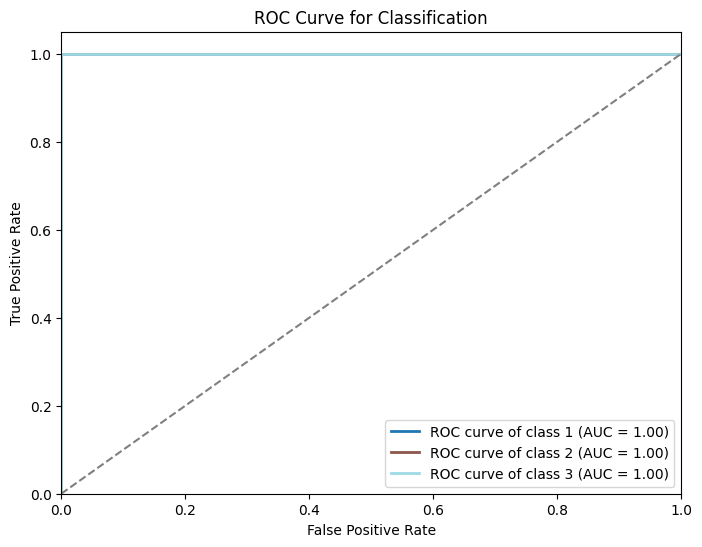


 Accuracy of 90% or more achieved!


{'C': 0.1,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': 'balanced',
 'decision_function_shape': 'ovr',
 'gamma': 'scale',
 'max_iter': -1,
 'probability': False,
 'random_state': 10,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [47]:
print("\n\n--- Calling tuning for Wine dataset with Random Search ---")
tune_svm_rbf(X, Y.values.ravel(), tuning_method='grid')

####SVM SIGMOID HYPER PARAMETER TUNING

In [48]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import loguniform, uniform

def tune_svm_sigmoid(X, y, tuning_method):
    """
    This function tunes the SVC model with a 'sigmoid' kernel.
    """

    X_train, y_train, X_test, y_test = preprocessing(X, y, scaler=StandardScaler(), sampler=RandomOverSampler(), test_split=0.3)


    model = SVC(kernel='sigmoid')


    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'gamma': [0.001, 0.01, 0.1, 1, 'scale', 'auto'],
        'coef0': [0, 0.1, 0.5, 1, 5, 10],
        'shrinking': [True],
        'probability': [False],
        'tol': [0.001],
        'cache_size': [200],
        'class_weight': ['balanced'],
        'verbose': [False],
        'max_iter': [-1],
        'decision_function_shape': ['ovr'],
        'break_ties': [False],
        'random_state': [10]
    }


    if tuning_method == 'grid':
        print("Using GridSearchCV...")
        search = GridSearchCV(model, param_grid, cv=3, verbose=1, n_jobs=-1, scoring='accuracy')
    elif tuning_method == 'random':
        print("Using RandomizedSearchCV...")
        search = RandomizedSearchCV(model, param_grid, n_iter=10, cv=3, verbose=1, n_jobs=-1, random_state=10, scoring='accuracy')
    else:
        print("Invalid tuning method specified. Please use 'grid' or 'random'.")
        return


    search.fit(X_train, y_train)


    print(f"Tuning Method: {tuning_method}")
    print("---------------------------------------")
    print(f"Best parameters found: {search.best_params_}")

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Maximum Accuracy Achieved on Test Data: {accuracy * 100:.2f}%")


    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=1))

    print("Confusion Matrix:")
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.show()

    generateROCAndAUC(X, y, test_size=0.3, model=best_model, scaler=StandardScaler(), sampler=RandomOverSampler())

    if accuracy >= 0.90:
        print("\n Accuracy of 90% or more achieved!")
    else:
        print("\n Accuracy is below 90%. You may need to adjust the parameter ranges or use a different model.")

    return search.best_params_




--- Calling tuning for Wine dataset with Random Search ---
Using RandomizedSearchCV...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Tuning Method: random
---------------------------------------
Best parameters found: {'verbose': False, 'tol': 0.001, 'shrinking': True, 'random_state': 10, 'probability': False, 'max_iter': -1, 'gamma': 0.001, 'decision_function_shape': 'ovr', 'coef0': 0.5, 'class_weight': 'balanced', 'cache_size': 200, 'break_ties': False, 'C': 10}
Maximum Accuracy Achieved on Test Data: 92.59%

Classification Report:
              precision    recall  f1-score   support

           1       0.94      1.00      0.97        15
           2       1.00      0.85      0.92        27
           3       0.80      1.00      0.89        12

    accuracy                           0.93        54
   macro avg       0.91      0.95      0.93        54
weighted avg       0.94      0.93      0.93        54

Confusion Matrix:


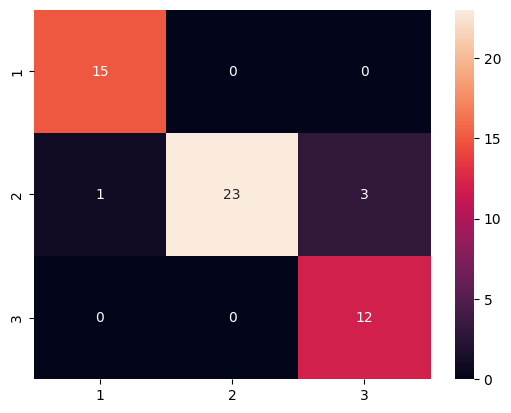

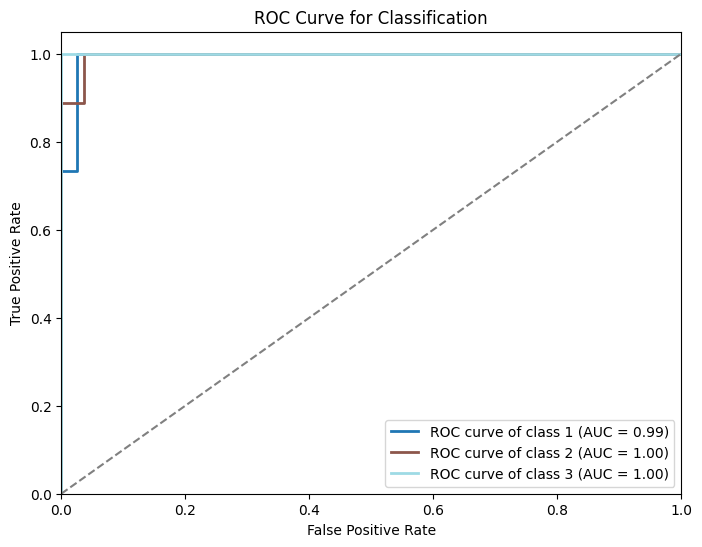


 Accuracy of 90% or more achieved!


{'verbose': False,
 'tol': 0.001,
 'shrinking': True,
 'random_state': 10,
 'probability': False,
 'max_iter': -1,
 'gamma': 0.001,
 'decision_function_shape': 'ovr',
 'coef0': 0.5,
 'class_weight': 'balanced',
 'cache_size': 200,
 'break_ties': False,
 'C': 10}

In [49]:
print("\n\n--- Calling tuning for Wine dataset with Random Search ---")
tune_svm_sigmoid(X, Y.values.ravel(), tuning_method='random')



--- Calling tuning for Wine dataset with Random Search ---
Using GridSearchCV...
Fitting 3 folds for each of 180 candidates, totalling 540 fits
Tuning Method: grid
---------------------------------------
Best parameters found: {'C': 1, 'break_ties': False, 'cache_size': 200, 'class_weight': 'balanced', 'coef0': 0, 'decision_function_shape': 'ovr', 'gamma': 0.01, 'max_iter': -1, 'probability': False, 'random_state': 10, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Maximum Accuracy Achieved on Test Data: 92.59%

Classification Report:
              precision    recall  f1-score   support

           1       0.94      1.00      0.97        15
           2       1.00      0.85      0.92        27
           3       0.80      1.00      0.89        12

    accuracy                           0.93        54
   macro avg       0.91      0.95      0.93        54
weighted avg       0.94      0.93      0.93        54

Confusion Matrix:


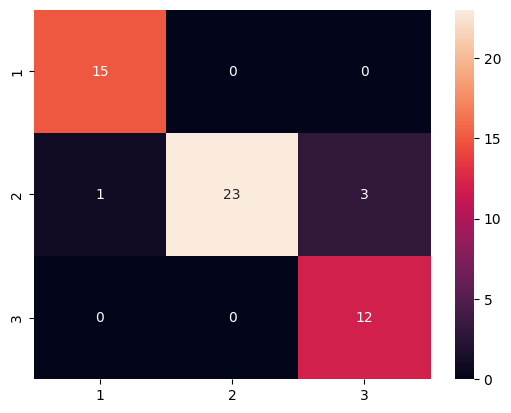

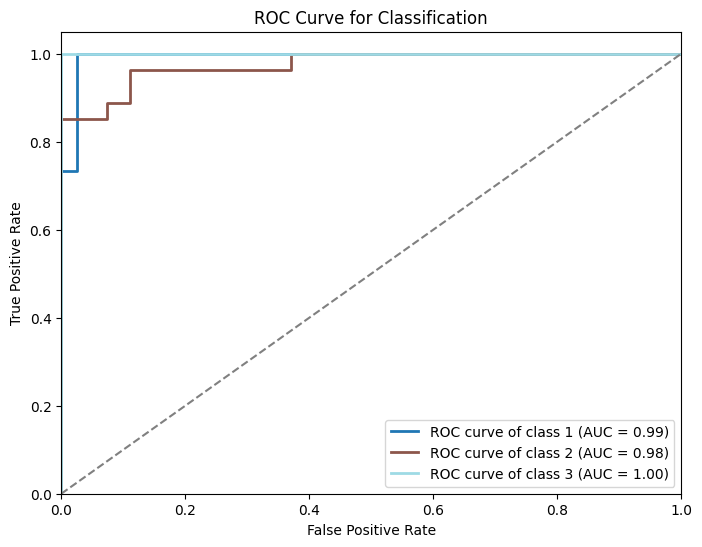


 Accuracy of 90% or more achieved!


{'C': 1,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': 'balanced',
 'coef0': 0,
 'decision_function_shape': 'ovr',
 'gamma': 0.01,
 'max_iter': -1,
 'probability': False,
 'random_state': 10,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [50]:
print("\n\n--- Calling tuning for Wine dataset with Random Search ---")
tune_svm_sigmoid(X, Y.values.ravel(), tuning_method='grid')

###SVM HYPER PARAMETER TUNING ( HANDWRITTEN DIGIT DATASET )

####SVM LINEAR HYPER PARAMETER TUNING



--- Calling tuning for HD dataset with Random Search ---
Using RandomizedSearchCV...
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Tuning Method: random
---------------------------------------
Best parameters found: {'verbose': False, 'tol': 0.001, 'shrinking': True, 'random_state': 10, 'probability': True, 'max_iter': -1, 'decision_function_shape': 'ovr', 'class_weight': 'balanced', 'cache_size': 200, 'break_ties': False, 'C': 0.1}
Maximum Accuracy Achieved on Test Data: 98.16%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       171
           1       0.95      0.98      0.97       192
           2       0.98      1.00      0.99       173
           3       0.98      0.97      0.98       179
           4       0.96      0.99      0.98       147
           5       1.00      0.99      1.00       158
           6       1.00      0.97      0.99       144
           7       0.99      0.98      0.99 

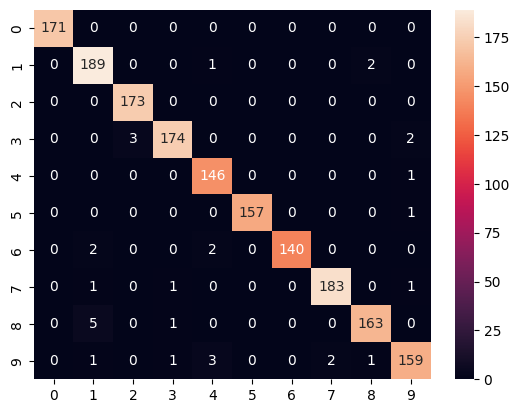

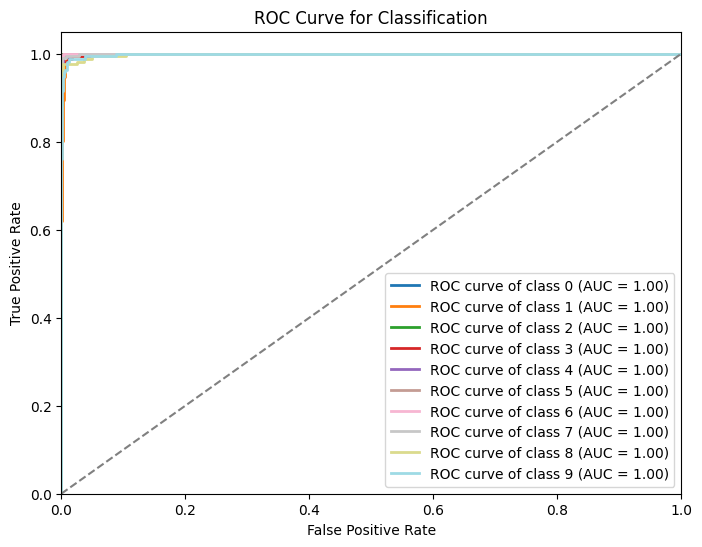


 Accuracy of 90% or more achieved!


{'verbose': False,
 'tol': 0.001,
 'shrinking': True,
 'random_state': 10,
 'probability': True,
 'max_iter': -1,
 'decision_function_shape': 'ovr',
 'class_weight': 'balanced',
 'cache_size': 200,
 'break_ties': False,
 'C': 0.1}

In [51]:
print("\n\n--- Calling tuning for HD dataset with Random Search ---")
tune_svm_linear(x, y.values.ravel(), tuning_method='random')



--- Calling tuning for HD dataset with Grid Search ---
Using GridSearchCV...
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Tuning Method: grid
---------------------------------------
Best parameters found: {'C': 0.1, 'break_ties': False, 'cache_size': 200, 'class_weight': 'balanced', 'decision_function_shape': 'ovr', 'max_iter': -1, 'probability': True, 'random_state': 10, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Maximum Accuracy Achieved on Test Data: 98.16%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       171
           1       0.95      0.98      0.97       192
           2       0.99      1.00      1.00       173
           3       0.98      0.98      0.98       179
           4       0.96      0.99      0.98       147
           5       1.00      0.99      1.00       158
           6       1.00      0.97      0.99       144
           7       0.99      0.98      0.99       186


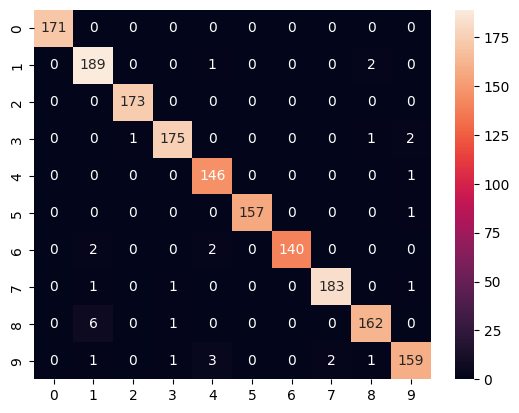

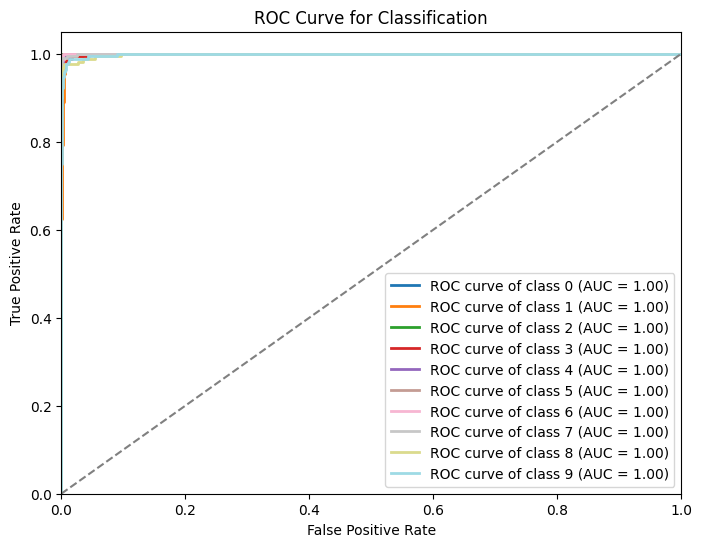


 Accuracy of 90% or more achieved!


{'C': 0.1,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': 'balanced',
 'decision_function_shape': 'ovr',
 'max_iter': -1,
 'probability': True,
 'random_state': 10,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [52]:
print("\n\n--- Calling tuning for HD dataset with Grid Search ---")
tune_svm_linear(x, y.values.ravel(), tuning_method='grid')

####SVM POLYNOMIAL HYPER PARAMETER TUNING



--- Calling tuning for HD dataset with Grid Search ---
Using RandomizedSearchCV...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Tuning Method: random
---------------------------------------
Best parameters found: {'verbose': False, 'tol': 0.001, 'shrinking': True, 'random_state': 10, 'probability': False, 'max_iter': -1, 'gamma': 'scale', 'degree': 3, 'decision_function_shape': 'ovr', 'coef0': 0.5, 'class_weight': 'balanced', 'cache_size': 200, 'break_ties': False, 'C': 1}
Maximum Accuracy Achieved on Test Data: 98.87%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       171
           1       0.97      0.98      0.97       192
           2       0.99      1.00      0.99       173
           3       0.99      0.99      0.99       179
           4       1.00      0.99      1.00       147
           5       1.00      0.99      1.00       158
           6       1.00      0.99      0.99       144
 

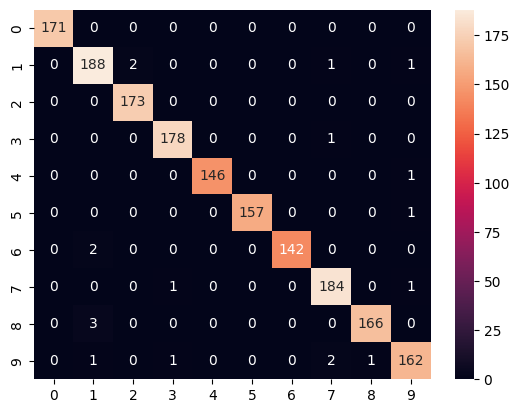

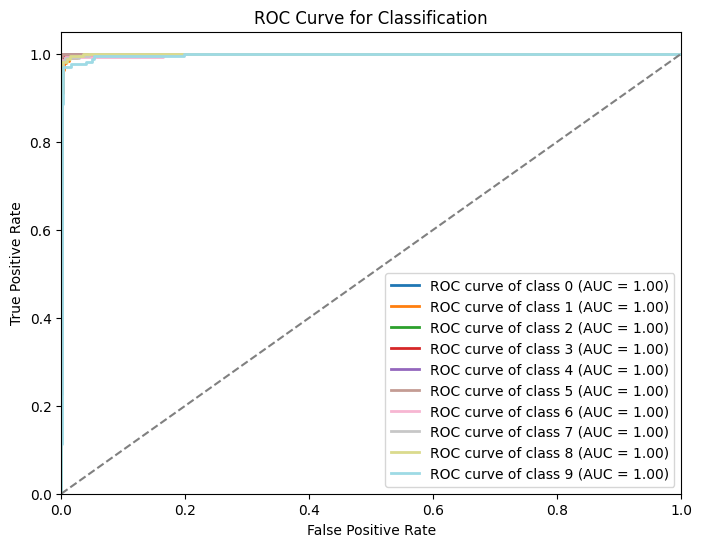


 Accuracy of 90% or more achieved!


{'verbose': False,
 'tol': 0.001,
 'shrinking': True,
 'random_state': 10,
 'probability': False,
 'max_iter': -1,
 'gamma': 'scale',
 'degree': 3,
 'decision_function_shape': 'ovr',
 'coef0': 0.5,
 'class_weight': 'balanced',
 'cache_size': 200,
 'break_ties': False,
 'C': 1}

In [53]:
print("\n\n--- Calling tuning for HD dataset with Grid Search ---")
tune_svm_poly(x, y.values.ravel(), tuning_method='random')



--- Calling tuning for HD dataset with Grid Search ---
Using GridSearchCV...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Tuning Method: grid
---------------------------------------
Best parameters found: {'C': 1, 'break_ties': False, 'cache_size': 200, 'class_weight': 'balanced', 'coef0': 0.5, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'max_iter': -1, 'probability': False, 'random_state': 10, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Maximum Accuracy Achieved on Test Data: 98.81%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       171
           1       0.96      0.98      0.97       192
           2       0.99      1.00      0.99       173
           3       0.99      1.00      0.99       179
           4       1.00      0.99      1.00       147
           5       1.00      0.99      1.00       158
           6       1.00      0.99      0.99       144
        

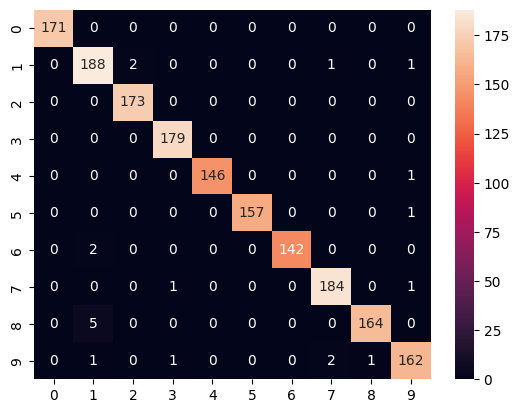

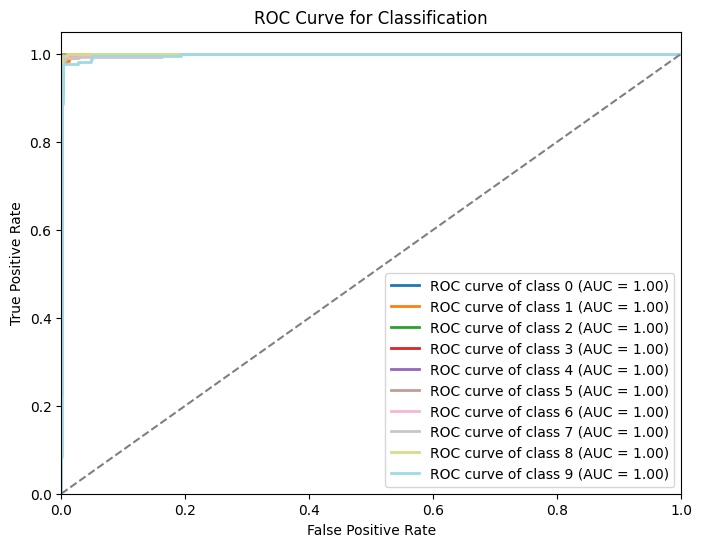


 Accuracy of 90% or more achieved!


{'C': 1,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': 'balanced',
 'coef0': 0.5,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'max_iter': -1,
 'probability': False,
 'random_state': 10,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [54]:
print("\n\n--- Calling tuning for HD dataset with Grid Search ---")
tune_svm_poly(x, y.values.ravel(), tuning_method='grid')

####SVM RBF HYPER PARAMETER TUNING



--- Calling tuning for HD dataset with Grid Search ---
Using RandomizedSearchCV...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Tuning Method: random
---------------------------------------
Best parameters found: {'verbose': False, 'tol': 0.001, 'shrinking': True, 'random_state': 10, 'probability': False, 'max_iter': -1, 'gamma': 'scale', 'decision_function_shape': 'ovr', 'class_weight': 'balanced', 'cache_size': 200, 'break_ties': False, 'C': 1}
Maximum Accuracy Achieved on Test Data: 98.10%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       171
           1       0.95      0.98      0.97       192
           2       0.98      1.00      0.99       173
           3       0.99      0.98      0.99       179
           4       0.97      0.99      0.98       147
           5       1.00      1.00      1.00       158
           6       0.99      0.98      0.99       144
           7       0.97     

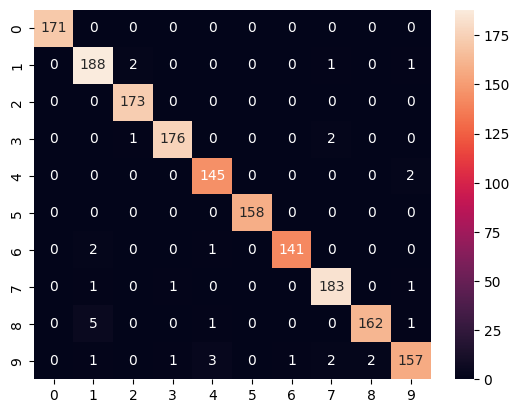

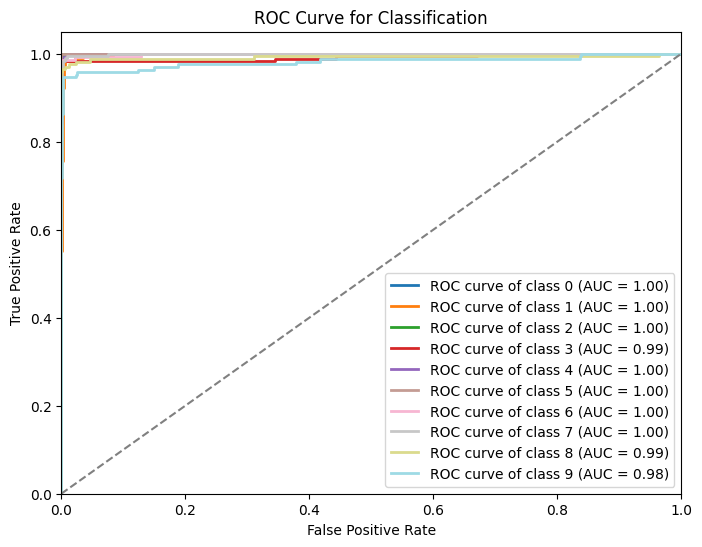


 Accuracy of 90% or more achieved!


{'verbose': False,
 'tol': 0.001,
 'shrinking': True,
 'random_state': 10,
 'probability': False,
 'max_iter': -1,
 'gamma': 'scale',
 'decision_function_shape': 'ovr',
 'class_weight': 'balanced',
 'cache_size': 200,
 'break_ties': False,
 'C': 1}

In [55]:
print("\n\n--- Calling tuning for HD dataset with Grid Search ---")
tune_svm_rbf(x, y.values.ravel(), tuning_method='random')



--- Calling tuning for HD dataset with Grid Search ---
Using GridSearchCV...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Tuning Method: grid
---------------------------------------
Best parameters found: {'C': 1, 'break_ties': False, 'cache_size': 200, 'class_weight': 'balanced', 'decision_function_shape': 'ovr', 'gamma': 'scale', 'max_iter': -1, 'probability': False, 'random_state': 10, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Maximum Accuracy Achieved on Test Data: 98.04%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       171
           1       0.95      0.98      0.97       192
           2       0.98      1.00      0.99       173
           3       0.99      0.98      0.99       179
           4       0.97      0.99      0.98       147
           5       1.00      1.00      1.00       158
           6       0.99      0.98      0.99       144
           7       0.97      0.98   

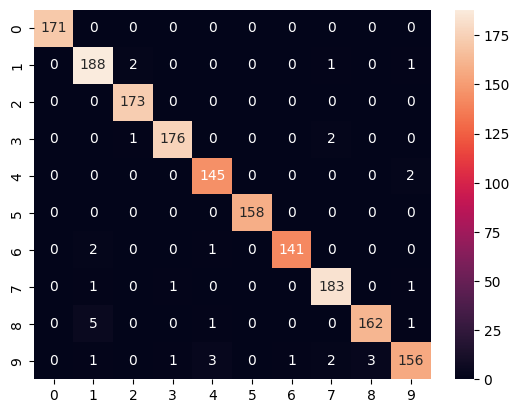

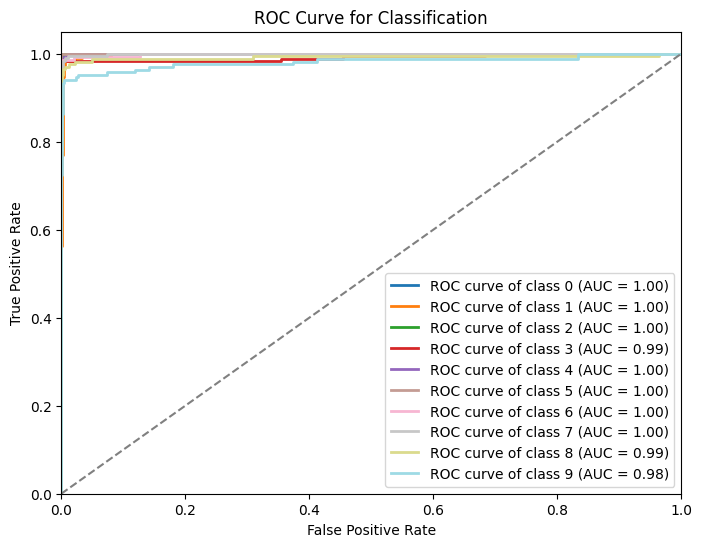


 Accuracy of 90% or more achieved!


{'C': 1,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': 'balanced',
 'decision_function_shape': 'ovr',
 'gamma': 'scale',
 'max_iter': -1,
 'probability': False,
 'random_state': 10,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [56]:
print("\n\n--- Calling tuning for HD dataset with Grid Search ---")
tune_svm_rbf(x, y.values.ravel(), tuning_method='grid')

####SVM SIGMOID HYPER PARAMETER TUNING



--- Calling tuning for HD dataset with Grid Search ---
Using RandomizedSearchCV...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Tuning Method: random
---------------------------------------
Best parameters found: {'verbose': False, 'tol': 0.001, 'shrinking': True, 'random_state': 10, 'probability': False, 'max_iter': -1, 'gamma': 0.001, 'decision_function_shape': 'ovr', 'coef0': 0.1, 'class_weight': 'balanced', 'cache_size': 200, 'break_ties': False, 'C': 100}
Maximum Accuracy Achieved on Test Data: 97.92%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       171
           1       0.94      0.98      0.96       192
           2       0.98      0.99      0.99       173
           3       0.98      0.97      0.98       179
           4       0.96      0.99      0.98       147
           5       1.00      0.99      0.99       158
           6       1.00      0.97      0.99       144
           7 

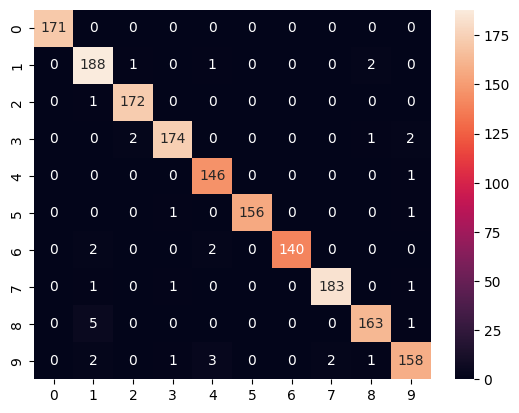

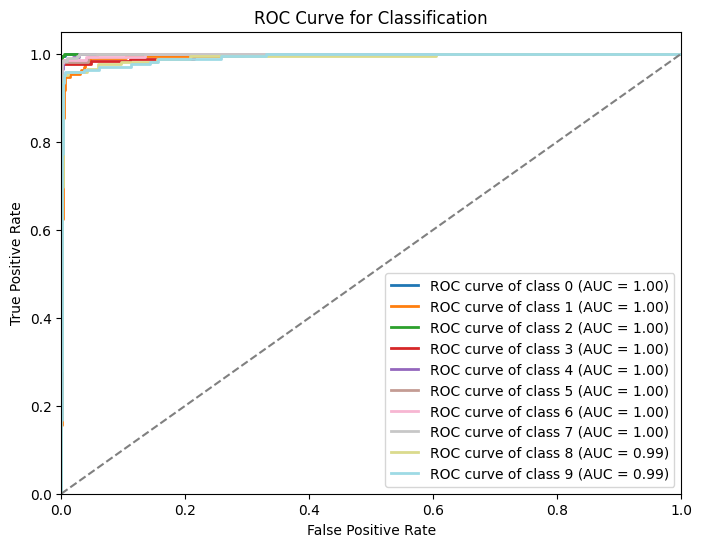


 Accuracy of 90% or more achieved!


{'verbose': False,
 'tol': 0.001,
 'shrinking': True,
 'random_state': 10,
 'probability': False,
 'max_iter': -1,
 'gamma': 0.001,
 'decision_function_shape': 'ovr',
 'coef0': 0.1,
 'class_weight': 'balanced',
 'cache_size': 200,
 'break_ties': False,
 'C': 100}

In [57]:
print("\n\n--- Calling tuning for HD dataset with Grid Search ---")
tune_svm_sigmoid(x, y.values.ravel(), tuning_method='random')



--- Calling tuning for HD dataset with Grid Search ---
Using GridSearchCV with a smaller parameter grid...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Tuning Method: grid
---------------------------------------
Best parameters found: {'C': 0.1, 'break_ties': False, 'cache_size': 200, 'class_weight': 'balanced', 'coef0': 0, 'decision_function_shape': 'ovr', 'gamma': 'scale', 'max_iter': -1, 'probability': True, 'random_state': 10, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Maximum Accuracy Achieved on Test Data: 94.13%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       171
           1       0.88      0.85      0.87       192
           2       0.91      0.97      0.94       173
           3       0.99      0.93      0.96       179
           4       0.94      0.95      0.94       147
           5       0.98      0.97      0.98       158
           6       0.99      0.97      0.98    

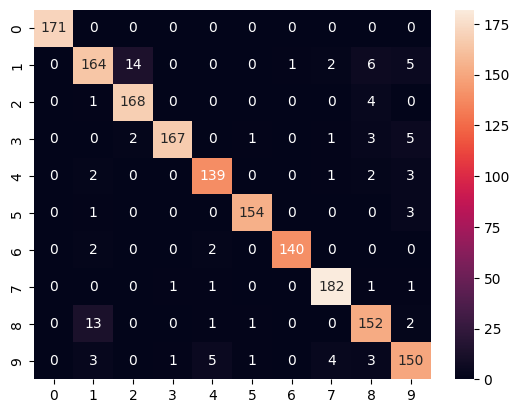

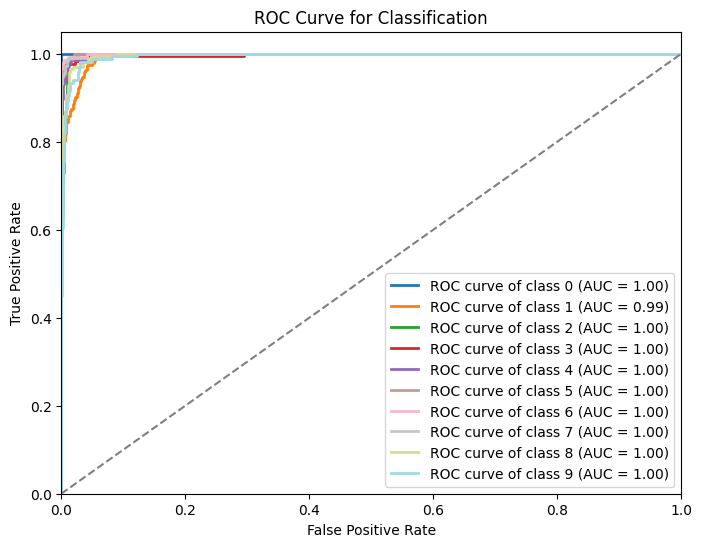


✅ Accuracy of 90% or more achieved!


{'C': 0.1,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': 'balanced',
 'coef0': 0,
 'decision_function_shape': 'ovr',
 'gamma': 'scale',
 'max_iter': -1,
 'probability': True,
 'random_state': 10,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [58]:

def tune_svm_sigmoid_small(X, y, tuning_method):
    # This function tunes the SVC model with a 'sigmoid' kernel using a reduced parameter grid.
    # Preprocess the data.
    X_train, y_train, X_test, y_test = preprocessing(X, y, scaler=StandardScaler(), sampler=RandomOverSampler(), test_split=0.3)

    # Initialize the SVC model.
    model = SVC(kernel='sigmoid')

    # Define a smaller parameter grid to speed up execution.
    param_grid = {
        'C': [0.1, 1],
        'gamma': ['scale', 0.1],
        'coef0': [0, 0.1],
        'shrinking': [True],
        'probability': [True], # Set to True to allow for ROC curve plotting
        'tol': [0.001],
        'cache_size': [200],
        'class_weight': ['balanced'],
        'verbose': [False],
        'max_iter': [-1],
        'decision_function_shape': ['ovr'],
        'break_ties': [False],
        'random_state': [10]
    }

    # Select the tuning method.
    if tuning_method == 'grid':
        print("Using GridSearchCV with a smaller parameter grid...")
        search = GridSearchCV(model, param_grid, cv=3, verbose=1, n_jobs=-1, scoring='accuracy')
    elif tuning_method == 'random':
        print("Using RandomizedSearchCV with a smaller parameter grid...")
        search = RandomizedSearchCV(model, param_grid, n_iter=4, cv=3, verbose=1, n_jobs=-1, random_state=10, scoring='accuracy')
    else:
        print("Invalid tuning method specified. Please use 'grid' or 'random'.")
        return

    # Perform the search and fit the model.
    search.fit(X_train, y_train)

    # Print the results.
    print(f"Tuning Method: {tuning_method}")
    print("---------------------------------------")
    print(f"Best parameters found: {search.best_params_}")

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Maximum Accuracy Achieved on Test Data: {accuracy * 100:.2f}%")
    # Optional: Print the full classification report and confusion matrix for the best model.
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=1))

    print("Confusion Matrix:")
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.show()

    # Call the ROC function here
    generateROCAndAUC(X, y, test_size=0.3, model=best_model, scaler=StandardScaler(), sampler=RandomOverSampler())

    if accuracy >= 0.90:
        print("\n✅ Accuracy of 90% or more achieved!")
    else:
        print("\n❌ Accuracy is below 90%. You may need to adjust the parameter ranges or use a different model.")

    return search.best_params_


# Assuming 'x' and 'y' for the HD dataset are already loaded
Hd = fetch_ucirepo(id=80)
x=pd.DataFrame(Hd.data.features,columns=Hd.data.feature_names)
y=pd.DataFrame(Hd.data.targets,columns=Hd.data.target_names)

print("\n\n--- Calling tuning for HD dataset with Grid Search ---")
tune_svm_sigmoid_small(x, y.values.ravel(), tuning_method='grid')


###MLP HYPER PARAMETER TUNING ( WINE DATASET )

In [59]:
def tune_mlp_all_params(X, y, tuning_method):
    # This function tunes the MLPClassifier using the specified tuning method.
    X_train, y_train, X_test, y_test = preprocessing(X, y, scaler=StandardScaler(), sampler=RandomOverSampler(), test_split=0.3)
    model = MLPClassifier(random_state=10)

    param_grid = {
        'hidden_layer_sizes': [(100,)], # Number of neurons in the hidden layers.
        'activation': ['relu', 'tanh'], # Activation function for the hidden layer.
        'solver': ['adam', 'sgd'], # The solver for weight optimization.
        'alpha': [0.0001], # L2 penalty (regularization term) parameter.
        'batch_size': ['auto'], # Size of minibatches for stochastic optimizers.
        'learning_rate': ['constant', 'adaptive'], # Learning rate schedule for weight updates.
        'learning_rate_init': [0.001], # The initial learning rate.
        'power_t': [0.5], # Exponent for inverse scaling learning rate.
        'max_iter': [1000], # Maximum number of iterations.
        'shuffle': [True], # Whether to shuffle samples in each iteration.
        'tol': [1e-4], # Tolerance for stopping criterion.
        'verbose': [False], # Whether to print progress messages to stdout.
        'warm_start': [False], # Reuse the previous solution for initialization.
        'momentum': [0.9], # Momentum for gradient descent update.
        'nesterovs_momentum': [True], # Whether to use Nesterov’s momentum.
        'early_stopping': [False], # Whether to use early stopping to terminate training.
        'validation_fraction': [0.1], # Proportion of training data for validation.
        'beta_1': [0.9], # Exponential decay rate for estimates of first moment vector in adam.
        'beta_2': [0.999], # Exponential decay rate for estimates of second moment vector in adam.
        'epsilon': [1e-8], # Value for numerical stability in adam.
        'n_iter_no_change': [10], # Maximum number of epochs to not meet tol improvement.
        'max_fun': [15000], # Maximum number of loss function calls.
    }

    if tuning_method == 'grid':
        print("Using GridSearchCV...")
        search = GridSearchCV(model, param_grid, cv=3, verbose=1, n_jobs=-1, scoring='accuracy')
    elif tuning_method == 'random':
        print("Using RandomizedSearchCV...")
        search = RandomizedSearchCV(model, param_grid, n_iter=4, cv=3, verbose=1, n_jobs=-1, random_state=10, scoring='accuracy')
    else:
        print("Invalid tuning method specified. Please use 'grid' or 'random'.")
        return

    search.fit(X_train, y_train)
    print(f"Tuning Method: {tuning_method}")
    print("---------------------------------------")
    print(f"Best parameters found: {search.best_params_}")

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Maximum Accuracy Achieved on Test Data: {accuracy * 100:.2f}%")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=1))

    print("Confusion Matrix:")
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.show()

    if accuracy >= 0.90:
        print("\nAccuracy of 90% or more achieved!")
    else:
        print("\nAccuracy is below 90%. You may need to adjust the parameter ranges or use a different model.")

    return search.best_params_



--- Calling tuning for Wine dataset with Random Search ---
Using RandomizedSearchCV...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Tuning Method: random
---------------------------------------
Best parameters found: {'warm_start': False, 'verbose': False, 'validation_fraction': 0.1, 'tol': 0.0001, 'solver': 'adam', 'shuffle': True, 'power_t': 0.5, 'nesterovs_momentum': True, 'n_iter_no_change': 10, 'momentum': 0.9, 'max_iter': 1000, 'max_fun': 15000, 'learning_rate_init': 0.001, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (100,), 'epsilon': 1e-08, 'early_stopping': False, 'beta_2': 0.999, 'beta_1': 0.9, 'batch_size': 'auto', 'alpha': 0.0001, 'activation': 'relu'}
Maximum Accuracy Achieved on Test Data: 94.44%

Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        15
           2       1.00      0.89      0.94        27
           3       0.80      1.00      0.89        12

    accuracy  

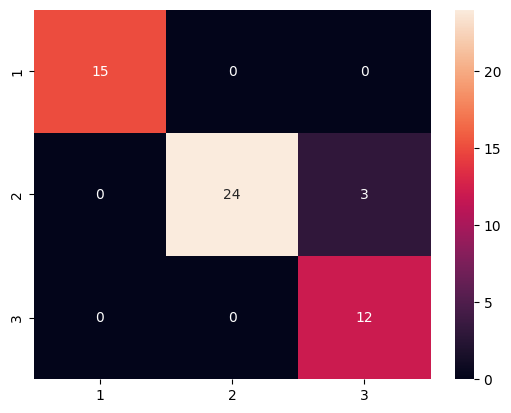


Accuracy of 90% or more achieved!


{'warm_start': False,
 'verbose': False,
 'validation_fraction': 0.1,
 'tol': 0.0001,
 'solver': 'adam',
 'shuffle': True,
 'power_t': 0.5,
 'nesterovs_momentum': True,
 'n_iter_no_change': 10,
 'momentum': 0.9,
 'max_iter': 1000,
 'max_fun': 15000,
 'learning_rate_init': 0.001,
 'learning_rate': 'adaptive',
 'hidden_layer_sizes': (100,),
 'epsilon': 1e-08,
 'early_stopping': False,
 'beta_2': 0.999,
 'beta_1': 0.9,
 'batch_size': 'auto',
 'alpha': 0.0001,
 'activation': 'relu'}

In [60]:
print("\n\n--- Calling tuning for Wine dataset with Random Search ---")
tune_mlp_all_params(X, Y.values.ravel(), tuning_method='random')

--- Calling tuning for Wine dataset with Grid Search ---
Using GridSearchCV...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Tuning Method: grid
---------------------------------------
Best parameters found: {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 1000, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}
Maximum Accuracy Achieved on Test Data: 94.44%

Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        15
           2       1.00      0.89      0.94        27
           3       0.80      1.00      0.89        12

    accuracy              

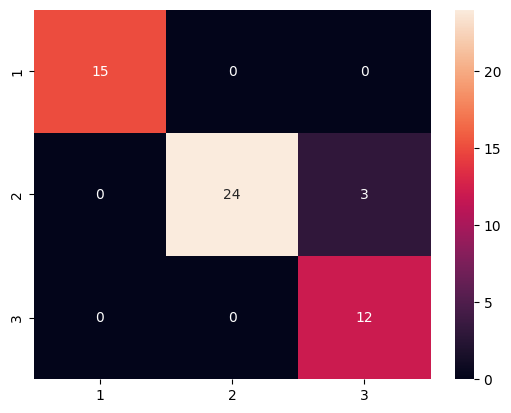


Accuracy of 90% or more achieved!


{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 1000,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [61]:
print("--- Calling tuning for Wine dataset with Grid Search ---")
tune_mlp_all_params(X, Y.values.ravel(), tuning_method='grid')

###MLP HYPER PARAMETER TUNING ( HANDWRITTEN DIGIT DATASET )



--- Calling tuning for HD dataset with Random Search ---
Using RandomizedSearchCV...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Tuning Method: random
---------------------------------------
Best parameters found: {'warm_start': False, 'verbose': False, 'validation_fraction': 0.1, 'tol': 0.0001, 'solver': 'adam', 'shuffle': True, 'power_t': 0.5, 'nesterovs_momentum': True, 'n_iter_no_change': 10, 'momentum': 0.9, 'max_iter': 1000, 'max_fun': 15000, 'learning_rate_init': 0.001, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (100,), 'epsilon': 1e-08, 'early_stopping': False, 'beta_2': 0.999, 'beta_1': 0.9, 'batch_size': 'auto', 'alpha': 0.0001, 'activation': 'relu'}
Maximum Accuracy Achieved on Test Data: 98.10%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       171
           1       0.96      0.96      0.96       192
           2       0.98      0.99      0.98       173
           3     

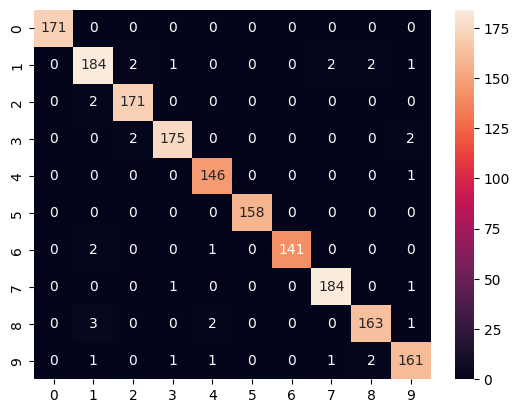


Accuracy of 90% or more achieved!


{'warm_start': False,
 'verbose': False,
 'validation_fraction': 0.1,
 'tol': 0.0001,
 'solver': 'adam',
 'shuffle': True,
 'power_t': 0.5,
 'nesterovs_momentum': True,
 'n_iter_no_change': 10,
 'momentum': 0.9,
 'max_iter': 1000,
 'max_fun': 15000,
 'learning_rate_init': 0.001,
 'learning_rate': 'adaptive',
 'hidden_layer_sizes': (100,),
 'epsilon': 1e-08,
 'early_stopping': False,
 'beta_2': 0.999,
 'beta_1': 0.9,
 'batch_size': 'auto',
 'alpha': 0.0001,
 'activation': 'relu'}

In [62]:
print("\n\n--- Calling tuning for HD dataset with Random Search ---")
tune_mlp_all_params(x, y.values.ravel(), tuning_method='random')



--- Calling tuning for HD dataset with Grid Search ---
Using GridSearchCV...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Tuning Method: grid
---------------------------------------
Best parameters found: {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 1000, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}
Maximum Accuracy Achieved on Test Data: 98.22%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       171
           1       0.95      0.96      0.96       192
           2       0.97      0.99      0.98       173
           3       0.98    

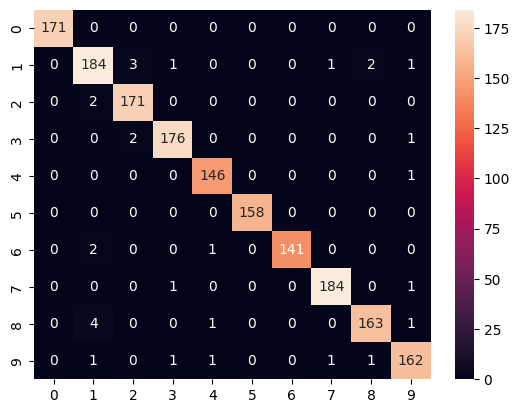


Accuracy of 90% or more achieved!


{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 1000,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [63]:
print("\n\n--- Calling tuning for HD dataset with Grid Search ---")
tune_mlp_all_params(x, y.values.ravel(), tuning_method='grid')

###RANDOM FOREST CLASSIFIER HYPER PARAMETER TUNING ( WINE DATASET )


In [64]:
def tune_random_forest_all_params(X, y, tuning_method):



    X_train, y_train, X_test, y_test = preprocessing(X, y, scaler=StandardScaler(), sampler=RandomOverSampler(), test_split=0.3)


    model = RandomForestClassifier()

    # Define a smaller, efficient parameter grid for both tuning methods.
    param_grid = {
        'n_estimators': [50],  # Number of trees in the forest.
        'criterion': ['gini', 'entropy'], # The function to measure the quality of a split.
        'max_depth': [None,20],  # Maximum depth of the tree.
        'min_samples_split': [5],  # Minimum number of samples required to split an internal node.
        'min_samples_leaf': [1], # Minimum number of samples required to be at a leaf node.
        'min_weight_fraction_leaf': [0.0], # The minimum weighted fraction of the sum total of weights required to be at a leaf node.
        'max_features': ['sqrt', 'log2'], # The number of features to consider when looking for the best split.
        'max_leaf_nodes': [None,20],  # Grow trees with max_leaf_nodes in best-first fashion.
        'min_impurity_decrease': [0.0], # A node will be split if this split induces a decrease of the impurity greater than or equal to this value.
        'bootstrap': [True],  # Whether bootstrap samples are used when building trees.
        'oob_score': [False], # Whether to use out-of-bag samples to estimate the generalization score.
        'n_jobs': [-1], # The number of jobs to run in parallel.
        'random_state': [10], # Controls the randomness of the model for reproducibility.
        'verbose': [0], # Controls the verbosity of the output during fitting.
        'warm_start': [False], # When set to True, reuse the solution of the previous call to fit and add more estimators to the ensemble.
        'class_weight': [None, 'balanced'], # Weights associated with classes.
        'ccp_alpha': [0.0], # Complexity parameter used for Minimal Cost-Complexity Pruning.
        'max_samples': [None, 0.5],  # The number of samples to draw from X to train each base estimator.
    }


    if tuning_method == 'grid':
        print("Using GridSearchCV...")
        search = GridSearchCV(model, param_grid, cv=3, verbose=1, n_jobs=-1, scoring='accuracy')
    elif tuning_method == 'random':
        print("Using RandomizedSearchCV...")
        search = RandomizedSearchCV(model, param_grid, n_iter=20, cv=3, verbose=1, n_jobs=-1, random_state=10, scoring='accuracy')
    else:
        print("Invalid tuning method specified. Please use 'grid' or 'random'.")
        return


    search.fit(X_train, y_train)


    print(f"Tuning Method: {tuning_method}")
    print("---------------------------------------")
    print(f"Best parameters found: {search.best_params_}")

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Maximum Accuracy Achieved on Test Data: {accuracy * 100:.2f}%")


    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=1))

    print("Confusion Matrix:")
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.show()

    if accuracy >= 0.90:
        print("\nAccuracy of 90% or more achieved!")
    else:
        print("\nAccuracy is below 90%. You may need to adjust the parameter ranges or use a different model.")

    return search.best_params_

--- Calling tuning for Wine dataset with Grid Search ---
Using RandomizedSearchCV...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Tuning Method: random
---------------------------------------
Best parameters found: {'warm_start': False, 'verbose': 0, 'random_state': 10, 'oob_score': False, 'n_jobs': -1, 'n_estimators': 50, 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 5, 'min_samples_leaf': 1, 'min_impurity_decrease': 0.0, 'max_samples': None, 'max_leaf_nodes': 20, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'gini', 'class_weight': None, 'ccp_alpha': 0.0, 'bootstrap': True}
Maximum Accuracy Achieved on Test Data: 96.30%

Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        15
           2       1.00      0.93      0.96        27
           3       0.86      1.00      0.92        12

    accuracy                           0.96        54
   macro avg       0.95      0.98      0

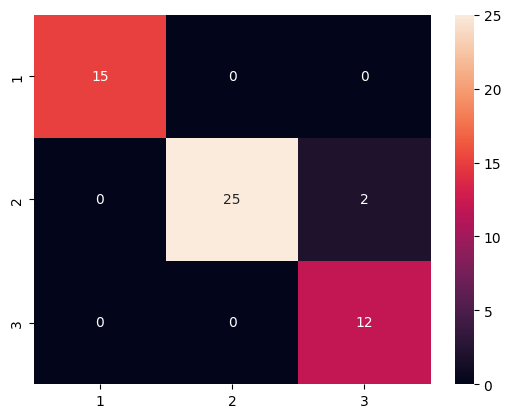


Accuracy of 90% or more achieved!


{'warm_start': False,
 'verbose': 0,
 'random_state': 10,
 'oob_score': False,
 'n_jobs': -1,
 'n_estimators': 50,
 'min_weight_fraction_leaf': 0.0,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'min_impurity_decrease': 0.0,
 'max_samples': None,
 'max_leaf_nodes': 20,
 'max_features': 'sqrt',
 'max_depth': None,
 'criterion': 'gini',
 'class_weight': None,
 'ccp_alpha': 0.0,
 'bootstrap': True}

In [65]:
print("--- Calling tuning for Wine dataset with Grid Search ---")
tune_random_forest_all_params(X, Y.values.ravel(), tuning_method='random')

--- Calling tuning for Wine dataset with Grid Search ---
Using GridSearchCV...
Fitting 3 folds for each of 64 candidates, totalling 192 fits
Tuning Method: grid
---------------------------------------
Best parameters found: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': -1, 'oob_score': False, 'random_state': 10, 'verbose': 0, 'warm_start': False}
Maximum Accuracy Achieved on Test Data: 96.30%

Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        15
           2       1.00      0.93      0.96        27
           3       0.86      1.00      0.92        12

    accuracy                           0.96        54
   macro avg       0.95      0.98      0.9

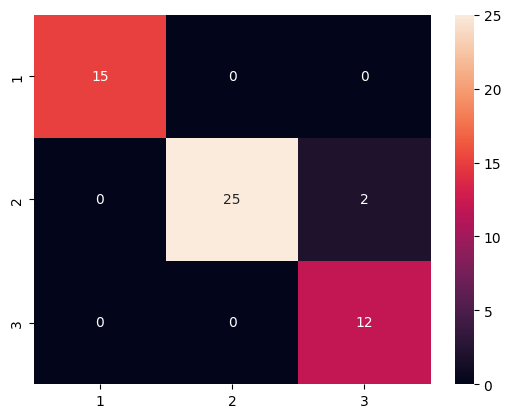


Accuracy of 90% or more achieved!


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 10,
 'verbose': 0,
 'warm_start': False}

In [66]:
print("--- Calling tuning for Wine dataset with Grid Search ---")
tune_random_forest_all_params(X, Y.values.ravel(), tuning_method='grid')

###RANDOM FOREST CLASSIFIER HYPER PARAMETER TUNING ( HANDWRITTEN DIGIT DATASET )




--- Calling tuning for HD dataset with Random Search ---
Using RandomizedSearchCV...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Tuning Method: random
---------------------------------------
Best parameters found: {'warm_start': False, 'verbose': 0, 'random_state': 10, 'oob_score': False, 'n_jobs': -1, 'n_estimators': 50, 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 5, 'min_samples_leaf': 1, 'min_impurity_decrease': 0.0, 'max_samples': None, 'max_leaf_nodes': None, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'gini', 'class_weight': 'balanced', 'ccp_alpha': 0.0, 'bootstrap': True}
Maximum Accuracy Achieved on Test Data: 97.63%

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       171
           1       0.96      0.97      0.97       192
           2       0.99      0.99      0.99       173
           3       0.97      0.97      0.97       179
           4       0.97      0.

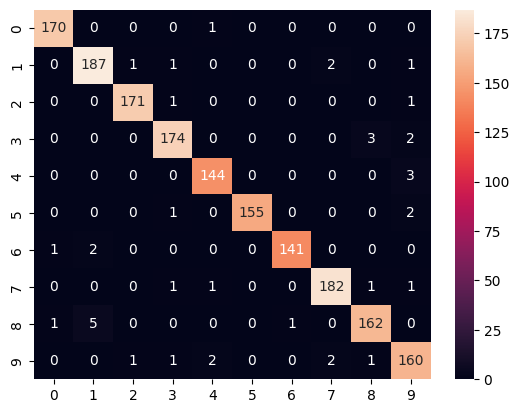


Accuracy of 90% or more achieved!


{'warm_start': False,
 'verbose': 0,
 'random_state': 10,
 'oob_score': False,
 'n_jobs': -1,
 'n_estimators': 50,
 'min_weight_fraction_leaf': 0.0,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'min_impurity_decrease': 0.0,
 'max_samples': None,
 'max_leaf_nodes': None,
 'max_features': 'sqrt',
 'max_depth': None,
 'criterion': 'gini',
 'class_weight': 'balanced',
 'ccp_alpha': 0.0,
 'bootstrap': True}

In [67]:
print("\n\n--- Calling tuning for HD dataset with Random Search ---")
tune_random_forest_all_params(x, y.values.ravel(), tuning_method='random')



--- Calling tuning for HD dataset with Grid Search ---
Using GridSearchCV...
Fitting 3 folds for each of 64 candidates, totalling 192 fits
Tuning Method: grid
---------------------------------------
Best parameters found: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': -1, 'oob_score': False, 'random_state': 10, 'verbose': 0, 'warm_start': False}
Maximum Accuracy Achieved on Test Data: 97.98%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       171
           1       0.94      0.98      0.96       192
           2       0.99      1.00      1.00       173
           3       0.99      0.97      0.98       179
           4       0.99      0.98      0

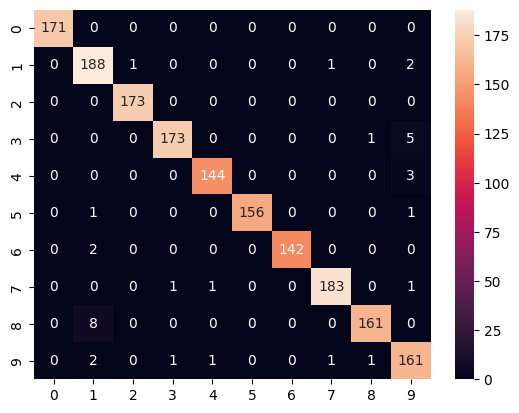


Accuracy of 90% or more achieved!


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 10,
 'verbose': 0,
 'warm_start': False}

In [68]:
print("\n\n--- Calling tuning for HD dataset with Grid Search ---")
tune_random_forest_all_params(x, y.values.ravel(), tuning_method='grid')

###CLASSIFIER PERFORMANCE COMPARISION

In [69]:
def get_max_accuracy(X, y, model, scaler=None, sampler=None):
    max_accuracy = 0
    for test_split in range(3, 8):
        X_train, y_train, X_test, y_test = preprocessing(X, y, scaler=scaler, sampler=sampler, test_split=test_split * 0.1)
        accuracy,_,_ = trainAndPredict(model, X_train, y_train, X_test, y_test)
        if accuracy > max_accuracy:
            max_accuracy = accuracy
    return max_accuracy

wine_accuracies = {}
hd_accuracies = {}

wine_accuracies["SVM (Linear)"] = get_max_accuracy(X, Y.values.ravel(), model=SVC(kernel='linear'), scaler=StandardScaler(), sampler=RandomOverSampler())
wine_accuracies["SVM (Polynomial)"] = get_max_accuracy(X, Y.values.ravel(), model=SVC(kernel='poly'), scaler=StandardScaler(), sampler=RandomOverSampler())
wine_accuracies["SVM (Gaussian)"] = get_max_accuracy(X, Y.values.ravel(), model=SVC(kernel='rbf',gamma=0.01), scaler=StandardScaler(), sampler=RandomOverSampler())
wine_accuracies["SVM (Sigmoid)"] = get_max_accuracy(X, Y.values.ravel(), model=SVC(kernel='sigmoid', gamma=0.01), scaler=StandardScaler(), sampler=RandomOverSampler())
wine_accuracies["MLP"] = get_max_accuracy(X, Y.values.ravel(), model=MLPClassifier(max_iter=1000, learning_rate='adaptive'), scaler=StandardScaler(), sampler=RandomOverSampler())
wine_accuracies["Random Forest"] = get_max_accuracy(X, Y.values.ravel(), model=RandomForestClassifier(random_state=10), sampler=RandomOverSampler())

hd_accuracies["SVM (Linear)"] = get_max_accuracy(x, y.values.ravel(), model=SVC(kernel='linear'), scaler=StandardScaler(), sampler=RandomOverSampler())
hd_accuracies["SVM (Polynomial)"] = get_max_accuracy(x, y.values.ravel(), model=SVC(kernel='poly'), scaler=StandardScaler(), sampler=RandomOverSampler())
hd_accuracies["SVM (Gaussian)"] = get_max_accuracy(x, y.values.ravel(), model=SVC(kernel='rbf'), scaler=StandardScaler(), sampler=RandomOverSampler())
hd_accuracies["SVM (Sigmoid)"] = get_max_accuracy(x, y.values.ravel(), model=SVC(kernel='sigmoid', gamma=0.01), scaler=StandardScaler(), sampler=RandomOverSampler())
hd_accuracies["MLP"] = get_max_accuracy(x, y.values.ravel(), model=MLPClassifier(max_iter=1000, learning_rate='adaptive'), scaler=StandardScaler(), sampler=RandomOverSampler())
hd_accuracies["Random Forest"] = get_max_accuracy(x, y.values.ravel(), model=RandomForestClassifier(random_state=10), sampler=RandomOverSampler())

data = {
    'Wine Dataset Accuracy': [f"{acc * 100:.2f}%" for acc in wine_accuracies.values()],
    'HD Dataset Accuracy': [f"{acc * 100:.2f}%" for acc in hd_accuracies.values()]
}

df_comparison = pd.DataFrame(data, index=list(wine_accuracies.keys()))

print("Classifier Performance Comparison Table")
print(df_comparison)

best_wine_classifier = max(wine_accuracies, key=wine_accuracies.get)
best_wine_accuracy = wine_accuracies[best_wine_classifier]
print(f"\nFor the Wine dataset, the best classifier is {best_wine_classifier} with a maximum accuracy of {best_wine_accuracy * 100:.2f}%.")

best_hd_classifier = max(hd_accuracies, key=hd_accuracies.get)
best_hd_accuracy = hd_accuracies[best_hd_classifier]
print(f"For the HandWritten Digit (HD) dataset, the best classifier is {best_hd_classifier} with a maximum accuracy of {best_hd_accuracy * 100:.2f}%.")


Classifier Performance Comparison Table
                 Wine Dataset Accuracy HD Dataset Accuracy
SVM (Linear)                    98.40%              97.63%
SVM (Polynomial)                92.59%              97.15%
SVM (Gaussian)                  98.13%              98.09%
SVM (Sigmoid)                   98.13%              96.12%
MLP                             96.80%              98.22%
Random Forest                   96.30%              98.08%

For the Wine dataset, the best classifier is SVM (Linear) with a maximum accuracy of 98.40%.
For the HandWritten Digit (HD) dataset, the best classifier is MLP with a maximum accuracy of 98.22%.
